In [1]:
import os
import time
import math
import numpy as np
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import datetime
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc", 
              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body", 
              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed", 
              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang", 
              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product", 
              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol", 
              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc", 
              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country", 
              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count", 
              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other", 
              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize", 
              "NUM_weight"]

In [6]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 24
batch_size = 92

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6 #5e-6?
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 200
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator" - 0.47 best when only change this line

In [ ]:
labeled_file = "../../ganbert-master/data/labeled.tsv"
unlabeled_file = "../../ganbert-master/data/unlabeled.tsv"
test_filename = "../../ganbert-master/data/test.tsv"

In [ ]:
def get_qc_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

In [ ]:
#Load the examples
labeled_examples = get_qc_examples(labeled_file)
unlabeled_examples = get_qc_examples(unlabeled_file)
test_examples = get_qc_examples(test_filename)

In [7]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.

In [11]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [12]:
#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [13]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

In [14]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [15]:
#OPTAGAN
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse

import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np

from torch.autograd import Variable
from modules.gan import Generator, Critic

import copy
import math
import glob
import os
import pickle
import random

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
from func import XLNetLMHeadModel, XLNetTokenizer
from func import TransfoXLLMHeadModel, TransfoXLTokenizer
from func import BertForLatentConnector, BertTokenizer

from collections import defaultdict
from utils import (TextDataset_Split, TextDataset_2Tokenizers, BucketingDataLoader)
import pdb
from modules.utils import (calc_blue_parallel_func, pad_seq, rollout, rollout_test)
#from transformers.modeling_utils import top_k_top_p_filtering


MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop
ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer)
}

num_txt = 1

def load_and_cache_examples(args, tokenizer):
    if isinstance(tokenizer, list):
        dataset = TextDataset_2Tokenizers(tokenizer, args, args.train_data_file, block_size=args.block_size)
    else:
        dataset = TextDataset_Split(tokenizer, args, args.train_data_file, block_size=args.block_size)
    return dataset

def build_dataload_and_cache_examples(args, tokenizer, num_txt):
    if isinstance(tokenizer, list):
        args.batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
        if num_txt<=20:
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
            print(concatenation)
            num_txt=num_txt+1
        else:
            num_txt=1
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
        dataloader = BucketingDataLoader(file_path, args.batch_size, args.max_seq_length, tokenizer, args, bucket=100, shuffle=True)
    else:
        pass 
    return dataloader, num_txt

def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if args.cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, 1).fill_(1.0) #args.latent_size
    outputs.requires_grad_(False)
    if args.cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty

def train(epoch):
    model_encoder.eval()
    model_decoder.eval()
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    c_batches = 0
    c_loss_0 = 1
    g_loss_0 = 1
    for i, x in enumerate(train_loader):
        x = x[0]
        if args.cuda:
            x = x.cuda()
        # Generate noise
        B = args.per_gpu_train_batch_size
        noise = torch.from_numpy(np.random.normal(0, 1, (B,
                                 args.latent_size))).float()
        if args.cuda:
            noise = noise.cuda()
        # Get original text latent embeddings
        with torch.no_grad(): 
            pooled_hidden_fea = model_encoder(x, attention_mask=(x > 0).float())[1]
            mean, logvar = model_encoder.linear(pooled_hidden_fea).chunk(2, -1)
            z_real = mean.squeeze(1) 

        # Evaluate and get losses
        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + \
                 args.gp_lambda*grad_penalty

        fake_score = critic(generator(noise))
        g_loss = -torch.mean(fake_score)
        
        r_g = abs(((g_loss.item() - g_loss_0) / (g_loss_0 + 0.001))) 
        r_c = abs(((c_loss.item() - c_loss_0) / (c_loss_0 + 0.001))) 
        
        # Update critic or generator
        if ((2 + epoch) / epoch) * r_c > r_g:
            c_optimizer.zero_grad()
            c_batches += 1
            c_train_loss += c_loss.item()
            c_loss.backward()
            c_optimizer.step()
        else:
            g_optimizer.zero_grad()
            g_batches += 1
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()

        c_loss_0 = c_loss.item()
        g_loss_0 = g_loss.item()

        if args.interval > 0 and i % args.interval == 0:
            logger.info('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, args.batch_size*i, len(train_loader.dataset),
                100.*(args.batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
            test_noise = torch.Tensor(np.random.normal(0, 1, (1, args.latent_size))).to(args.device)
            test_new_z = generator(test_noise).data
            # create new sent
            test_z = rollout_test(model_decoder, test_new_z, tokenizer_decoder, args.max_seq_length, 1, 0, 1)
            logger.info("Text: {}".format(test_z))

    c_train_loss /= c_batches + 1
    g_train_loss /= g_batches + 1
    logger.info('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f} | Updates G: {} | Updates C: {}'.format(
        epoch, g_train_loss, c_train_loss, g_batches, c_batches
    ))
    return (g_train_loss, c_train_loss)

[nltk_data] Downloading package punkt to /home/harry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gp_lambda', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator and critic")
    parser.add_argument('--block_dim', type=int, default=100)
    parser.add_argument('--interval', type=int, default=10, help="Steps before logging output")
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
    
    # Optimus parameters
    parser.add_argument("--train_data_file", default=None, type=str, required=True,
                        help="The input training data file (a text file).")
    parser.add_argument("--valid_data_file", default=None, type=str, required=True,
                        help="The input validation data file (a text file).")
    parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
                        help="The directory where checkpoints are saved.")
    parser.add_argument('--generator_dir', default=None, type=str, help="Directory where GAN models are saved")
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")
    parser.add_argument("--dataset", default='Snli', type=str, help="The dataset.")    
    parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
    ## Encoder options
    parser.add_argument("--encoder_model_type", default="bert", type=str,
                        help="The encoder model architecture to be fine-tuned.")
    parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The encoder model checkpoint for weights initialization.")
    parser.add_argument("--encoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--encoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    ## Decoder options
    parser.add_argument("--decoder_model_type", default="gpt2", type=str,
                        help="The decoder model architecture to be fine-tuned.")
    parser.add_argument("--decoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The decoder model checkpoint for weights initialization.")
    parser.add_argument("--decoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--decoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    parser.add_argument("--per_gpu_train_batch_size", default=1, type=int,
                        help="Batch size per GPU/CPU for training.")
    parser.add_argument("--max_seq_length", default=512, type=int,
                        help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")

    ## Variational auto-encoder(check this)
    parser.add_argument("--prompt", type=str, default="")
    parser.add_argument("--padding_text", type=str, default="")
    parser.add_argument("--length", type=int, default=20)
    parser.add_argument("--block_size", default=-1, type=int,
                        help="Optional input sequence length after tokenization."
                             "The training dataset will be truncated in block of this size for training."
                             "Default to the model max input length for single sentence inputs (take into account special tokens).")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--use_philly", action='store_true',
                        help="Use Philly for computing.")
    parser.add_argument('--gloabl_step_eval', type=int, default=661,
                        help="Evaluate the results at the given global step")
    # Reinforcement learning parameters
    parser.add_argument('--finetune_decoder', type=bool, default=True)
    parser.add_argument('--epochs_rl', type=int, default=1000)
    parser.add_argument('--batch_size_rl', type=int, default=32)
    parser.add_argument('--lr_rl', type=float, default=1e-6)


    # Load a trained Encoder model and vocabulary that you have fine-tuned
    args = parser.parse_args("--dataset EMNLP \
    --checkpoint_dir=output_dir_768_0_unsure \
    --output_dir=output_dir_768_0_unsure \
    --encoder_model_type=bert \
    --encoder_model_name_or_path=bert-base-cased \
    --decoder_model_type=gpt2 \
    --decoder_model_name_or_path=gpt2 \
    --train_data_file=../../yahoo/subdivided_large/train \
    --valid_data_file=../../yahoo/unlabelled_short/test.txt \
    --per_gpu_train_batch_size 12 \
    --block_size 100 \
    --max_seq_length 24 \
    --gloabl_step_eval 508523 \
    --latent_size 768 \
    --block_dim 100 \
    --n_layers 10 \
    --interval 50 \
    --epochs 200 \
    --finetune_decoder False \
    --lr_rl 1e-6 \
    --epochs_rl 100 \
    --batch_size_rl 32".split())
    
    print(args)

    global_step = args.gloabl_step_eval

    torch.backends.cudnn.deterministic = True
    #args.device = torch.device("cuda" if args.cuda else "cpu")
    #args.n_gpu = torch.cuda.device_count()
    args.device = torch.device("cuda:0")
    args.n_gpu=1
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)       
    
    args.encoder_model_type = args.encoder_model_type.lower()
    args.decoder_model_type = args.decoder_model_type.lower()

    output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
    output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step)) 
    checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
    model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

    model_encoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

    # Load a trained Decoder model and vocabulary that you have fine-tuned
    decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
    model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
    model_decoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

    # Chunyuan: Add Padding token to GPT2
    special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
    num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
    logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
    model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
    assert tokenizer_decoder.pad_token == '<PAD>'

    #train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
    generator = Generator(args.n_layers, args.block_dim,args.latent_size)
    critic = Critic(args.n_layers, args.block_dim,args.latent_size)

    if args.generator_dir!=None:
        logger.info("Loading generator and critic")
        generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        critic.load_state_dict(torch.load(args.generator_dir+'/critic_'+str(args.gloabl_step_eval)+'.th'))

    g_optimizer = optim.Adam(generator.parameters(), lr=args.lr, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=args.lr, betas=(0.5, 0.999))
    
    if args.cuda:
        generator = generator.cuda()
        critic = critic.cuda()
    
    logger.info('G Parameters:{}'.format(sum([p.numel() for p in generator.parameters() if \
                                p.requires_grad])))
    logger.info('C Parameters:{}'.format(sum([p.numel() for p in critic.parameters() if \
                                p.requires_grad])))
    
    device = args.device
    
    best_bleu = 0
    reference = list()
    with(open(args.valid_data_file,"r")) as valid:
        for sents in valid:
            reference.append(sents.replace("\n", ""))
            
    for epoch in range(1, args.epochs + 1):
        
        #Insert GAN-BERT Code Here
        
        train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
        
        print("Train classification discriminator")
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, args.epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        tr_g_loss = 0
        tr_d_loss = 0

        # Put the model into training mode.
        transformer.train() 
        #generator.train()
        discriminator.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every print_each_n_step batches.
            if step % print_each_n_step == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_label_mask = batch[3].to(device)

            real_batch_size = b_input_ids.shape[0]

            # Encode real data in the Transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            #print("  Number of real sentences (labelled and unlabelled): {}".format(len(hidden_states)))
            
            # Generate fake data that should have the same distribution of the ones
            # encoded by the transformer. 
            # First noisy input are used in input to the Generator
            fixed_noise = torch.Tensor(np.random.normal(0, 1, (real_batch_size, args.latent_size))).to(args.device)
            test_z_gb = generator(fixed_noise).data
            fake_sentences = rollout_test(model_decoder, test_z_gb, tokenizer_decoder, args.max_seq_length, real_batch_size, 0, 1)
            #print("  Number of generated sentences: {}".format(len(fake_sentences)))

            b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
            model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
            hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
            #hidden_states_fake = model_outputs_fake[-1]

            #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
            # Gnerate Fake data
            #gen_rep = generator(noise)
            #print("Length of generator output {}".format(len(gen_rep)))
            #print("Length of single generator output {}".format(len(gen_rep[0])))

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
            # Then, we select the output of the disciminator
            features, logits, probs = discriminator(disciminator_input)

            # Finally, we separate the discriminator's output for the real and fake
            # data
            features_list = torch.split(features, real_batch_size)
            D_real_features = features_list[0]
            D_fake_features = features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #---------------------------------
            #  LOSS evaluation
            #---------------------------------
            # Generator's LOSS estimation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Disciminator's LOSS estimation
            logits = D_real_logits[:,0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            # The discriminator provides an output for labeled and unlabeled real data
            # so the loss evaluated for unlabeled data is ignored (masked)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            # It may be the case that a batch does not contain labeled examples, 
            # so the "supervised loss" in this case is not evaluated
            if labeled_example_count == 0:
              D_L_Supervised = 0
            else:
              D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            #---------------------------------
            #  OPTIMIZATION
            #---------------------------------
            # Avoid gradient accumulation
            #gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            # Calculate weigth updates
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward() 

            # Apply modifications
            #gen_optimizer.step()
            dis_optimizer.step()

            # A detail log of the individual losses
            #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
            #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
            #             g_loss_d, g_feat_reg))

            # Save the losses to print them later
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

            # Update the learning rate with the scheduler
            if apply_scheduler:
              scheduler_d.step()
              #scheduler_g.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)             

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #     TEST ON THE EVALUATION DATASET
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our test set.
        print("")
        print("Running Test...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        transformer.eval() #maybe redundant
        discriminator.eval()
        #generator.eval()

        # Tracking variables 
        total_test_accuracy = 0

        total_test_loss = 0
        nb_test_steps = 0

        all_preds = []
        all_labels_ids = []

        #loss
        nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
                hidden_states = model_outputs.last_hidden_state[:,0,:] 
                #hidden_states = model_outputs[-1]
                _, logits, probs = discriminator(hidden_states)
                ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
                filtered_logits = logits[:,0:-1]
                # Accumulate the test loss.
                total_test_loss += nll_loss(filtered_logits, b_labels)

            # Accumulate the predictions and the input labels
            _, preds = torch.max(filtered_logits, 1)
            all_preds += preds.detach().cpu()
            all_labels_ids += b_labels.detach().cpu()

        # Report the final accuracy for this validation run.
        all_preds = torch.stack(all_preds).numpy()
        all_labels_ids = torch.stack(all_labels_ids).numpy()
        test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
        print("  Accuracy: {0:.3f}".format(test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_loss = avg_test_loss.item()

        # Measure how long the validation run took.
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.3f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss generator': avg_train_loss_g,
                'Training Loss discriminator': avg_train_loss_d,
                'Valid. Loss': avg_test_loss,
                'Valid. Accur.': test_accuracy,
                'Training Time': training_time,
                'Test Time': test_time
            }
        )

        accuracy_array.append(test_accuracy)
        
        #OPTAGAN Code
        
        g_loss, c_loss = train(epoch)

        data_test = list()
        for i in range(2):
            test_noise = torch.Tensor(np.random.normal(0, 1, (250, args.latent_size))).to(args.device)
            test_z = generator(test_noise).data
            new_sent = rollout_test(model_decoder, test_z, tokenizer_decoder, args.max_seq_length, 250, 0, 1)
            data_test.extend(new_sent)

        p_reference = random.sample(reference, 500)
        bleu = calc_blue_parallel_func(p_reference, data_test, 2, 500)
        b_bleu = calc_blue_parallel_func(data_test, p_reference, 2, 500)
        logger.info("Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}".format(bleu, b_bleu))
        
        print(bleu+b_bleu)
        if (bleu+b_bleu) > best_bleu:
            best_bleu = bleu + b_bleu
            logger.info('* Saving. Best Score:{:0.3f} | Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}'.format(best_bleu, bleu, b_bleu))
            torch.save(generator.state_dict(), args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th')
            torch.save(critic.state_dict(), args.output_dir+'/critic_'+str(args.gloabl_step_eval)+'.th')
            
        

    if args.finetune_decoder: 
        logger.info("Loading generator")
        generator.load_state_dict(torch.load(args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        
        model_decoder.train()
        generator.eval()
        dec_optimizer = optim.Adam(model_decoder.parameters(), lr=1e-4, betas=(0.5, 0.999))
        value_loss = nn.L1Loss()
        B = args.batch_size_rl
        total_scores = 0
        total_entropy = 0
        total_values = 0
        total_v_loss = 0
        for epoch_ in range(args.epochs_rl):
            if epoch_ == 200:
                # Finetune decoder after training of value head
                dec_optimizer = optim.Adam(model_decoder.parameters(), lr=args.lr_rl, betas=(0.5, 0.999))
            noise = torch.from_numpy(np.random.normal(0, 1, (B, args.latent_size))).float()
            noise = noise.to(args.device)
            z_fake = generator(noise)            
            sents, logprobs, values, entropy = rollout(model_decoder, z_fake, tokenizer_decoder, args.max_seq_length, B, 1)
            p_reference = random.sample(reference, 500)

            blue = []
            for i in sents:
                blue.append(calc_blue_parallel_func(p_reference, [i], 1, 0))

            values = torch.stack(values, dim=1)
            logprobs = torch.stack(logprobs, dim=1)
            entropy = torch.stack(entropy, dim=1)

            # Get tokens and mask of batch
            toks_gpt = [([50258] + tokenizer_decoder.encode(j) + [50259]) for j in sents]
            toks_gpt, mask = pad_seq(toks_gpt, tokenizer_decoder.encode("<PAD>")[0], values.size(1)+1)
            toks_gpt = torch.tensor(toks_gpt).to(args.device)
            mask = torch.tensor(mask).to(args.device)
              
            values = values * mask[:,1:]
            logprobs = logprobs * mask[:,1:]
            entropy = entropy * mask[:,1:]
            scores = torch.tensor(blue).to(args.device)
            # Get value loss
            v_loss = value_loss(torch.sum(values, dim=1), scores) 
              
            if epoch_ >= 200:
                R = 0
                rewards = []

                # Discount future rewards back to the present using gamma
                for j in range(len(values.tolist())):
                    R = 0
                    batch_rewards = []
                    for r in reversed(values.tolist()[j]):
                        R = r + 0.99 * R
                        batch_rewards.insert(0,R)
                    rewards.append(batch_rewards)

                # Penalizing low entropy states
                rewards = torch.FloatTensor(rewards).to(args.device)
                rewards = rewards + torch.log(torch.clamp(entropy,0.2,1))
                # Calculate loss
                d_loss = torch.sum(torch.mul(logprobs, rewards.detach()).mul(-1))
            else:
                d_loss = torch.tensor(0)

            # Backpropagate losses
            loss = v_loss + d_loss              
            dec_optimizer.zero_grad()              
            loss.backward()
            dec_optimizer.step()

            total_scores += torch.mean(scores).item()
            total_values += torch.mean(torch.sum(values,-1)).item()
            total_v_loss += v_loss.item()
            total_entropy += torch.mean(torch.mean(entropy,dim=1)).item()
            if (epoch_ % args.interval) == 0:
                logger.info("Epoch {}/{} | Value Loss:{} | Mean values:{} | Mean BLEU scores:{} | Mean Entropy: {}".format(epoch_, 
                args.epochs_rl, total_v_loss/args.interval, total_values/args.interval, total_scores/args.interval, total_entropy/args.interval))
                total_scores = 0
                total_values = 0
                total_v_loss = 0
                total_entropy = 0
        logger.info("Saving decoder")
        output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
        if not os.path.exists(output_decoder_dir):
            os.makedirs(output_decoder_dir)
        model_decoder.save_pretrained(output_decoder_dir)
        torch.save(args, os.path.join(output_decoder_dir, 'training_encoder_args.bin'))   

06/28/2022 23:40:59 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure/checkpoint-encoder-508523/config.json
06/28/2022 23:40:59 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

06/28/2022 23:40:59 - INFO - func.modeling_utils -   loading weights file output_dir_768_0_unsure/checkpoint-encoder-508523/pytorch_model.bin


Namespace(batch_size_rl=32, block_dim=100, block_size=100, checkpoint_dir='output_dir_768_0_unsure', cuda=True, dataset='EMNLP', decoder_config_name='', decoder_model_name_or_path='gpt2', decoder_model_type='gpt2', decoder_tokenizer_name='', do_lower_case=False, encoder_config_name='', encoder_model_name_or_path='bert-base-cased', encoder_model_type='bert', encoder_tokenizer_name='', epochs=200, epochs_rl=100, finetune_decoder=True, generator_dir=None, gloabl_step_eval=508523, gp_lambda=10, interval=50, latent_size=768, length=20, lr=0.0001, lr_rl=1e-06, max_seq_length=24, n_layers=10, output_dir='output_dir_768_0_unsure', padding_text='', per_gpu_train_batch_size=12, prompt='', seed=0, train_data_file='../../yahoo/subdivided_large/train', use_philly=False, valid_data_file='../../yahoo/unlabelled_short/test.txt')


06/28/2022 23:41:02 - INFO - func.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/harry/.cache/torch/pytorch_transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
06/28/2022 23:41:02 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure/checkpoint-decoder-508523/config.json
06/28/2022 23:41:02 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": nul

Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 1 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:13.
  Batch    20  of    120.    Elapsed: 0:00:27.
  Batch    30  of    120.    Elapsed: 0:00:42.
  Batch    40  of    120.    Elapsed: 0:00:57.
  Batch    50  of    120.    Elapsed: 0:01:09.
  Batch    60  of    120.    Elapsed: 0:01:22.
  Batch    70  of    120.    Elapsed: 0:01:34.
  Batch    80  of    120.    Elapsed: 0:01:47.
  Batch    90  of    120.    Elapsed: 0:02:01.
  Batch   100  of    120.    Elapsed: 0:02:13.
  Batch   110  of    120.    Elapsed: 0:02:25.

  Average training loss generetor: 0.595
  Average training loss discriminator: 3.522
  Training epcoh took: 0:02:35

Running Test...


06/28/2022 23:43:43 - INFO - __main__ -   Epoch: 1 | Batch: 0/10000 (0%) | G Loss: 0.273712 | C Loss: 1.715680
06/28/2022 23:43:43 - INFO - __main__ -   Text: ['']


  Accuracy: 0.160
  Test Loss: 2.335
  Test took: 0:00:00


06/28/2022 23:43:44 - INFO - __main__ -   Epoch: 1 | Batch: 600/10000 (6%) | G Loss: 170.433945 | C Loss: -107.989746
06/28/2022 23:43:44 - INFO - __main__ -   Text: ['']
06/28/2022 23:43:45 - INFO - __main__ -   Epoch: 1 | Batch: 1200/10000 (12%) | G Loss: 98.062347 | C Loss: -66.542015
06/28/2022 23:43:45 - INFO - __main__ -   Text: ['Falk a... Shea. Max. City.. M. known to in on 30.']
06/28/2022 23:43:46 - INFO - __main__ -   Epoch: 1 | Batch: 1800/10000 (18%) | G Loss: 98.792358 | C Loss: -72.589859
06/28/2022 23:43:47 - INFO - __main__ -   Text: [",-.. B... to. in.'.. and. Jewish.'s."]
06/28/2022 23:43:47 - INFO - __main__ -   Epoch: 1 | Batch: 2400/10000 (24%) | G Loss: 69.131027 | C Loss: -47.843910
06/28/2022 23:43:48 - INFO - __main__ -   Text: ['the. while. Kumarified the Balls 201448_ decline Eastern..']
06/28/2022 23:43:49 - INFO - __main__ -   Epoch: 1 | Batch: 3000/10000 (30%) | G Loss: 63.769329 | C Loss: -47.872009
06/28/2022 23:43:49 - INFO - __main__ -   Text: ['Louis

0.2893336298816085
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 2 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:19.

  Average training loss generetor: 0.513
  Average training loss discriminator: 3.488
  Training epcoh took: 0:03:36

Running Test...


06/28/2022 23:47:47 - INFO - __main__ -   Epoch: 2 | Batch: 0/10001 (0%) | G Loss: 10.537098 | C Loss: -10.342489
06/28/2022 23:47:47 - INFO - __main__ -   Text: ['and Press."']


  Accuracy: 0.310
  Test Loss: 2.206
  Test took: 0:00:00


06/28/2022 23:47:48 - INFO - __main__ -   Epoch: 2 | Batch: 600/10001 (6%) | G Loss: 8.722316 | C Loss: -8.776833
06/28/2022 23:47:48 - INFO - __main__ -   Text: ["The people don don't don don no - That' Yes."]
06/28/2022 23:47:49 - INFO - __main__ -   Epoch: 2 | Batch: 1200/10001 (12%) | G Loss: 8.355919 | C Loss: -8.760653
06/28/2022 23:47:49 - INFO - __main__ -   Text: ['confusion... <BOS> capital).']
06/28/2022 23:47:50 - INFO - __main__ -   Epoch: 2 | Batch: 1800/10001 (18%) | G Loss: 6.890192 | C Loss: -7.398898
06/28/2022 23:47:50 - INFO - __main__ -   Text: ['arm to fight into his We I I.']
06/28/2022 23:47:51 - INFO - __main__ -   Epoch: 2 | Batch: 2400/10001 (24%) | G Loss: 5.494011 | C Loss: -5.887434
06/28/2022 23:47:51 - INFO - __main__ -   Text: ['They have no dentition and they become a beginner on Air.']
06/28/2022 23:47:52 - INFO - __main__ -   Epoch: 2 | Batch: 3000/10001 (30%) | G Loss: 4.376080 | C Loss: -4.719339
06/28/2022 23:47:52 - INFO - __main__ -   Text: ['En

0.3732984105188521
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 3 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:14.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:43.
  Batch    40  of    120.    Elapsed: 0:00:56.
  Batch    50  of    120.    Elapsed: 0:01:09.
  Batch    60  of    120.    Elapsed: 0:01:22.
  Batch    70  of    120.    Elapsed: 0:01:36.
  Batch    80  of    120.    Elapsed: 0:01:49.
  Batch    90  of    120.    Elapsed: 0:02:04.
  Batch   100  of    120.    Elapsed: 0:02:19.
  Batch   110  of    120.    Elapsed: 0:02:33.

  Average training loss generetor: 0.651
  Average training loss discriminator: 2.781
  Training epcoh took: 0:02:47

Running Test...


06/28/2022 23:51:00 - INFO - __main__ -   Epoch: 3 | Batch: 0/10001 (0%) | G Loss: 5.205673 | C Loss: -4.292138
06/28/2022 23:51:00 - INFO - __main__ -   Text: ['"Un hat."']


  Accuracy: 0.425
  Test Loss: 1.945
  Test took: 0:00:00


06/28/2022 23:51:01 - INFO - __main__ -   Epoch: 3 | Batch: 600/10001 (6%) | G Loss: 4.698145 | C Loss: -3.828710
06/28/2022 23:51:01 - INFO - __main__ -   Text: ['']
06/28/2022 23:51:02 - INFO - __main__ -   Epoch: 3 | Batch: 1200/10001 (12%) | G Loss: 4.804300 | C Loss: -4.225291
06/28/2022 23:51:02 - INFO - __main__ -   Text: ['It is repeatable here.']
06/28/2022 23:51:03 - INFO - __main__ -   Epoch: 3 | Batch: 1800/10001 (18%) | G Loss: 5.283571 | C Loss: -4.360872
06/28/2022 23:51:03 - INFO - __main__ -   Text: ['of the school of the college of the mouse.']
06/28/2022 23:51:04 - INFO - __main__ -   Epoch: 3 | Batch: 2400/10001 (24%) | G Loss: 4.852181 | C Loss: -4.199922
06/28/2022 23:51:04 - INFO - __main__ -   Text: ['Users of a man reaction are a Mark.']
06/28/2022 23:51:05 - INFO - __main__ -   Epoch: 3 | Batch: 3000/10001 (30%) | G Loss: 4.770012 | C Loss: -4.342875
06/28/2022 23:51:05 - INFO - __main__ -   Text: ["Stew Logical has suggested 'Since everything.'"]
06/28/2022 2

0.40827916381340934
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 4 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:58.
  Batch    50  of    120.    Elapsed: 0:01:14.
  Batch    60  of    120.    Elapsed: 0:01:28.
  Batch    70  of    120.    Elapsed: 0:01:41.
  Batch    80  of    120.    Elapsed: 0:01:55.
  Batch    90  of    120.    Elapsed: 0:02:09.
  Batch   100  of    120.    Elapsed: 0:02:24.
  Batch   110  of    120.    Elapsed: 0:02:39.

  Average training loss generetor: 0.689
  Average training loss discriminator: 2.109
  Training epcoh took: 0:02:53

Running Test...


06/28/2022 23:54:20 - INFO - __main__ -   Epoch: 4 | Batch: 0/10001 (0%) | G Loss: 4.625474 | C Loss: -3.978683
06/28/2022 23:54:20 - INFO - __main__ -   Text: ['Many more travelers are "ncip on."']


  Accuracy: 0.443
  Test Loss: 1.741
  Test took: 0:00:00


06/28/2022 23:54:21 - INFO - __main__ -   Epoch: 4 | Batch: 600/10001 (6%) | G Loss: 4.495766 | C Loss: -4.065772
06/28/2022 23:54:21 - INFO - __main__ -   Text: ['Wheel must not be invented "All Tom & Dia.']
06/28/2022 23:54:22 - INFO - __main__ -   Epoch: 4 | Batch: 1200/10001 (12%) | G Loss: 4.653400 | C Loss: -4.140658
06/28/2022 23:54:22 - INFO - __main__ -   Text: ['" Much real fast rate".']
06/28/2022 23:54:23 - INFO - __main__ -   Epoch: 4 | Batch: 1800/10001 (18%) | G Loss: 4.856598 | C Loss: -4.283592
06/28/2022 23:54:23 - INFO - __main__ -   Text: ['Belt Lip notes is that you should be on 2.']
06/28/2022 23:54:24 - INFO - __main__ -   Epoch: 4 | Batch: 2400/10001 (24%) | G Loss: 4.905535 | C Loss: -4.333271
06/28/2022 23:54:24 - INFO - __main__ -   Text: ['They say it can either pill or screw.']
06/28/2022 23:54:25 - INFO - __main__ -   Epoch: 4 | Batch: 3000/10001 (30%) | G Loss: 4.827443 | C Loss: -4.634796
06/28/2022 23:54:25 - INFO - __main__ -   Text: ['"The Avatar will

0.4359050785335863
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 5 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:14.
  Batch    20  of    120.    Elapsed: 0:00:29.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:58.
  Batch    50  of    120.    Elapsed: 0:01:12.
  Batch    60  of    120.    Elapsed: 0:01:26.
  Batch    70  of    120.    Elapsed: 0:01:40.
  Batch    80  of    120.    Elapsed: 0:01:54.
  Batch    90  of    120.    Elapsed: 0:02:09.
  Batch   100  of    120.    Elapsed: 0:02:23.
  Batch   110  of    120.    Elapsed: 0:02:37.

  Average training loss generetor: 0.703
  Average training loss discriminator: 1.558
  Training epcoh took: 0:02:50

Running Test...


06/28/2022 23:57:36 - INFO - __main__ -   Epoch: 5 | Batch: 0/10001 (0%) | G Loss: 4.347716 | C Loss: -3.933740
06/28/2022 23:57:36 - INFO - __main__ -   Text: ['Depending upon the spell of breakfast.']


  Accuracy: 0.453
  Test Loss: 1.687
  Test took: 0:00:00


06/28/2022 23:57:37 - INFO - __main__ -   Epoch: 5 | Batch: 600/10001 (6%) | G Loss: 4.376561 | C Loss: -3.801161
06/28/2022 23:57:37 - INFO - __main__ -   Text: ['Relinate some words that are not accepted by humans.']
06/28/2022 23:57:38 - INFO - __main__ -   Epoch: 5 | Batch: 1200/10001 (12%) | G Loss: 4.423728 | C Loss: -3.663232
06/28/2022 23:57:38 - INFO - __main__ -   Text: ['It contains traces of Hebrew (mistrain).']
06/28/2022 23:57:39 - INFO - __main__ -   Epoch: 5 | Batch: 1800/10001 (18%) | G Loss: 4.843112 | C Loss: -4.069310
06/28/2022 23:57:39 - INFO - __main__ -   Text: ['"Refia" may refer to:']
06/28/2022 23:57:40 - INFO - __main__ -   Epoch: 5 | Batch: 2400/10001 (24%) | G Loss: 4.440497 | C Loss: -3.754192
06/28/2022 23:57:40 - INFO - __main__ -   Text: ['What happens so much might occur when a professional horse does cannot speak outside of Africa.']
06/28/2022 23:57:41 - INFO - __main__ -   Epoch: 5 | Batch: 3000/10001 (30%) | G Loss: 4.879333 | C Loss: -4.104866
06

0.4448469935700208
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 6 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:59.
  Batch    50  of    120.    Elapsed: 0:01:13.
  Batch    60  of    120.    Elapsed: 0:01:28.
  Batch    70  of    120.    Elapsed: 0:01:41.
  Batch    80  of    120.    Elapsed: 0:01:55.
  Batch    90  of    120.    Elapsed: 0:02:09.
  Batch   100  of    120.    Elapsed: 0:02:23.
  Batch   110  of    120.    Elapsed: 0:02:38.

  Average training loss generetor: 0.707
  Average training loss discriminator: 1.198
  Training epcoh took: 0:02:52

Running Test...


06/29/2022 00:00:52 - INFO - __main__ -   Epoch: 6 | Batch: 0/10001 (0%) | G Loss: 4.091562 | C Loss: -3.639133
06/29/2022 00:00:52 - INFO - __main__ -   Text: ['Equivalent means similar or not."']


  Accuracy: 0.475
  Test Loss: 1.698
  Test took: 0:00:00


06/29/2022 00:00:53 - INFO - __main__ -   Epoch: 6 | Batch: 600/10001 (6%) | G Loss: 4.584288 | C Loss: -3.644062
06/29/2022 00:00:53 - INFO - __main__ -   Text: ['The mean hour time is 3 seconds on the floor.']
06/29/2022 00:00:54 - INFO - __main__ -   Epoch: 6 | Batch: 1200/10001 (12%) | G Loss: 3.896769 | C Loss: -3.217595
06/29/2022 00:00:54 - INFO - __main__ -   Text: ['L or Lthat build a fence']
06/29/2022 00:00:55 - INFO - __main__ -   Epoch: 6 | Batch: 1800/10001 (18%) | G Loss: 4.066328 | C Loss: -3.363063
06/29/2022 00:00:56 - INFO - __main__ -   Text: ['Its creator reflects, however, that they are a universe.']
06/29/2022 00:00:56 - INFO - __main__ -   Epoch: 6 | Batch: 2400/10001 (24%) | G Loss: 4.639219 | C Loss: -3.695181
06/29/2022 00:00:57 - INFO - __main__ -   Text: ["The word states it's something that should come naturally."]
06/29/2022 00:00:58 - INFO - __main__ -   Epoch: 6 | Batch: 3000/10001 (30%) | G Loss: 3.844048 | C Loss: -3.350890
06/29/2022 00:00:58 - INFO 

0.48585232620368696
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 7 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:01.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:32.
  Batch    70  of    120.    Elapsed: 0:01:47.
  Batch    80  of    120.    Elapsed: 0:02:03.
  Batch    90  of    120.    Elapsed: 0:02:18.
  Batch   100  of    120.    Elapsed: 0:02:32.
  Batch   110  of    120.    Elapsed: 0:02:46.

  Average training loss generetor: 0.710
  Average training loss discriminator: 1.033
  Training epcoh took: 0:03:00

Running Test...


06/29/2022 00:04:18 - INFO - __main__ -   Epoch: 7 | Batch: 0/10001 (0%) | G Loss: 4.024259 | C Loss: -3.178649
06/29/2022 00:04:18 - INFO - __main__ -   Text: ["He prefers cocoa futures and won't give a shit about diamonds."]


  Accuracy: 0.465
  Test Loss: 1.760
  Test took: 0:00:00


06/29/2022 00:04:19 - INFO - __main__ -   Epoch: 7 | Batch: 600/10001 (6%) | G Loss: 3.554472 | C Loss: -2.974874
06/29/2022 00:04:20 - INFO - __main__ -   Text: ['Once to get on does it take five minutes.']
06/29/2022 00:04:20 - INFO - __main__ -   Epoch: 7 | Batch: 1200/10001 (12%) | G Loss: 3.471743 | C Loss: -3.171472
06/29/2022 00:04:21 - INFO - __main__ -   Text: ['Thrifty is the better bid.']
06/29/2022 00:04:22 - INFO - __main__ -   Epoch: 7 | Batch: 1800/10001 (18%) | G Loss: 3.631153 | C Loss: -3.209269
06/29/2022 00:04:22 - INFO - __main__ -   Text: ['The user is posted numerically as three numbers.']
06/29/2022 00:04:23 - INFO - __main__ -   Epoch: 7 | Batch: 2400/10001 (24%) | G Loss: 3.279698 | C Loss: -2.858052
06/29/2022 00:04:23 - INFO - __main__ -   Text: ['It might be "essentially getting soft by swimming".']
06/29/2022 00:04:24 - INFO - __main__ -   Epoch: 7 | Batch: 3000/10001 (30%) | G Loss: 3.610750 | C Loss: -2.929860
06/29/2022 00:04:24 - INFO - __main__ -   Te

0.492635028035026
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 8 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:01:00.
  Batch    50  of    120.    Elapsed: 0:01:15.
  Batch    60  of    120.    Elapsed: 0:01:31.
  Batch    70  of    120.    Elapsed: 0:01:47.
  Batch    80  of    120.    Elapsed: 0:02:02.
  Batch    90  of    120.    Elapsed: 0:02:18.
  Batch   100  of    120.    Elapsed: 0:02:33.
  Batch   110  of    120.    Elapsed: 0:02:49.

  Average training loss generetor: 0.708
  Average training loss discriminator: 0.943
  Training epcoh took: 0:03:04

Running Test...


06/29/2022 00:07:49 - INFO - __main__ -   Epoch: 8 | Batch: 0/10001 (0%) | G Loss: 3.479847 | C Loss: -2.725304
06/29/2022 00:07:49 - INFO - __main__ -   Text: ['To Kill Me Unlike any other game, you need to be badly out of practice."']


  Accuracy: 0.460
  Test Loss: 1.822
  Test took: 0:00:00


06/29/2022 00:07:50 - INFO - __main__ -   Epoch: 8 | Batch: 600/10001 (6%) | G Loss: 3.327838 | C Loss: -3.050297
06/29/2022 00:07:50 - INFO - __main__ -   Text: ['The cookie is thieves.']
06/29/2022 00:07:51 - INFO - __main__ -   Epoch: 8 | Batch: 1200/10001 (12%) | G Loss: 3.352816 | C Loss: -3.033035
06/29/2022 00:07:51 - INFO - __main__ -   Text: ['It is about case and event, and may or may not fall in love."']
06/29/2022 00:07:52 - INFO - __main__ -   Epoch: 8 | Batch: 1800/10001 (18%) | G Loss: 3.019660 | C Loss: -2.847000
06/29/2022 00:07:52 - INFO - __main__ -   Text: ['9010110 will need to know fuck everything.']
06/29/2022 00:07:53 - INFO - __main__ -   Epoch: 8 | Batch: 2400/10001 (24%) | G Loss: 3.139567 | C Loss: -2.735409
06/29/2022 00:07:53 - INFO - __main__ -   Text: ['The name derives from this.']
06/29/2022 00:07:54 - INFO - __main__ -   Epoch: 8 | Batch: 3000/10001 (30%) | G Loss: 3.519344 | C Loss: -2.913223
06/29/2022 00:07:54 - INFO - __main__ -   Text: ['This wou

0.48338889265521523
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 9 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:48.
  Batch    40  of    120.    Elapsed: 0:01:04.
  Batch    50  of    120.    Elapsed: 0:01:19.
  Batch    60  of    120.    Elapsed: 0:01:35.
  Batch    70  of    120.    Elapsed: 0:01:50.
  Batch    80  of    120.    Elapsed: 0:02:06.
  Batch    90  of    120.    Elapsed: 0:02:21.
  Batch   100  of    120.    Elapsed: 0:02:37.
  Batch   110  of    120.    Elapsed: 0:02:53.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.902
  Training epcoh took: 0:03:08

Running Test...


06/29/2022 00:11:23 - INFO - __main__ -   Epoch: 9 | Batch: 0/10001 (0%) | G Loss: 3.097848 | C Loss: -2.702584
06/29/2022 00:11:23 - INFO - __main__ -   Text: ['What type of a person is he aka?"']


  Accuracy: 0.453
  Test Loss: 1.879
  Test took: 0:00:00


06/29/2022 00:11:24 - INFO - __main__ -   Epoch: 9 | Batch: 600/10001 (6%) | G Loss: 2.868973 | C Loss: -2.458696
06/29/2022 00:11:24 - INFO - __main__ -   Text: ['Her hat is that glassware is the better way.']
06/29/2022 00:11:25 - INFO - __main__ -   Epoch: 9 | Batch: 1200/10001 (12%) | G Loss: 2.938197 | C Loss: -2.503902
06/29/2022 00:11:25 - INFO - __main__ -   Text: ['A great name like Tolkien would clarify this.']
06/29/2022 00:11:26 - INFO - __main__ -   Epoch: 9 | Batch: 1800/10001 (18%) | G Loss: 3.002851 | C Loss: -2.616432
06/29/2022 00:11:26 - INFO - __main__ -   Text: ['Others use their meet separately as a forum forum.']
06/29/2022 00:11:27 - INFO - __main__ -   Epoch: 9 | Batch: 2400/10001 (24%) | G Loss: 2.943268 | C Loss: -2.420340
06/29/2022 00:11:27 - INFO - __main__ -   Text: ['This is what I mean..']
06/29/2022 00:11:28 - INFO - __main__ -   Epoch: 9 | Batch: 3000/10001 (30%) | G Loss: 3.045290 | C Loss: -2.495130
06/29/2022 00:11:28 - INFO - __main__ -   Text: ['

0.4616985228734093
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 10 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:05.
  Batch    90  of    120.    Elapsed: 0:02:21.
  Batch   100  of    120.    Elapsed: 0:02:37.
  Batch   110  of    120.    Elapsed: 0:02:52.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.859
  Training epcoh took: 0:03:07

Running Test...


06/29/2022 00:14:57 - INFO - __main__ -   Epoch: 10 | Batch: 0/10001 (0%) | G Loss: 2.750843 | C Loss: -2.363748
06/29/2022 00:14:57 - INFO - __main__ -   Text: ['It describes a girl\'s attitude towards the girl "Oh!']


  Accuracy: 0.463
  Test Loss: 1.931
  Test took: 0:00:00


06/29/2022 00:14:58 - INFO - __main__ -   Epoch: 10 | Batch: 600/10001 (6%) | G Loss: 2.670437 | C Loss: -2.263986
06/29/2022 00:14:58 - INFO - __main__ -   Text: ['Which way to go?']
06/29/2022 00:14:59 - INFO - __main__ -   Epoch: 10 | Batch: 1200/10001 (12%) | G Loss: 2.597699 | C Loss: -2.268857
06/29/2022 00:14:59 - INFO - __main__ -   Text: ['There is no automatic method.']
06/29/2022 00:15:00 - INFO - __main__ -   Epoch: 10 | Batch: 1800/10001 (18%) | G Loss: 2.780270 | C Loss: -2.394011
06/29/2022 00:15:00 - INFO - __main__ -   Text: ['Zombies are best friends ...']
06/29/2022 00:15:01 - INFO - __main__ -   Epoch: 10 | Batch: 2400/10001 (24%) | G Loss: 2.619523 | C Loss: -2.205571
06/29/2022 00:15:01 - INFO - __main__ -   Text: ["This may be some of the most depressing comments I've ever made."]
06/29/2022 00:15:02 - INFO - __main__ -   Epoch: 10 | Batch: 3000/10001 (30%) | G Loss: 2.485711 | C Loss: -2.218050
06/29/2022 00:15:02 - INFO - __main__ -   Text: ['"Romia | Amity" re

0.4516707816164156
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 11 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:14.
  Batch    20  of    120.    Elapsed: 0:00:27.
  Batch    30  of    120.    Elapsed: 0:00:41.
  Batch    40  of    120.    Elapsed: 0:00:56.
  Batch    50  of    120.    Elapsed: 0:01:10.
  Batch    60  of    120.    Elapsed: 0:01:25.
  Batch    70  of    120.    Elapsed: 0:01:39.
  Batch    80  of    120.    Elapsed: 0:01:54.
  Batch    90  of    120.    Elapsed: 0:02:09.
  Batch   100  of    120.    Elapsed: 0:02:23.
  Batch   110  of    120.    Elapsed: 0:02:36.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.835
  Training epcoh took: 0:02:50

Running Test...


06/29/2022 00:18:11 - INFO - __main__ -   Epoch: 11 | Batch: 0/10001 (0%) | G Loss: 2.493561 | C Loss: -2.020450


  Accuracy: 0.460
  Test Loss: 1.984
  Test took: 0:00:00


06/29/2022 00:18:11 - INFO - __main__ -   Text: ['It is praised by some vernacular writers which means it is only possible for the cat.']
06/29/2022 00:18:12 - INFO - __main__ -   Epoch: 11 | Batch: 600/10001 (6%) | G Loss: 2.386309 | C Loss: -1.965739
06/29/2022 00:18:12 - INFO - __main__ -   Text: ['These are sarcasm in the modern framework.']
06/29/2022 00:18:13 - INFO - __main__ -   Epoch: 11 | Batch: 1200/10001 (12%) | G Loss: 2.120681 | C Loss: -1.733567
06/29/2022 00:18:13 - INFO - __main__ -   Text: ['"Doo Leader" is waiting for daily life action.']
06/29/2022 00:18:14 - INFO - __main__ -   Epoch: 11 | Batch: 1800/10001 (18%) | G Loss: 2.414364 | C Loss: -1.900485
06/29/2022 00:18:15 - INFO - __main__ -   Text: ['As a result, bron in, do you really want to be part of the capital?" <PAD> Therefore,']
06/29/2022 00:18:15 - INFO - __main__ -   Epoch: 11 | Batch: 2400/10001 (24%) | G Loss: 2.326859 | C Loss: -1.983680
06/29/2022 00:18:16 - INFO - __main__ -   Text: ['Then," reitera

0.4902285474070768
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 12 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:49.
  Batch    40  of    120.    Elapsed: 0:01:05.
  Batch    50  of    120.    Elapsed: 0:01:22.
  Batch    60  of    120.    Elapsed: 0:01:38.
  Batch    70  of    120.    Elapsed: 0:01:55.
  Batch    80  of    120.    Elapsed: 0:02:11.
  Batch    90  of    120.    Elapsed: 0:02:27.
  Batch   100  of    120.    Elapsed: 0:02:43.
  Batch   110  of    120.    Elapsed: 0:03:00.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.819
  Training epcoh took: 0:03:16

Running Test...


06/29/2022 00:21:53 - INFO - __main__ -   Epoch: 12 | Batch: 0/10001 (0%) | G Loss: 2.366996 | C Loss: -1.797521
06/29/2022 00:21:53 - INFO - __main__ -   Text: ['Ownership implies ownership of the big fish".']


  Accuracy: 0.465
  Test Loss: 2.038
  Test took: 0:00:00


06/29/2022 00:21:54 - INFO - __main__ -   Epoch: 12 | Batch: 600/10001 (6%) | G Loss: 2.113489 | C Loss: -1.701903
06/29/2022 00:21:55 - INFO - __main__ -   Text: ['I tell you that my advice is to kill everyone."']
06/29/2022 00:21:56 - INFO - __main__ -   Epoch: 12 | Batch: 1200/10001 (12%) | G Loss: 2.215156 | C Loss: -1.678754
06/29/2022 00:21:56 - INFO - __main__ -   Text: ['It has no argument with Yum!"']
06/29/2022 00:21:57 - INFO - __main__ -   Epoch: 12 | Batch: 1800/10001 (18%) | G Loss: 2.110632 | C Loss: -1.825599
06/29/2022 00:21:57 - INFO - __main__ -   Text: ['Most importantly, fishes must remove nuclear radiation.']
06/29/2022 00:21:58 - INFO - __main__ -   Epoch: 12 | Batch: 2400/10001 (24%) | G Loss: 2.009809 | C Loss: -1.614370
06/29/2022 00:21:58 - INFO - __main__ -   Text: ['Go To Write IS Like a Beautiful God.']
06/29/2022 00:21:59 - INFO - __main__ -   Epoch: 12 | Batch: 3000/10001 (30%) | G Loss: 2.094208 | C Loss: -1.712322
06/29/2022 00:21:59 - INFO - __main__ 

0.4738380092105102
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 13 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:59.
  Batch    50  of    120.    Elapsed: 0:01:14.
  Batch    60  of    120.    Elapsed: 0:01:29.
  Batch    70  of    120.    Elapsed: 0:01:46.
  Batch    80  of    120.    Elapsed: 0:02:01.
  Batch    90  of    120.    Elapsed: 0:02:19.
  Batch   100  of    120.    Elapsed: 0:02:34.
  Batch   110  of    120.    Elapsed: 0:02:49.
  Batch    40  of    120.    Elapsed: 0:01:01.
  Batch    50  of    120.    Elapsed: 0:01:16.
  Batch    60  of    120.    Elapsed: 0:01:31.
  Batch    70  of    120.    Elapsed: 0:01:47.
  Batch    80  of    120.    Elapsed: 0:02:02.
  Batch    90  of    120.    Elapsed: 0:02:17.
  Batch   100  of    120.    E

06/29/2022 00:28:50 - INFO - __main__ -   Epoch: 14 | Batch: 0/10001 (0%) | G Loss: 1.797630 | C Loss: -1.351693
06/29/2022 00:28:50 - INFO - __main__ -   Text: ['No exaggeration is coming.']


  Accuracy: 0.475
  Test Loss: 2.121
  Test took: 0:00:00


06/29/2022 00:28:51 - INFO - __main__ -   Epoch: 14 | Batch: 600/10001 (6%) | G Loss: 1.947430 | C Loss: -1.415884
06/29/2022 00:28:51 - INFO - __main__ -   Text: ['Madhava is launching a social media campaign.']
06/29/2022 00:28:52 - INFO - __main__ -   Epoch: 14 | Batch: 1200/10001 (12%) | G Loss: 1.681579 | C Loss: -1.235179
06/29/2022 00:28:53 - INFO - __main__ -   Text: ["This is where Reign's story begins - to send Truman readies."]
06/29/2022 00:28:54 - INFO - __main__ -   Epoch: 14 | Batch: 1800/10001 (18%) | G Loss: 1.638764 | C Loss: -1.384003
06/29/2022 00:28:54 - INFO - __main__ -   Text: ['For those seeking objective truth I will leave this to you.']
06/29/2022 00:28:55 - INFO - __main__ -   Epoch: 14 | Batch: 2400/10001 (24%) | G Loss: 1.853272 | C Loss: -1.340849
06/29/2022 00:28:55 - INFO - __main__ -   Text: ['tourists do very well in this action of "development!"']
06/29/2022 00:28:56 - INFO - __main__ -   Epoch: 14 | Batch: 3000/10001 (30%) | G Loss: 1.530846 | C Los

0.4937510254976227
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 15 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:32.
  Batch    70  of    120.    Elapsed: 0:01:48.
  Batch    80  of    120.    Elapsed: 0:02:03.
  Batch    90  of    120.    Elapsed: 0:02:20.
  Batch   100  of    120.    Elapsed: 0:02:36.
  Batch   110  of    120.    Elapsed: 0:02:52.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.797
  Training epcoh took: 0:03:06

Running Test...


06/29/2022 00:32:22 - INFO - __main__ -   Epoch: 15 | Batch: 0/10001 (0%) | G Loss: 1.600834 | C Loss: -1.236898
06/29/2022 00:32:22 - INFO - __main__ -   Text: ['The culture is also hypomorphic to the god myth.']


  Accuracy: 0.465
  Test Loss: 2.158
  Test took: 0:00:00


06/29/2022 00:32:23 - INFO - __main__ -   Epoch: 15 | Batch: 600/10001 (6%) | G Loss: 1.661195 | C Loss: -1.233438
06/29/2022 00:32:23 - INFO - __main__ -   Text: ['Not everyone has the justification to use.']
06/29/2022 00:32:24 - INFO - __main__ -   Epoch: 15 | Batch: 1200/10001 (12%) | G Loss: 1.722321 | C Loss: -1.256488
06/29/2022 00:32:24 - INFO - __main__ -   Text: ['My name is hope vs. fear.']
06/29/2022 00:32:25 - INFO - __main__ -   Epoch: 15 | Batch: 1800/10001 (18%) | G Loss: 1.581938 | C Loss: -1.174939
06/29/2022 00:32:25 - INFO - __main__ -   Text: ['These are Trickster famous thinking teeth.']
06/29/2022 00:32:26 - INFO - __main__ -   Epoch: 15 | Batch: 2400/10001 (24%) | G Loss: 1.742889 | C Loss: -1.247876
06/29/2022 00:32:27 - INFO - __main__ -   Text: ['It is halfway walk the other way.']
06/29/2022 00:32:27 - INFO - __main__ -   Epoch: 15 | Batch: 3000/10001 (30%) | G Loss: 1.423189 | C Loss: -0.931950
06/29/2022 00:32:28 - INFO - __main__ -   Text: ['Only some pro

0.5008268215859827
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 16 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:48.
  Batch    40  of    120.    Elapsed: 0:01:03.
  Batch    50  of    120.    Elapsed: 0:01:19.
  Batch    60  of    120.    Elapsed: 0:01:36.
  Batch    70  of    120.    Elapsed: 0:01:51.
  Batch    80  of    120.    Elapsed: 0:02:07.
  Batch    90  of    120.    Elapsed: 0:02:23.
  Batch   100  of    120.    Elapsed: 0:02:39.
  Batch   110  of    120.    Elapsed: 0:02:55.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.784
  Training epcoh took: 0:03:10

Running Test...


06/29/2022 00:35:59 - INFO - __main__ -   Epoch: 16 | Batch: 0/10001 (0%) | G Loss: 1.361267 | C Loss: -0.954726
06/29/2022 00:35:59 - INFO - __main__ -   Text: ['However there is also some type of scam or trick endearment.']


  Accuracy: 0.475
  Test Loss: 2.211
  Test took: 0:00:00


06/29/2022 00:36:00 - INFO - __main__ -   Epoch: 16 | Batch: 600/10001 (6%) | G Loss: 1.700282 | C Loss: -1.327531
06/29/2022 00:36:00 - INFO - __main__ -   Text: ["It's anything but bland."]
06/29/2022 00:36:01 - INFO - __main__ -   Epoch: 16 | Batch: 1200/10001 (12%) | G Loss: 1.427443 | C Loss: -0.896411
06/29/2022 00:36:01 - INFO - __main__ -   Text: ['The engine of science fiction is the line "Wow!']
06/29/2022 00:36:02 - INFO - __main__ -   Epoch: 16 | Batch: 1800/10001 (18%) | G Loss: 1.225196 | C Loss: -0.821252
06/29/2022 00:36:02 - INFO - __main__ -   Text: ['Akila also advises integrators to step straight into the punchbowl.']
06/29/2022 00:36:03 - INFO - __main__ -   Epoch: 16 | Batch: 2400/10001 (24%) | G Loss: 1.626314 | C Loss: -1.238340
06/29/2022 00:36:03 - INFO - __main__ -   Text: ["Part of [[Q&A]] is where talking about stuff that technically isn't."]
06/29/2022 00:36:04 - INFO - __main__ -   Epoch: 16 | Batch: 3000/10001 (30%) | G Loss: 1.216750 | C Loss: -0.889058

0.4367285074494429
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 17 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:29.
  Batch    30  of    120.    Elapsed: 0:00:43.
  Batch    40  of    120.    Elapsed: 0:00:58.
  Batch    50  of    120.    Elapsed: 0:01:12.
  Batch    60  of    120.    Elapsed: 0:01:27.
  Batch    70  of    120.    Elapsed: 0:01:41.
  Batch    80  of    120.    Elapsed: 0:01:55.
  Batch    90  of    120.    Elapsed: 0:02:09.
  Batch   100  of    120.    Elapsed: 0:02:24.
  Batch   110  of    120.    Elapsed: 0:02:38.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.777
  Training epcoh took: 0:02:52

Running Test...


06/29/2022 00:39:16 - INFO - __main__ -   Epoch: 17 | Batch: 0/10001 (0%) | G Loss: 1.335688 | C Loss: -0.965354
06/29/2022 00:39:16 - INFO - __main__ -   Text: ['If you want to know what people have been talking about of course.']


  Accuracy: 0.477
  Test Loss: 2.241
  Test took: 0:00:00


06/29/2022 00:39:17 - INFO - __main__ -   Epoch: 17 | Batch: 600/10001 (6%) | G Loss: 1.276345 | C Loss: -0.847652
06/29/2022 00:39:17 - INFO - __main__ -   Text: ['"Always one for romance".']
06/29/2022 00:39:18 - INFO - __main__ -   Epoch: 17 | Batch: 1200/10001 (12%) | G Loss: 1.474567 | C Loss: -1.008566
06/29/2022 00:39:18 - INFO - __main__ -   Text: ['Some people like to say "Put boats on bicycles and wheels!']
06/29/2022 00:39:19 - INFO - __main__ -   Epoch: 17 | Batch: 1800/10001 (18%) | G Loss: 1.458965 | C Loss: -0.983131
06/29/2022 00:39:19 - INFO - __main__ -   Text: ['"Hello, I am mobile".']
06/29/2022 00:39:20 - INFO - __main__ -   Epoch: 17 | Batch: 2400/10001 (24%) | G Loss: 1.406907 | C Loss: -0.875813
06/29/2022 00:39:20 - INFO - __main__ -   Text: ['Avoid the buzzword "attack".']
06/29/2022 00:39:21 - INFO - __main__ -   Epoch: 17 | Batch: 3000/10001 (30%) | G Loss: 1.170176 | C Loss: -0.795054
06/29/2022 00:39:21 - INFO - __main__ -   Text: ['This one is called Love

0.5003994940034073
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 18 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:04.
  Batch    90  of    120.    Elapsed: 0:02:20.
  Batch   100  of    120.    Elapsed: 0:02:35.
  Batch   110  of    120.    Elapsed: 0:02:51.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.773
  Training epcoh took: 0:03:07

Running Test...


06/29/2022 00:42:50 - INFO - __main__ -   Epoch: 18 | Batch: 0/10001 (0%) | G Loss: 1.170843 | C Loss: -0.710495
06/29/2022 00:42:50 - INFO - __main__ -   Text: ['On the other hand, an akot its traitorous nature.']


  Accuracy: 0.472
  Test Loss: 2.276
  Test took: 0:00:00


06/29/2022 00:42:51 - INFO - __main__ -   Epoch: 18 | Batch: 600/10001 (6%) | G Loss: 1.424364 | C Loss: -0.941928
06/29/2022 00:42:51 - INFO - __main__ -   Text: ['This is the spoof version of The Blob.']
06/29/2022 00:42:52 - INFO - __main__ -   Epoch: 18 | Batch: 1200/10001 (12%) | G Loss: 1.497412 | C Loss: -1.030626
06/29/2022 00:42:52 - INFO - __main__ -   Text: ['Stanley has never met a problem about economics.']
06/29/2022 00:42:53 - INFO - __main__ -   Epoch: 18 | Batch: 1800/10001 (18%) | G Loss: 0.946818 | C Loss: -0.700205
06/29/2022 00:42:53 - INFO - __main__ -   Text: ['Often, the stereotypes are irrational.']
06/29/2022 00:42:54 - INFO - __main__ -   Epoch: 18 | Batch: 2400/10001 (24%) | G Loss: 1.501776 | C Loss: -1.083410
06/29/2022 00:42:54 - INFO - __main__ -   Text: ['It is people who are freakyulity!"']
06/29/2022 00:42:55 - INFO - __main__ -   Epoch: 18 | Batch: 3000/10001 (30%) | G Loss: 1.173721 | C Loss: -0.846440
06/29/2022 00:42:55 - INFO - __main__ -   Text:

0.5206407827378049
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 19 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:48.
  Batch    40  of    120.    Elapsed: 0:01:03.
  Batch    50  of    120.    Elapsed: 0:01:19.
  Batch    60  of    120.    Elapsed: 0:01:35.
  Batch    70  of    120.    Elapsed: 0:01:51.
  Batch    80  of    120.    Elapsed: 0:02:07.
  Batch    90  of    120.    Elapsed: 0:02:22.
  Batch   100  of    120.    Elapsed: 0:02:38.
  Batch   110  of    120.    Elapsed: 0:02:53.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.773
  Training epcoh took: 0:03:08

Running Test...


06/29/2022 00:46:24 - INFO - __main__ -   Epoch: 19 | Batch: 0/10001 (0%) | G Loss: 1.075073 | C Loss: -0.609710
06/29/2022 00:46:24 - INFO - __main__ -   Text: ['Under this equation "dem", "de".']


  Accuracy: 0.495
  Test Loss: 2.350
  Test took: 0:00:00


06/29/2022 00:46:25 - INFO - __main__ -   Epoch: 19 | Batch: 600/10001 (6%) | G Loss: 1.097297 | C Loss: -0.675926
06/29/2022 00:46:25 - INFO - __main__ -   Text: ['Things that affect others are rare or nonexistent."']
06/29/2022 00:46:26 - INFO - __main__ -   Epoch: 19 | Batch: 1200/10001 (12%) | G Loss: 1.067247 | C Loss: -0.683769
06/29/2022 00:46:26 - INFO - __main__ -   Text: ['Also this makes her amulet more mind-guiding.']
06/29/2022 00:46:27 - INFO - __main__ -   Epoch: 19 | Batch: 1800/10001 (18%) | G Loss: 1.123962 | C Loss: -0.870283
06/29/2022 00:46:27 - INFO - __main__ -   Text: ['Retearnance is a good way to give experience.']
06/29/2022 00:46:28 - INFO - __main__ -   Epoch: 19 | Batch: 2400/10001 (24%) | G Loss: 0.930594 | C Loss: -0.659965
06/29/2022 00:46:28 - INFO - __main__ -   Text: ['Ten Pilots are required to attend all these programmes.']
06/29/2022 00:46:29 - INFO - __main__ -   Epoch: 19 | Batch: 3000/10001 (30%) | G Loss: 1.209254 | C Loss: -0.815591
06/29/202

0.49170782343006747
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 20 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:49.
  Batch    40  of    120.    Elapsed: 0:01:05.
  Batch    50  of    120.    Elapsed: 0:01:21.
  Batch    60  of    120.    Elapsed: 0:01:37.
  Batch    70  of    120.    Elapsed: 0:01:53.
  Batch    80  of    120.    Elapsed: 0:02:09.
  Batch    90  of    120.    Elapsed: 0:02:24.
  Batch   100  of    120.    Elapsed: 0:02:41.
  Batch   110  of    120.    Elapsed: 0:02:57.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.771
  Training epcoh took: 0:03:13

Running Test...


06/29/2022 00:50:03 - INFO - __main__ -   Epoch: 20 | Batch: 0/10001 (0%) | G Loss: 1.035105 | C Loss: -0.753618
06/29/2022 00:50:04 - INFO - __main__ -   Text: ['It is almost entirely conditioned by rich knowledge of mathematics.']


  Accuracy: 0.490
  Test Loss: 2.402
  Test took: 0:00:00


06/29/2022 00:50:05 - INFO - __main__ -   Epoch: 20 | Batch: 600/10001 (6%) | G Loss: 1.103526 | C Loss: -0.705151
06/29/2022 00:50:05 - INFO - __main__ -   Text: ['It is how we imagine interaction with Father.']
06/29/2022 00:50:06 - INFO - __main__ -   Epoch: 20 | Batch: 1200/10001 (12%) | G Loss: 1.128558 | C Loss: -0.780726
06/29/2022 00:50:06 - INFO - __main__ -   Text: ['Most popular is changing tfBL previously.']
06/29/2022 00:50:07 - INFO - __main__ -   Epoch: 20 | Batch: 1800/10001 (18%) | G Loss: 1.000468 | C Loss: -0.637871
06/29/2022 00:50:07 - INFO - __main__ -   Text: ['The person says, "Doesn\'t matter... that\'s the real economy of R.P.']
06/29/2022 00:50:08 - INFO - __main__ -   Epoch: 20 | Batch: 2400/10001 (24%) | G Loss: 1.287114 | C Loss: -0.855515
06/29/2022 00:50:08 - INFO - __main__ -   Text: ['They are misguided simply as they are not always true.']
06/29/2022 00:50:09 - INFO - __main__ -   Epoch: 20 | Batch: 3000/10001 (30%) | G Loss: 0.930603 | C Loss: -0.443

0.5179917746360181
Train file used is number 1
Train classification discriminator

======== Epoch 21 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:32.
  Batch    70  of    120.    Elapsed: 0:01:47.
  Batch    80  of    120.    Elapsed: 0:02:02.
  Batch    90  of    120.    Elapsed: 0:02:17.
  Batch   100  of    120.    Elapsed: 0:02:32.
  Batch   110  of    120.    Elapsed: 0:02:48.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.767
  Training epcoh took: 0:03:02

Running Test...


06/29/2022 00:53:32 - INFO - __main__ -   Epoch: 21 | Batch: 0/10000 (0%) | G Loss: 1.257063 | C Loss: -0.784590
06/29/2022 00:53:32 - INFO - __main__ -   Text: ['They guide sexy chicks through an episode of Doctor Who.']


  Accuracy: 0.485
  Test Loss: 2.422
  Test took: 0:00:00


06/29/2022 00:53:33 - INFO - __main__ -   Epoch: 21 | Batch: 600/10000 (6%) | G Loss: 1.067419 | C Loss: -0.735398
06/29/2022 00:53:33 - INFO - __main__ -   Text: ['They don\'t discuss terror..."']
06/29/2022 00:53:34 - INFO - __main__ -   Epoch: 21 | Batch: 1200/10000 (12%) | G Loss: 0.870693 | C Loss: -0.514615
06/29/2022 00:53:34 - INFO - __main__ -   Text: ['Despite this scene, sirokans are the best".']
06/29/2022 00:53:35 - INFO - __main__ -   Epoch: 21 | Batch: 1800/10000 (18%) | G Loss: 0.959019 | C Loss: -0.620531
06/29/2022 00:53:35 - INFO - __main__ -   Text: ['Later you will find out thehingoetic beliefs.']
06/29/2022 00:53:36 - INFO - __main__ -   Epoch: 21 | Batch: 2400/10000 (24%) | G Loss: 1.135247 | C Loss: -0.764210
06/29/2022 00:53:36 - INFO - __main__ -   Text: ['He also tells them to "Shanghai Darius."']
06/29/2022 00:53:37 - INFO - __main__ -   Epoch: 21 | Batch: 3000/10000 (30%) | G Loss: 0.801645 | C Loss: -0.374232
06/29/2022 00:53:37 - INFO - __main__ -   Text:

0.5257725477532053
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 22 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:04.
  Batch    50  of    120.    Elapsed: 0:01:20.
  Batch    60  of    120.    Elapsed: 0:01:35.
  Batch    70  of    120.    Elapsed: 0:01:52.
  Batch    80  of    120.    Elapsed: 0:02:07.
  Batch    90  of    120.    Elapsed: 0:02:23.
  Batch   100  of    120.    Elapsed: 0:02:39.
  Batch   110  of    120.    Elapsed: 0:02:55.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.763
  Training epcoh took: 0:03:11

Running Test...


06/29/2022 00:57:10 - INFO - __main__ -   Epoch: 22 | Batch: 0/10000 (0%) | G Loss: 1.244358 | C Loss: -0.863533
06/29/2022 00:57:10 - INFO - __main__ -   Text: ['Topics add up to google" "Bruce Watson [sic]."']


  Accuracy: 0.500
  Test Loss: 2.451
  Test took: 0:00:00


06/29/2022 00:57:11 - INFO - __main__ -   Epoch: 22 | Batch: 600/10000 (6%) | G Loss: 0.857055 | C Loss: -0.428903
06/29/2022 00:57:11 - INFO - __main__ -   Text: ['You can go any judge with almost anything.']
06/29/2022 00:57:12 - INFO - __main__ -   Epoch: 22 | Batch: 1200/10000 (12%) | G Loss: 0.950264 | C Loss: -0.461950
06/29/2022 00:57:12 - INFO - __main__ -   Text: ['$ Screw to the vegan world!"']
06/29/2022 00:57:13 - INFO - __main__ -   Epoch: 22 | Batch: 1800/10000 (18%) | G Loss: 1.089789 | C Loss: -0.682061
06/29/2022 00:57:13 - INFO - __main__ -   Text: ['"Grave to [your name]."']
06/29/2022 00:57:14 - INFO - __main__ -   Epoch: 22 | Batch: 2400/10000 (24%) | G Loss: 1.147780 | C Loss: -0.665056
06/29/2022 00:57:14 - INFO - __main__ -   Text: ['This is how I use this acronym: ni homme!".']
06/29/2022 00:57:15 - INFO - __main__ -   Epoch: 22 | Batch: 3000/10000 (30%) | G Loss: 0.874826 | C Loss: -0.510353
06/29/2022 00:57:15 - INFO - __main__ -   Text: ["The word 'Eat' is u

0.49040610198838724
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 23 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:49.
  Batch    40  of    120.    Elapsed: 0:01:05.
  Batch    50  of    120.    Elapsed: 0:01:21.
  Batch    60  of    120.    Elapsed: 0:01:37.
  Batch    70  of    120.    Elapsed: 0:01:52.
  Batch    80  of    120.    Elapsed: 0:02:07.
  Batch    90  of    120.    Elapsed: 0:02:23.
  Batch   100  of    120.    Elapsed: 0:02:39.
  Batch   110  of    120.    Elapsed: 0:02:54.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.758
  Training epcoh took: 0:03:09

Running Test...


06/29/2022 01:00:45 - INFO - __main__ -   Epoch: 23 | Batch: 0/10001 (0%) | G Loss: 0.830355 | C Loss: -0.515131
06/29/2022 01:00:45 - INFO - __main__ -   Text: ['Removes the casual attitude % to purpose.']


  Accuracy: 0.507
  Test Loss: 2.470
  Test took: 0:00:00


06/29/2022 01:00:46 - INFO - __main__ -   Epoch: 23 | Batch: 600/10001 (6%) | G Loss: 0.668947 | C Loss: -0.417961
06/29/2022 01:00:46 - INFO - __main__ -   Text: ['Everything goes on as we talk.']
06/29/2022 01:00:47 - INFO - __main__ -   Epoch: 23 | Batch: 1200/10001 (12%) | G Loss: 0.946050 | C Loss: -0.611315
06/29/2022 01:00:47 - INFO - __main__ -   Text: ['Like I understand, 50% isn\'t."']
06/29/2022 01:00:48 - INFO - __main__ -   Epoch: 23 | Batch: 1800/10001 (18%) | G Loss: 0.940319 | C Loss: -0.529666
06/29/2022 01:00:48 - INFO - __main__ -   Text: ['It\'s delicious!"']
06/29/2022 01:00:49 - INFO - __main__ -   Epoch: 23 | Batch: 2400/10001 (24%) | G Loss: 0.923496 | C Loss: -0.443071
06/29/2022 01:00:49 - INFO - __main__ -   Text: ['The fourth letter is "25% my minimum wage!"']
06/29/2022 01:00:50 - INFO - __main__ -   Epoch: 23 | Batch: 3000/10001 (30%) | G Loss: 0.803384 | C Loss: -0.429478
06/29/2022 01:00:50 - INFO - __main__ -   Text: ['This is where "The Jet-pack Guy" m

0.4892042965529029
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 24 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:58.
  Batch    50  of    120.    Elapsed: 0:01:12.
  Batch    60  of    120.    Elapsed: 0:01:26.
  Batch    70  of    120.    Elapsed: 0:01:42.
  Batch    80  of    120.    Elapsed: 0:01:56.
  Batch    90  of    120.    Elapsed: 0:02:11.
  Batch   100  of    120.    Elapsed: 0:02:26.
  Batch   110  of    120.    Elapsed: 0:02:40.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.755
  Training epcoh took: 0:02:54

Running Test...


06/29/2022 01:04:04 - INFO - __main__ -   Epoch: 24 | Batch: 0/10001 (0%) | G Loss: 1.310341 | C Loss: -0.790496
06/29/2022 01:04:05 - INFO - __main__ -   Text: ['The name "Hollywood Flamen, Mana Patches" is used.']


  Accuracy: 0.482
  Test Loss: 2.528
  Test took: 0:00:00


06/29/2022 01:04:06 - INFO - __main__ -   Epoch: 24 | Batch: 600/10001 (6%) | G Loss: 0.489088 | C Loss: -0.216172
06/29/2022 01:04:06 - INFO - __main__ -   Text: ['The most important person you get takes you to the planet.']
06/29/2022 01:04:07 - INFO - __main__ -   Epoch: 24 | Batch: 1200/10001 (12%) | G Loss: 0.545211 | C Loss: -0.361869
06/29/2022 01:04:07 - INFO - __main__ -   Text: ['They lie so I can write things better than Ha!']
06/29/2022 01:04:08 - INFO - __main__ -   Epoch: 24 | Batch: 1800/10001 (18%) | G Loss: 0.907974 | C Loss: -0.516156
06/29/2022 01:04:08 - INFO - __main__ -   Text: ['"It doesn\'t mean that I am a genius cancercell!"']
06/29/2022 01:04:09 - INFO - __main__ -   Epoch: 24 | Batch: 2400/10001 (24%) | G Loss: 0.699677 | C Loss: -0.447097
06/29/2022 01:04:09 - INFO - __main__ -   Text: ['Build alliances by what you give them.']
06/29/2022 01:04:10 - INFO - __main__ -   Epoch: 24 | Batch: 3000/10001 (30%) | G Loss: 0.801743 | C Loss: -0.385463
06/29/2022 01:

0.4679344867010937
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 25 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:00:59.
  Batch    50  of    120.    Elapsed: 0:01:15.
  Batch    60  of    120.    Elapsed: 0:01:30.
  Batch    70  of    120.    Elapsed: 0:01:44.
  Batch    80  of    120.    Elapsed: 0:01:59.
  Batch    90  of    120.    Elapsed: 0:02:13.
  Batch   100  of    120.    Elapsed: 0:02:28.
  Batch   110  of    120.    Elapsed: 0:02:42.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.756
  Training epcoh took: 0:02:57

Running Test...


06/29/2022 01:07:27 - INFO - __main__ -   Epoch: 25 | Batch: 0/10001 (0%) | G Loss: 0.294995 | C Loss: -0.140560
06/29/2022 01:07:27 - INFO - __main__ -   Text: ['Beam light out.']


  Accuracy: 0.485
  Test Loss: 2.582
  Test took: 0:00:00


06/29/2022 01:07:28 - INFO - __main__ -   Epoch: 25 | Batch: 600/10001 (6%) | G Loss: 0.371686 | C Loss: -0.179777
06/29/2022 01:07:29 - INFO - __main__ -   Text: ['The joke is that if you have a cat, it is a monkey.']
06/29/2022 01:07:30 - INFO - __main__ -   Epoch: 25 | Batch: 1200/10001 (12%) | G Loss: 0.770444 | C Loss: -0.462439
06/29/2022 01:07:30 - INFO - __main__ -   Text: ['It is reliable to say nothing to anyone.']
06/29/2022 01:07:31 - INFO - __main__ -   Epoch: 25 | Batch: 1800/10001 (18%) | G Loss: 0.459720 | C Loss: -0.323191
06/29/2022 01:07:31 - INFO - __main__ -   Text: ['There are many people who believe the Bible verse only tells people what to do.']
06/29/2022 01:07:32 - INFO - __main__ -   Epoch: 25 | Batch: 2400/10001 (24%) | G Loss: 0.511268 | C Loss: -0.294002
06/29/2022 01:07:32 - INFO - __main__ -   Text: ['Underpants is more fun to put on ShakeOff.']
06/29/2022 01:07:33 - INFO - __main__ -   Epoch: 25 | Batch: 3000/10001 (30%) | G Loss: 0.724156 | C Loss: -0.

0.5206601195945132
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 26 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:45.
  Batch    40  of    120.    Elapsed: 0:01:01.
  Batch    50  of    120.    Elapsed: 0:01:15.
  Batch    60  of    120.    Elapsed: 0:01:31.
  Batch    70  of    120.    Elapsed: 0:01:46.
  Batch    80  of    120.    Elapsed: 0:02:00.
  Batch    90  of    120.    Elapsed: 0:02:15.
  Batch   100  of    120.    Elapsed: 0:02:29.
  Batch   110  of    120.    Elapsed: 0:02:45.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.755
  Training epcoh took: 0:03:00

Running Test...


06/29/2022 01:10:53 - INFO - __main__ -   Epoch: 26 | Batch: 0/10001 (0%) | G Loss: 0.577488 | C Loss: -0.342384
06/29/2022 01:10:53 - INFO - __main__ -   Text: ['Many good folk recognize this trick.<br>']


  Accuracy: 0.492
  Test Loss: 2.632
  Test took: 0:00:00


06/29/2022 01:10:54 - INFO - __main__ -   Epoch: 26 | Batch: 600/10001 (6%) | G Loss: 0.766994 | C Loss: -0.368071
06/29/2022 01:10:54 - INFO - __main__ -   Text: ['The web article lists it as one of the three things that "addicts".']
06/29/2022 01:10:55 - INFO - __main__ -   Epoch: 26 | Batch: 1200/10001 (12%) | G Loss: 0.611462 | C Loss: -0.375071
06/29/2022 01:10:55 - INFO - __main__ -   Text: ['Which one is better?']
06/29/2022 01:10:56 - INFO - __main__ -   Epoch: 26 | Batch: 1800/10001 (18%) | G Loss: 0.509237 | C Loss: -0.207140
06/29/2022 01:10:56 - INFO - __main__ -   Text: ['While the title is about mountain biking, DwarfBuddies.']
06/29/2022 01:10:57 - INFO - __main__ -   Epoch: 26 | Batch: 2400/10001 (24%) | G Loss: 0.609236 | C Loss: -0.316567
06/29/2022 01:10:57 - INFO - __main__ -   Text: ['What about Unicorns?']
06/29/2022 01:10:58 - INFO - __main__ -   Epoch: 26 | Batch: 3000/10001 (30%) | G Loss: 0.646289 | C Loss: -0.389140
06/29/2022 01:10:58 - INFO - __main__ -   T

0.4931806554681147
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 27 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:04.
  Batch    90  of    120.    Elapsed: 0:02:20.
  Batch   100  of    120.    Elapsed: 0:02:35.
  Batch   110  of    120.    Elapsed: 0:02:51.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.748
  Training epcoh took: 0:03:06

Running Test...


06/29/2022 01:14:24 - INFO - __main__ -   Epoch: 27 | Batch: 0/10001 (0%) | G Loss: 0.662382 | C Loss: -0.341312
06/29/2022 01:14:24 - INFO - __main__ -   Text: ['The scholar: "Is that white guy really just a jew?']


  Accuracy: 0.515
  Test Loss: 2.605
  Test took: 0:00:00


06/29/2022 01:14:25 - INFO - __main__ -   Epoch: 27 | Batch: 600/10001 (6%) | G Loss: 0.625556 | C Loss: -0.356423
06/29/2022 01:14:26 - INFO - __main__ -   Text: ['"Gardeningbirds" refers to the fact that there is no arm.']
06/29/2022 01:14:26 - INFO - __main__ -   Epoch: 27 | Batch: 1200/10001 (12%) | G Loss: 0.486251 | C Loss: -0.225855
06/29/2022 01:14:27 - INFO - __main__ -   Text: ['Do I want to poison chocolate?']
06/29/2022 01:14:28 - INFO - __main__ -   Epoch: 27 | Batch: 1800/10001 (18%) | G Loss: 0.470170 | C Loss: -0.241333
06/29/2022 01:14:28 - INFO - __main__ -   Text: ["Don't worry very much if you know where it is’ Below three facts about bees."]
06/29/2022 01:14:29 - INFO - __main__ -   Epoch: 27 | Batch: 2400/10001 (24%) | G Loss: 0.568983 | C Loss: -0.254775
06/29/2022 01:14:29 - INFO - __main__ -   Text: ['The term means that the speed at which one animal consumes a finger.']
06/29/2022 01:14:30 - INFO - __main__ -   Epoch: 27 | Batch: 3000/10001 (30%) | G Loss: 1.0

0.4709106573637952
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 28 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:48.
  Batch    40  of    120.    Elapsed: 0:01:04.
  Batch    50  of    120.    Elapsed: 0:01:21.
  Batch    60  of    120.    Elapsed: 0:01:38.
  Batch    70  of    120.    Elapsed: 0:01:53.
  Batch    80  of    120.    Elapsed: 0:02:09.
  Batch    90  of    120.    Elapsed: 0:02:25.
  Batch   100  of    120.    Elapsed: 0:02:41.
  Batch   110  of    120.    Elapsed: 0:02:57.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.746
  Training epcoh took: 0:03:13

Running Test...


06/29/2022 01:18:04 - INFO - __main__ -   Epoch: 28 | Batch: 0/10001 (0%) | G Loss: 0.923252 | C Loss: -0.254346
06/29/2022 01:18:04 - INFO - __main__ -   Text: ['Just like Indian models, Hannon wants to drive.']


  Accuracy: 0.507
  Test Loss: 2.659
  Test took: 0:00:00


06/29/2022 01:18:05 - INFO - __main__ -   Epoch: 28 | Batch: 600/10001 (6%) | G Loss: 0.550745 | C Loss: -0.250191
06/29/2022 01:18:05 - INFO - __main__ -   Text: ['In terms of how to wear weird clothes, Fiend is my go-to band.']
06/29/2022 01:18:06 - INFO - __main__ -   Epoch: 28 | Batch: 1200/10001 (12%) | G Loss: 0.490712 | C Loss: -0.144253
06/29/2022 01:18:06 - INFO - __main__ -   Text: ['"Sexual pleasure is possible with my pen!"']
06/29/2022 01:18:07 - INFO - __main__ -   Epoch: 28 | Batch: 1800/10001 (18%) | G Loss: 0.453684 | C Loss: -0.080075
06/29/2022 01:18:07 - INFO - __main__ -   Text: ['These threats are the dream of movie junkies.']
06/29/2022 01:18:08 - INFO - __main__ -   Epoch: 28 | Batch: 2400/10001 (24%) | G Loss: 0.581990 | C Loss: -0.244860
06/29/2022 01:18:08 - INFO - __main__ -   Text: ['Theo is generally used in a derogatory sense.']
06/29/2022 01:18:09 - INFO - __main__ -   Epoch: 28 | Batch: 3000/10001 (30%) | G Loss: 0.511713 | C Loss: -0.204656
06/29/2022 

0.4975552283500737
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 29 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:14.
  Batch    20  of    120.    Elapsed: 0:00:29.
  Batch    30  of    120.    Elapsed: 0:00:43.
  Batch    40  of    120.    Elapsed: 0:00:57.
  Batch    50  of    120.    Elapsed: 0:01:12.
  Batch    60  of    120.    Elapsed: 0:01:27.
  Batch    70  of    120.    Elapsed: 0:01:41.
  Batch    80  of    120.    Elapsed: 0:01:56.
  Batch    90  of    120.    Elapsed: 0:02:11.
  Batch   100  of    120.    Elapsed: 0:02:26.
  Batch   110  of    120.    Elapsed: 0:02:40.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.749
  Training epcoh took: 0:02:54

Running Test...


06/29/2022 01:21:24 - INFO - __main__ -   Epoch: 29 | Batch: 0/10001 (0%) | G Loss: 0.450555 | C Loss: -0.154007
06/29/2022 01:21:24 - INFO - __main__ -   Text: ['They mean Bing.']


  Accuracy: 0.495
  Test Loss: 2.674
  Test took: 0:00:00


06/29/2022 01:21:25 - INFO - __main__ -   Epoch: 29 | Batch: 600/10001 (6%) | G Loss: 0.906100 | C Loss: -0.402355
06/29/2022 01:21:25 - INFO - __main__ -   Text: ['Woodcliff can answer everyquestion accurately.']
06/29/2022 01:21:26 - INFO - __main__ -   Epoch: 29 | Batch: 1200/10001 (12%) | G Loss: 0.540866 | C Loss: -0.246698
06/29/2022 01:21:26 - INFO - __main__ -   Text: ['On this scenario the word "abilities" would now be used to describe them.']
06/29/2022 01:21:27 - INFO - __main__ -   Epoch: 29 | Batch: 1800/10001 (18%) | G Loss: 0.652027 | C Loss: -0.318865
06/29/2022 01:21:28 - INFO - __main__ -   Text: ['American buy carries, can you have more sense?"']
06/29/2022 01:21:28 - INFO - __main__ -   Epoch: 29 | Batch: 2400/10001 (24%) | G Loss: 0.368202 | C Loss: -0.175714
06/29/2022 01:21:29 - INFO - __main__ -   Text: ['"Think."']
06/29/2022 01:21:29 - INFO - __main__ -   Epoch: 29 | Batch: 3000/10001 (30%) | G Loss: 0.420536 | C Loss: -0.167699
06/29/2022 01:21:30 - INFO - __

0.47470461823022886
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 30 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:45.
  Batch    40  of    120.    Elapsed: 0:00:59.
  Batch    50  of    120.    Elapsed: 0:01:15.
  Batch    60  of    120.    Elapsed: 0:01:30.
  Batch    70  of    120.    Elapsed: 0:01:46.
  Batch    80  of    120.    Elapsed: 0:02:01.
  Batch    90  of    120.    Elapsed: 0:02:16.
  Batch   100  of    120.    Elapsed: 0:02:32.
  Batch   110  of    120.    Elapsed: 0:02:47.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.748
  Training epcoh took: 0:03:02

Running Test...


06/29/2022 01:24:52 - INFO - __main__ -   Epoch: 30 | Batch: 0/10001 (0%) | G Loss: 0.584228 | C Loss: -0.242911
06/29/2022 01:24:52 - INFO - __main__ -   Text: ['These things are peeping out from of the story.']


  Accuracy: 0.500
  Test Loss: 2.706
  Test took: 0:00:00
  Batch    50  of    120.    Elapsed: 0:01:19.
  Batch    60  of    120.    Elapsed: 0:01:34.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:05.
  Batch    90  of    120.    Elapsed: 0:02:20.
  Batch   100  of    120.    Elapsed: 0:02:35.
  Batch   110  of    120.    Elapsed: 0:02:51.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.740
  Training epcoh took: 0:03:05

Running Test...


06/29/2022 01:28:24 - INFO - __main__ -   Epoch: 31 | Batch: 0/10001 (0%) | G Loss: 0.746829 | C Loss: -0.234674
06/29/2022 01:28:24 - INFO - __main__ -   Text: ['Her deity is determined by what happens to his compass.']


  Accuracy: 0.492
  Test Loss: 2.777
  Test took: 0:00:00


06/29/2022 01:28:25 - INFO - __main__ -   Epoch: 31 | Batch: 600/10001 (6%) | G Loss: 0.458882 | C Loss: -0.112571
06/29/2022 01:28:25 - INFO - __main__ -   Text: ['Males can identify female pornographers more than males.']
06/29/2022 01:28:26 - INFO - __main__ -   Epoch: 31 | Batch: 1200/10001 (12%) | G Loss: 0.330687 | C Loss: -0.035736
06/29/2022 01:28:26 - INFO - __main__ -   Text: ['Bots are sometimes asked the last of the theories on tics.']
06/29/2022 01:28:27 - INFO - __main__ -   Epoch: 31 | Batch: 1800/10001 (18%) | G Loss: 0.439393 | C Loss: -0.181656
06/29/2022 01:28:27 - INFO - __main__ -   Text: ["Graffito still is trying to learn because he's afraid of snakes."]
06/29/2022 01:28:28 - INFO - __main__ -   Epoch: 31 | Batch: 2400/10001 (24%) | G Loss: 1.012793 | C Loss: -0.291961
06/29/2022 01:28:28 - INFO - __main__ -   Text: ['This is why Scarlett is a winner." <PAD> \'Alex and Jackie can really get exactly what everyone else can.']
06/29/2022 01:28:29 - INFO - __main__ -

0.517450829887841
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 32 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:03.
  Batch    50  of    120.    Elapsed: 0:01:18.
  Batch    60  of    120.    Elapsed: 0:01:34.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:01.
  Batch    50  of    120.    Elapsed: 0:01:16.
  Batch    60  of    120.    Elapsed: 0:01:31.
  Batch    70  of    120.    Elapsed: 0:01:46.
  Batch    80  of    120.    Elapsed: 0:02:00.
  Batch    90  of    120.    Elapsed: 0:02:15.
  Batch   100  of    120.    Elapsed: 0:02:31.
  Batch   110  of    120.    Elapsed: 0:02:47.

  Average training loss generetor: 0.696
  Average training loss discriminato

06/29/2022 01:35:28 - INFO - __main__ -   Epoch: 33 | Batch: 0/10001 (0%) | G Loss: 0.216392 | C Loss: -0.073939
06/29/2022 01:35:28 - INFO - __main__ -   Text: ['Accelerate through nature and man is the backbone."']


  Accuracy: 0.497
  Test Loss: 2.832
  Test took: 0:00:00


06/29/2022 01:35:29 - INFO - __main__ -   Epoch: 33 | Batch: 600/10001 (6%) | G Loss: 0.359522 | C Loss: -0.049834
06/29/2022 01:35:29 - INFO - __main__ -   Text: ['Instead of looking at a picture on the board.']
06/29/2022 01:35:30 - INFO - __main__ -   Epoch: 33 | Batch: 1200/10001 (12%) | G Loss: 0.835971 | C Loss: 0.015790
06/29/2022 01:35:30 - INFO - __main__ -   Text: ['"Unfmerciful man" is probably one of them.']
06/29/2022 01:35:31 - INFO - __main__ -   Epoch: 33 | Batch: 1800/10001 (18%) | G Loss: 0.548389 | C Loss: -0.229092
06/29/2022 01:35:32 - INFO - __main__ -   Text: ['Even if it is refer humourously linguistic.']
06/29/2022 01:35:32 - INFO - __main__ -   Epoch: 33 | Batch: 2400/10001 (24%) | G Loss: 0.907921 | C Loss: -0.288802
06/29/2022 01:35:33 - INFO - __main__ -   Text: ['Quantum Physics teaches which skills are most effective.']
06/29/2022 01:35:34 - INFO - __main__ -   Epoch: 33 | Batch: 3000/10001 (30%) | G Loss: 0.757201 | C Loss: -0.220028
06/29/2022 01:35:34 

0.5214007682790986
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 34 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:18.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:05.
  Batch    90  of    120.    Elapsed: 0:02:19.
  Batch   100  of    120.    Elapsed: 0:02:34.
  Batch   110  of    120.    Elapsed: 0:02:49.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.740
  Training epcoh took: 0:03:04

Running Test...


06/29/2022 01:38:59 - INFO - __main__ -   Epoch: 34 | Batch: 0/10001 (0%) | G Loss: 0.443560 | C Loss: -0.100189
06/29/2022 01:38:59 - INFO - __main__ -   Text: ['Not to get away from the level of awesomeness.']


  Accuracy: 0.505
  Test Loss: 2.884
  Test took: 0:00:00


06/29/2022 01:39:00 - INFO - __main__ -   Epoch: 34 | Batch: 600/10001 (6%) | G Loss: 0.445886 | C Loss: -0.068040
06/29/2022 01:39:00 - INFO - __main__ -   Text: ['It is during this time when Amanda Melon calls out boxing.']
06/29/2022 01:39:01 - INFO - __main__ -   Epoch: 34 | Batch: 1200/10001 (12%) | G Loss: 0.560718 | C Loss: -0.166857
06/29/2022 01:39:01 - INFO - __main__ -   Text: ['"Doctor Who" is literally a real one."']
06/29/2022 01:39:02 - INFO - __main__ -   Epoch: 34 | Batch: 1800/10001 (18%) | G Loss: 1.075751 | C Loss: -0.235534
06/29/2022 01:39:03 - INFO - __main__ -   Text: ['Joe is telling you that it is not comparable.']
06/29/2022 01:39:04 - INFO - __main__ -   Epoch: 34 | Batch: 2400/10001 (24%) | G Loss: 0.547536 | C Loss: -0.239647
06/29/2022 01:39:04 - INFO - __main__ -   Text: ['the aforementioned Dreambomb is a lie."']
06/29/2022 01:39:05 - INFO - __main__ -   Epoch: 34 | Batch: 3000/10001 (30%) | G Loss: 0.462690 | C Loss: -0.113653
06/29/2022 01:39:05 - INF

0.49069068624913453
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 35 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:17.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:04.
  Batch    90  of    120.    Elapsed: 0:02:19.
  Batch   100  of    120.    Elapsed: 0:02:34.
  Batch   110  of    120.    Elapsed: 0:02:50.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.736
  Training epcoh took: 0:03:04

Running Test...


06/29/2022 01:42:30 - INFO - __main__ -   Epoch: 35 | Batch: 0/10001 (0%) | G Loss: 0.559298 | C Loss: -0.254122
06/29/2022 01:42:30 - INFO - __main__ -   Text: ['The learner is used to this lecture.']


  Accuracy: 0.492
  Test Loss: 2.944
  Test took: 0:00:00


06/29/2022 01:42:31 - INFO - __main__ -   Epoch: 35 | Batch: 600/10001 (6%) | G Loss: 0.781552 | C Loss: -0.327833
06/29/2022 01:42:32 - INFO - __main__ -   Text: ['If this is true, then it may not be the least bit courageous.']
06/29/2022 01:42:33 - INFO - __main__ -   Epoch: 35 | Batch: 1200/10001 (12%) | G Loss: 0.814139 | C Loss: -0.081346
06/29/2022 01:42:33 - INFO - __main__ -   Text: ['The ntv title is "ف’s penis"".']
06/29/2022 01:42:34 - INFO - __main__ -   Epoch: 35 | Batch: 1800/10001 (18%) | G Loss: 1.002961 | C Loss: -0.528808
06/29/2022 01:42:34 - INFO - __main__ -   Text: ['Whether you like hanging out at an economy casino or just getting dressed up.']
06/29/2022 01:42:35 - INFO - __main__ -   Epoch: 35 | Batch: 2400/10001 (24%) | G Loss: 1.000650 | C Loss: -0.440266
06/29/2022 01:42:35 - INFO - __main__ -   Text: ['He has if he prefers to be called Swampy.']
06/29/2022 01:42:36 - INFO - __main__ -   Epoch: 35 | Batch: 3000/10001 (30%) | G Loss: 0.793271 | C Loss: -0.258

0.512082971051532
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 36 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:13.
  Batch    20  of    120.    Elapsed: 0:00:27.
  Batch    30  of    120.    Elapsed: 0:00:41.
  Batch    40  of    120.    Elapsed: 0:00:54.
  Batch    50  of    120.    Elapsed: 0:01:07.
  Batch    60  of    120.    Elapsed: 0:01:20.
  Batch    70  of    120.    Elapsed: 0:01:34.
  Batch    80  of    120.    Elapsed: 0:01:47.
  Batch    90  of    120.    Elapsed: 0:02:01.
  Batch   100  of    120.    Elapsed: 0:02:14.
  Batch   110  of    120.    Elapsed: 0:02:27.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.734
  Training epcoh took: 0:02:40

Running Test...


06/29/2022 01:45:36 - INFO - __main__ -   Epoch: 36 | Batch: 0/10001 (0%) | G Loss: 2.203616 | C Loss: 0.270085
06/29/2022 01:45:36 - INFO - __main__ -   Text: ['Several experimental tests like see. <PAD>']


  Accuracy: 0.502
  Test Loss: 2.972
  Test took: 0:00:00


06/29/2022 01:45:37 - INFO - __main__ -   Epoch: 36 | Batch: 600/10001 (6%) | G Loss: 0.994706 | C Loss: -1.297691
06/29/2022 01:45:37 - INFO - __main__ -   Text: ['Aan is well deserved.']
06/29/2022 01:45:38 - INFO - __main__ -   Epoch: 36 | Batch: 1200/10001 (12%) | G Loss: 0.127097 | C Loss: -0.316022
06/29/2022 01:45:38 - INFO - __main__ -   Text: ['Free Movie sets the focus of the smoking ban."']
06/29/2022 01:45:39 - INFO - __main__ -   Epoch: 36 | Batch: 1800/10001 (18%) | G Loss: -0.420335 | C Loss: 0.942479
06/29/2022 01:45:39 - INFO - __main__ -   Text: ['Undergraduate literature rarely says "I am the guy."']
06/29/2022 01:45:40 - INFO - __main__ -   Epoch: 36 | Batch: 2400/10001 (24%) | G Loss: 1.298557 | C Loss: -1.081550
06/29/2022 01:45:40 - INFO - __main__ -   Text: ['A web search is what the "me" means).']
06/29/2022 01:45:41 - INFO - __main__ -   Epoch: 36 | Batch: 3000/10001 (30%) | G Loss: -0.528308 | C Loss: -0.162016
06/29/2022 01:45:41 - INFO - __main__ -   Text: 

0.4996996210142898
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 37 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:14.
  Batch    20  of    120.    Elapsed: 0:00:28.
  Batch    30  of    120.    Elapsed: 0:00:42.
  Batch    40  of    120.    Elapsed: 0:00:56.
  Batch    50  of    120.    Elapsed: 0:01:11.
  Batch    60  of    120.    Elapsed: 0:01:25.
  Batch    70  of    120.    Elapsed: 0:01:39.
  Batch    80  of    120.    Elapsed: 0:01:53.
  Batch    90  of    120.    Elapsed: 0:02:07.
  Batch   100  of    120.    Elapsed: 0:02:21.
  Batch   110  of    120.    Elapsed: 0:02:35.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.732
  Training epcoh took: 0:02:49

Running Test...


06/29/2022 01:48:50 - INFO - __main__ -   Epoch: 37 | Batch: 0/10001 (0%) | G Loss: 2.145268 | C Loss: -2.061047
06/29/2022 01:48:50 - INFO - __main__ -   Text: ['He even suggests Magnet Icarus as a poetic metaphor.']


  Accuracy: 0.500
  Test Loss: 2.994
  Test took: 0:00:00


06/29/2022 01:48:51 - INFO - __main__ -   Epoch: 37 | Batch: 600/10001 (6%) | G Loss: 0.627504 | C Loss: 0.338997
06/29/2022 01:48:51 - INFO - __main__ -   Text: ['A mathematical constructor will be more useful.']
06/29/2022 01:48:52 - INFO - __main__ -   Epoch: 37 | Batch: 1200/10001 (12%) | G Loss: 0.851726 | C Loss: -0.707235
06/29/2022 01:48:52 - INFO - __main__ -   Text: ['The girl is the loser in this race.']
06/29/2022 01:48:53 - INFO - __main__ -   Epoch: 37 | Batch: 1800/10001 (18%) | G Loss: -0.394226 | C Loss: -0.129343
06/29/2022 01:48:53 - INFO - __main__ -   Text: ['On what definition does this car really live?']
06/29/2022 01:48:54 - INFO - __main__ -   Epoch: 37 | Batch: 2400/10001 (24%) | G Loss: 0.506756 | C Loss: -0.149645
06/29/2022 01:48:54 - INFO - __main__ -   Text: ['The user name of the paper is Larry Page.']
06/29/2022 01:48:55 - INFO - __main__ -   Epoch: 37 | Batch: 3000/10001 (30%) | G Loss: -0.534522 | C Loss: 0.007632
06/29/2022 01:48:55 - INFO - __main__

0.48585094928032996
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 38 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:18.
  Batch    60  of    120.    Elapsed: 0:01:34.
  Batch    70  of    120.    Elapsed: 0:01:50.
  Batch    80  of    120.    Elapsed: 0:02:06.
  Batch    90  of    120.    Elapsed: 0:02:22.
  Batch   100  of    120.    Elapsed: 0:02:38.
  Batch   110  of    120.    Elapsed: 0:02:54.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.729
  Training epcoh took: 0:03:09

Running Test...


06/29/2022 01:52:25 - INFO - __main__ -   Epoch: 38 | Batch: 0/10001 (0%) | G Loss: 2.305181 | C Loss: -0.505360
06/29/2022 01:52:25 - INFO - __main__ -   Text: ['This is the subject of a short book "Where Does My Data Come From?".']


  Accuracy: 0.500
  Test Loss: 3.040
  Test took: 0:00:00


06/29/2022 01:52:26 - INFO - __main__ -   Epoch: 38 | Batch: 600/10001 (6%) | G Loss: 2.501698 | C Loss: -0.518313
06/29/2022 01:52:26 - INFO - __main__ -   Text: ['"It is the rule of thumb that can teach and school mankind."']
06/29/2022 01:52:27 - INFO - __main__ -   Epoch: 38 | Batch: 1200/10001 (12%) | G Loss: 2.415101 | C Loss: -0.632032
06/29/2022 01:52:27 - INFO - __main__ -   Text: ['However, you might fool somebody else.']
06/29/2022 01:52:28 - INFO - __main__ -   Epoch: 38 | Batch: 1800/10001 (18%) | G Loss: 2.624209 | C Loss: -0.451597
06/29/2022 01:52:28 - INFO - __main__ -   Text: ['They are also intelligent if that word means "morning" judge.']
06/29/2022 01:52:29 - INFO - __main__ -   Epoch: 38 | Batch: 2400/10001 (24%) | G Loss: 3.039253 | C Loss: -0.804777
06/29/2022 01:52:29 - INFO - __main__ -   Text: ['His belief that "Life is overrated".']
06/29/2022 01:52:30 - INFO - __main__ -   Epoch: 38 | Batch: 3000/10001 (30%) | G Loss: 3.228001 | C Loss: -0.640235
06/29/2022

0.519615948284969
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 39 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:02.
  Batch    50  of    120.    Elapsed: 0:01:18.
  Batch    60  of    120.    Elapsed: 0:01:33.
  Batch    70  of    120.    Elapsed: 0:01:49.
  Batch    80  of    120.    Elapsed: 0:02:05.
  Batch    90  of    120.    Elapsed: 0:02:20.
  Batch   100  of    120.    Elapsed: 0:02:35.
  Batch   110  of    120.    Elapsed: 0:02:51.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.736
  Training epcoh took: 0:03:06

Running Test...


06/29/2022 01:55:57 - INFO - __main__ -   Epoch: 39 | Batch: 0/10001 (0%) | G Loss: 2.585507 | C Loss: -1.665326
06/29/2022 01:55:57 - INFO - __main__ -   Text: ['You can tell the difference between superhero and salesman."']


  Accuracy: 0.500
  Test Loss: 3.018
  Test took: 0:00:00


06/29/2022 01:55:58 - INFO - __main__ -   Epoch: 39 | Batch: 600/10001 (6%) | G Loss: 2.569492 | C Loss: -1.961600
06/29/2022 01:55:58 - INFO - __main__ -   Text: ['The Pacific method is well-known.']
06/29/2022 01:55:59 - INFO - __main__ -   Epoch: 39 | Batch: 1200/10001 (12%) | G Loss: 2.415233 | C Loss: -1.556033
06/29/2022 01:55:59 - INFO - __main__ -   Text: ['They believe Gaycilius is simply better than America.']
06/29/2022 01:56:00 - INFO - __main__ -   Epoch: 39 | Batch: 1800/10001 (18%) | G Loss: 2.417757 | C Loss: -2.030620
06/29/2022 01:56:00 - INFO - __main__ -   Text: ['Chapter 14 evaluates only men and women".']
06/29/2022 01:56:01 - INFO - __main__ -   Epoch: 39 | Batch: 2400/10001 (24%) | G Loss: 2.577032 | C Loss: -1.575557
06/29/2022 01:56:02 - INFO - __main__ -   Text: ["It's unclear if one would seek spiritual help from God."]
06/29/2022 01:56:03 - INFO - __main__ -   Epoch: 39 | Batch: 3000/10001 (30%) | G Loss: 2.553754 | C Loss: -1.619912
06/29/2022 01:56:03 - I

0.5061936470751974
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 40 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:32.
  Batch    30  of    120.    Elapsed: 0:00:48.
  Batch    40  of    120.    Elapsed: 0:01:04.
  Batch    50  of    120.    Elapsed: 0:01:20.
  Batch    60  of    120.    Elapsed: 0:01:36.
  Batch    70  of    120.    Elapsed: 0:01:52.
  Batch    80  of    120.    Elapsed: 0:02:09.
  Batch    90  of    120.    Elapsed: 0:02:26.
  Batch   100  of    120.    Elapsed: 0:02:42.
  Batch   110  of    120.    Elapsed: 0:02:59.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.732
  Training epcoh took: 0:03:15

Running Test...


06/29/2022 01:59:39 - INFO - __main__ -   Epoch: 40 | Batch: 0/10001 (0%) | G Loss: 2.104855 | C Loss: -1.723735


  Accuracy: 0.507
  Test Loss: 3.070
  Test took: 0:00:00


06/29/2022 01:59:39 - INFO - __main__ -   Text: ['Other names include onomatopoeia, self-esteem, self-calculating.']
06/29/2022 01:59:40 - INFO - __main__ -   Epoch: 40 | Batch: 600/10001 (6%) | G Loss: 1.608192 | C Loss: -2.231081
06/29/2022 01:59:40 - INFO - __main__ -   Text: ['Geese can something akin to a nine-to-ten job offer.']
06/29/2022 01:59:41 - INFO - __main__ -   Epoch: 40 | Batch: 1200/10001 (12%) | G Loss: 1.794138 | C Loss: -2.015522
06/29/2022 01:59:41 - INFO - __main__ -   Text: ['Beta does not possess the vocabulary that infects most people.']
06/29/2022 01:59:42 - INFO - __main__ -   Epoch: 40 | Batch: 1800/10001 (18%) | G Loss: 1.652609 | C Loss: -1.479753
06/29/2022 01:59:42 - INFO - __main__ -   Text: ['Continuing with gameplay, I am now faking being immortal.']
06/29/2022 01:59:43 - INFO - __main__ -   Epoch: 40 | Batch: 2400/10001 (24%) | G Loss: 1.927993 | C Loss: -3.001378
06/29/2022 01:59:43 - INFO - __main__ -   Text: ['She is a slang term for anal sex.']
0

0.5391063180183068
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 41 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:30.
  Batch    30  of    120.    Elapsed: 0:00:44.
  Batch    40  of    120.    Elapsed: 0:01:00.
  Batch    50  of    120.    Elapsed: 0:01:16.
  Batch    60  of    120.    Elapsed: 0:01:30.
  Batch    70  of    120.    Elapsed: 0:01:45.
  Batch    80  of    120.    Elapsed: 0:02:02.
  Batch    90  of    120.    Elapsed: 0:02:16.
  Batch   100  of    120.    Elapsed: 0:02:31.
  Batch   110  of    120.    Elapsed: 0:02:46.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.731
  Training epcoh took: 0:03:01

Running Test...


06/29/2022 02:03:07 - INFO - __main__ -   Epoch: 41 | Batch: 0/10001 (0%) | G Loss: 2.012018 | C Loss: -2.140141
06/29/2022 02:03:07 - INFO - __main__ -   Text: ['Even though they have the name, "Peasant Babe".']


  Accuracy: 0.497
  Test Loss: 3.122
  Test took: 0:00:00


06/29/2022 02:03:08 - INFO - __main__ -   Epoch: 41 | Batch: 600/10001 (6%) | G Loss: 1.947912 | C Loss: -2.487896
06/29/2022 02:03:08 - INFO - __main__ -   Text: ['Those instructions: I am the simplest of them.']
06/29/2022 02:03:09 - INFO - __main__ -   Epoch: 41 | Batch: 1200/10001 (12%) | G Loss: 2.171421 | C Loss: -2.240695
06/29/2022 02:03:09 - INFO - __main__ -   Text: ['Originally it is intended for girls as well.']
06/29/2022 02:03:10 - INFO - __main__ -   Epoch: 41 | Batch: 1800/10001 (18%) | G Loss: 1.952129 | C Loss: -2.128474
06/29/2022 02:03:10 - INFO - __main__ -   Text: ['His philosophy is to use anything, no matter how small.']
06/29/2022 02:03:11 - INFO - __main__ -   Epoch: 41 | Batch: 2400/10001 (24%) | G Loss: 1.930027 | C Loss: -1.815735
06/29/2022 02:03:11 - INFO - __main__ -   Text: ['There is a meme so I\'m going to Ayn Rand\'s show."']
06/29/2022 02:03:12 - INFO - __main__ -   Epoch: 41 | Batch: 3000/10001 (30%) | G Loss: 2.016623 | C Loss: -2.806205
06/29/202

0.4637562670677312
Train file used is number 1
Train classification discriminator

======== Epoch 42 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:55.
  Batch    40  of    120.    Elapsed: 0:01:13.
  Batch    50  of    120.    Elapsed: 0:01:31.
  Batch    60  of    120.    Elapsed: 0:01:49.
  Batch    70  of    120.    Elapsed: 0:02:07.
  Batch    80  of    120.    Elapsed: 0:02:25.
  Batch    90  of    120.    Elapsed: 0:02:44.
  Batch   100  of    120.    Elapsed: 0:03:02.
  Batch   110  of    120.    Elapsed: 0:03:20.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.729
  Training epcoh took: 0:03:38

Running Test...


06/29/2022 02:07:12 - INFO - __main__ -   Epoch: 42 | Batch: 0/10000 (0%) | G Loss: 1.820235 | C Loss: -2.125504
06/29/2022 02:07:12 - INFO - __main__ -   Text: ['A typical example is quantization, which is required to handle Iraqi traders.']


  Accuracy: 0.510
  Test Loss: 3.113
  Test took: 0:00:00


06/29/2022 02:07:13 - INFO - __main__ -   Epoch: 42 | Batch: 600/10000 (6%) | G Loss: 3.182451 | C Loss: -1.857210
06/29/2022 02:07:13 - INFO - __main__ -   Text: ['Global Global edition.']
06/29/2022 02:07:14 - INFO - __main__ -   Epoch: 42 | Batch: 1200/10000 (12%) | G Loss: 6.321619 | C Loss: -3.679487
06/29/2022 02:07:14 - INFO - __main__ -   Text: ["She is so pure she can't feel the funny stuff."]
06/29/2022 02:07:15 - INFO - __main__ -   Epoch: 42 | Batch: 1800/10000 (18%) | G Loss: 2.119671 | C Loss: -0.969182
06/29/2022 02:07:15 - INFO - __main__ -   Text: ['“The science is Wisdom. ” <PAD>.']
06/29/2022 02:07:16 - INFO - __main__ -   Epoch: 42 | Batch: 2400/10000 (24%) | G Loss: 1.077664 | C Loss: -1.560772
06/29/2022 02:07:16 - INFO - __main__ -   Text: ["Before himit's always Jacob Brahm ."]
06/29/2022 02:07:17 - INFO - __main__ -   Epoch: 42 | Batch: 3000/10000 (30%) | G Loss: 4.477424 | C Loss: -2.112164
06/29/2022 02:07:17 - INFO - __main__ -   Text: ["Nike's head of marke

0.4685664019944459
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 43 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:55.
  Batch    40  of    120.    Elapsed: 0:01:13.
  Batch    50  of    120.    Elapsed: 0:01:31.
  Batch    60  of    120.    Elapsed: 0:01:49.
  Batch    70  of    120.    Elapsed: 0:02:07.
  Batch    80  of    120.    Elapsed: 0:02:26.
  Batch    90  of    120.    Elapsed: 0:02:44.
  Batch   100  of    120.    Elapsed: 0:03:02.
  Batch   110  of    120.    Elapsed: 0:03:20.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.725
  Training epcoh took: 0:03:38

Running Test...


06/29/2022 02:11:17 - INFO - __main__ -   Epoch: 43 | Batch: 0/10000 (0%) | G Loss: 5.463101 | C Loss: -2.458719


  Accuracy: 0.495
  Test Loss: 3.199
  Test took: 0:00:00


06/29/2022 02:11:17 - INFO - __main__ -   Text: ['Since the childhood interest of the Smash Four is no longer relevant, it becomes the Duck Dad dream.']
06/29/2022 02:11:18 - INFO - __main__ -   Epoch: 43 | Batch: 600/10000 (6%) | G Loss: -0.024194 | C Loss: -1.628748
06/29/2022 02:11:18 - INFO - __main__ -   Text: ['""It is better than living in Hollywood."']
06/29/2022 02:11:19 - INFO - __main__ -   Epoch: 43 | Batch: 1200/10000 (12%) | G Loss: 1.643940 | C Loss: -1.304894
06/29/2022 02:11:19 - INFO - __main__ -   Text: ["It's not all about sports."]
06/29/2022 02:11:20 - INFO - __main__ -   Epoch: 43 | Batch: 1800/10000 (18%) | G Loss: 3.639732 | C Loss: -1.325048
06/29/2022 02:11:20 - INFO - __main__ -   Text: ['Placed in historical and fictional situations that could be considered his own.']
06/29/2022 02:11:21 - INFO - __main__ -   Epoch: 43 | Batch: 2400/10000 (24%) | G Loss: 4.066396 | C Loss: -1.443122
06/29/2022 02:11:21 - INFO - __main__ -   Text: ['Not only that, Sandigan i

0.4465730401574763
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 44 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.722
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 02:15:14 - INFO - __main__ -   Epoch: 44 | Batch: 0/10001 (0%) | G Loss: 0.026414 | C Loss: -0.794582
06/29/2022 02:15:15 - INFO - __main__ -   Text: [') focuses on AI research.']


  Accuracy: 0.515
  Test Loss: 3.186
  Test took: 0:00:00


06/29/2022 02:15:16 - INFO - __main__ -   Epoch: 44 | Batch: 600/10001 (6%) | G Loss: 2.700627 | C Loss: -2.022633
06/29/2022 02:15:16 - INFO - __main__ -   Text: ['When telematic glass drives.']
06/29/2022 02:15:17 - INFO - __main__ -   Epoch: 44 | Batch: 1200/10001 (12%) | G Loss: -1.534166 | C Loss: 0.157603
06/29/2022 02:15:17 - INFO - __main__ -   Text: ['He is very suspicious about it and is suspicious of the current blame for terrorism.']
06/29/2022 02:15:18 - INFO - __main__ -   Epoch: 44 | Batch: 1800/10001 (18%) | G Loss: 4.115079 | C Loss: -1.755976
06/29/2022 02:15:18 - INFO - __main__ -   Text: ['These apathyphalos are analogous.']
06/29/2022 02:15:19 - INFO - __main__ -   Epoch: 44 | Batch: 2400/10001 (24%) | G Loss: -0.111542 | C Loss: -0.328138
06/29/2022 02:15:19 - INFO - __main__ -   Text: ['This is measured by the ideal but not by the domain length.']
06/29/2022 02:15:20 - INFO - __main__ -   Epoch: 44 | Batch: 3000/10001 (30%) | G Loss: 1.780850 | C Loss: -1.681921


0.4940905792185786
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 45 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:13.
  Batch    50  of    120.    Elapsed: 0:01:31.
  Batch    60  of    120.    Elapsed: 0:01:49.
  Batch    70  of    120.    Elapsed: 0:02:07.
  Batch    80  of    120.    Elapsed: 0:02:25.
  Batch    90  of    120.    Elapsed: 0:02:44.
  Batch   100  of    120.    Elapsed: 0:03:02.
  Batch   110  of    120.    Elapsed: 0:03:20.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.727
  Training epcoh took: 0:03:37

Running Test...


06/29/2022 02:19:19 - INFO - __main__ -   Epoch: 45 | Batch: 0/10001 (0%) | G Loss: 0.478325 | C Loss: -1.173357
06/29/2022 02:19:19 - INFO - __main__ -   Text: ['Machine is an analogy for a job opportunity.']


  Accuracy: 0.510
  Test Loss: 3.210
  Test took: 0:00:00


06/29/2022 02:19:20 - INFO - __main__ -   Epoch: 45 | Batch: 600/10001 (6%) | G Loss: 3.033826 | C Loss: -1.998099
06/29/2022 02:19:20 - INFO - __main__ -   Text: ['The movie is in the garage.']
06/29/2022 02:19:21 - INFO - __main__ -   Epoch: 45 | Batch: 1200/10001 (12%) | G Loss: 1.182999 | C Loss: -0.888410
06/29/2022 02:19:21 - INFO - __main__ -   Text: ['Experimentation is easy trial by observation.']
06/29/2022 02:19:22 - INFO - __main__ -   Epoch: 45 | Batch: 1800/10001 (18%) | G Loss: 3.437621 | C Loss: -1.860408
06/29/2022 02:19:22 - INFO - __main__ -   Text: ['"Ford intolerant" is rude.']
06/29/2022 02:19:23 - INFO - __main__ -   Epoch: 45 | Batch: 2400/10001 (24%) | G Loss: -0.815786 | C Loss: -0.442158
06/29/2022 02:19:23 - INFO - __main__ -   Text: ['On religious studies, he recommends its to his college.']
06/29/2022 02:19:24 - INFO - __main__ -   Epoch: 45 | Batch: 3000/10001 (30%) | G Loss: 4.254050 | C Loss: -1.750716
06/29/2022 02:19:24 - INFO - __main__ -   Text: ['Y

0.44136410555565975
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 46 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.724
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 02:23:16 - INFO - __main__ -   Epoch: 46 | Batch: 0/10001 (0%) | G Loss: 2.634733 | C Loss: -1.541408


  Accuracy: 0.497
  Test Loss: 3.316
  Test took: 0:00:00


06/29/2022 02:23:17 - INFO - __main__ -   Text: ['They act of self-deny around a thePopcorn Music factory in Wichita, Kansas.']
06/29/2022 02:23:18 - INFO - __main__ -   Epoch: 46 | Batch: 600/10001 (6%) | G Loss: -0.012899 | C Loss: 0.080578
06/29/2022 02:23:18 - INFO - __main__ -   Text: ['He can specify many ontological routes.']
06/29/2022 02:23:19 - INFO - __main__ -   Epoch: 46 | Batch: 1200/10001 (12%) | G Loss: 2.550139 | C Loss: -1.492476
06/29/2022 02:23:19 - INFO - __main__ -   Text: ["Theproblem can be solving the planet's Cogs."]
06/29/2022 02:23:20 - INFO - __main__ -   Epoch: 46 | Batch: 1800/10001 (18%) | G Loss: 1.670774 | C Loss: -0.485525
06/29/2022 02:23:20 - INFO - __main__ -   Text: ['For example, say you have some kind of kind of revenge on your current girlfriend.']
06/29/2022 02:23:21 - INFO - __main__ -   Epoch: 46 | Batch: 2400/10001 (24%) | G Loss: 0.999680 | C Loss: -0.895276
06/29/2022 02:23:21 - INFO - __main__ -   Text: ['The hookowski dictionary is surp

0.39066708814922635
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 47 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:47.
  Batch    40  of    120.    Elapsed: 0:01:03.
  Batch    50  of    120.    Elapsed: 0:01:19.
  Batch    60  of    120.    Elapsed: 0:01:35.
  Batch    70  of    120.    Elapsed: 0:01:50.
  Batch    80  of    120.    Elapsed: 0:02:05.
  Batch    90  of    120.    Elapsed: 0:02:21.
  Batch   100  of    120.    Elapsed: 0:02:37.
  Batch   110  of    120.    Elapsed: 0:02:53.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.716
  Training epcoh took: 0:03:08

Running Test...


06/29/2022 02:26:50 - INFO - __main__ -   Epoch: 47 | Batch: 0/10001 (0%) | G Loss: 6.712413 | C Loss: -3.077815


  Accuracy: 0.505
  Test Loss: 3.324
  Test took: 0:00:00


06/29/2022 02:26:51 - INFO - __main__ -   Text: ['Quadrant is the nickname of a 581-168-6 or 582-168-7.']
06/29/2022 02:26:52 - INFO - __main__ -   Epoch: 47 | Batch: 600/10001 (6%) | G Loss: -1.160793 | C Loss: -0.747572
06/29/2022 02:26:52 - INFO - __main__ -   Text: ['The hunt is obvious, but Tim SSbbles really needs 5 hours of music to get through it.']
06/29/2022 02:26:53 - INFO - __main__ -   Epoch: 47 | Batch: 1200/10001 (12%) | G Loss: 1.614761 | C Loss: -0.152489
06/29/2022 02:26:53 - INFO - __main__ -   Text: ['The bell is rooting belly against the calling.']
06/29/2022 02:26:54 - INFO - __main__ -   Epoch: 47 | Batch: 1800/10001 (18%) | G Loss: 4.867567 | C Loss: -1.796737
06/29/2022 02:26:54 - INFO - __main__ -   Text: ['Religious anger tends to result in an unfair or ruthless search and destruction.']
06/29/2022 02:26:55 - INFO - __main__ -   Epoch: 47 | Batch: 2400/10001 (24%) | G Loss: 0.124765 | C Loss: -0.428136
06/29/2022 02:26:55 - INFO - __main__ -   Text: ['Having 

0.4157441892061657
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 48 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:31.
  Batch    30  of    120.    Elapsed: 0:00:46.
  Batch    40  of    120.    Elapsed: 0:01:01.
  Batch    50  of    120.    Elapsed: 0:01:16.
  Batch    60  of    120.    Elapsed: 0:01:32.
  Batch    70  of    120.    Elapsed: 0:01:48.
  Batch    80  of    120.    Elapsed: 0:02:03.
  Batch    90  of    120.    Elapsed: 0:02:19.
  Batch   100  of    120.    Elapsed: 0:02:33.
  Batch   110  of    120.    Elapsed: 0:02:48.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.716
  Training epcoh took: 0:03:03

Running Test...


06/29/2022 02:30:18 - INFO - __main__ -   Epoch: 48 | Batch: 0/10001 (0%) | G Loss: 1.730635 | C Loss: -0.901647
06/29/2022 02:30:18 - INFO - __main__ -   Text: ['"" ENTER THE AIR."']


  Accuracy: 0.507
  Test Loss: 3.368
  Test took: 0:00:00


06/29/2022 02:30:19 - INFO - __main__ -   Epoch: 48 | Batch: 600/10001 (6%) | G Loss: 4.144395 | C Loss: -1.520728
06/29/2022 02:30:20 - INFO - __main__ -   Text: ['Achieving mystical nature is done in Section CE hundred.']
06/29/2022 02:30:21 - INFO - __main__ -   Epoch: 48 | Batch: 1200/10001 (12%) | G Loss: 0.513455 | C Loss: -0.600860
06/29/2022 02:30:21 - INFO - __main__ -   Text: ['On occasion, colds can sometimes result especially after one is away from home.']
06/29/2022 02:30:22 - INFO - __main__ -   Epoch: 48 | Batch: 1800/10001 (18%) | G Loss: 3.348087 | C Loss: -0.893686
06/29/2022 02:30:22 - INFO - __main__ -   Text: ['The inner mind knows that it surely has an infinite number of self-ownership.']
06/29/2022 02:30:23 - INFO - __main__ -   Epoch: 48 | Batch: 2400/10001 (24%) | G Loss: -0.455976 | C Loss: -0.010606
06/29/2022 02:30:23 - INFO - __main__ -   Text: ['They Battle#2 is "Neigahahat #merchant".']
06/29/2022 02:30:24 - INFO - __main__ -   Epoch: 48 | Batch: 3000/100

0.44544266280545397
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 49 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:43.
  Batch   100  of    120.    Elapsed: 0:03:01.
  Batch   110  of    120.    Elapsed: 0:03:19.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.723
  Training epcoh took: 0:03:36

Running Test...


06/29/2022 02:34:22 - INFO - __main__ -   Epoch: 49 | Batch: 0/10001 (0%) | G Loss: 2.822675 | C Loss: -1.525674
06/29/2022 02:34:22 - INFO - __main__ -   Text: ['Scarbot is a spammer.']


  Accuracy: 0.497
  Test Loss: 3.367
  Test took: 0:00:00


06/29/2022 02:34:23 - INFO - __main__ -   Epoch: 49 | Batch: 600/10001 (6%) | G Loss: -1.541528 | C Loss: 2.272444
06/29/2022 02:34:23 - INFO - __main__ -   Text: ['Bunches.']
06/29/2022 02:34:24 - INFO - __main__ -   Epoch: 49 | Batch: 1200/10001 (12%) | G Loss: 11.070723 | C Loss: -5.501458
06/29/2022 02:34:24 - INFO - __main__ -   Text: ['It implies higher grades.']
06/29/2022 02:34:25 - INFO - __main__ -   Epoch: 49 | Batch: 1800/10001 (18%) | G Loss: 1.014002 | C Loss: -1.100021
06/29/2022 02:34:25 - INFO - __main__ -   Text: ['"The drunken is with them.']
06/29/2022 02:34:26 - INFO - __main__ -   Epoch: 49 | Batch: 2400/10001 (24%) | G Loss: -3.285315 | C Loss: -1.123445
06/29/2022 02:34:26 - INFO - __main__ -   Text: ['If I say I want to learn programming, my core successful business is process."']
06/29/2022 02:34:27 - INFO - __main__ -   Epoch: 49 | Batch: 3000/10001 (30%) | G Loss: 2.400509 | C Loss: -0.293685
06/29/2022 02:34:27 - INFO - __main__ -   Text: ['Other mammals li

0.4296071863831403
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 50 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:15.
  Batch    20  of    120.    Elapsed: 0:00:29.
  Batch    30  of    120.    Elapsed: 0:00:45.
  Batch    40  of    120.    Elapsed: 0:01:00.
  Batch    50  of    120.    Elapsed: 0:01:15.
  Batch    60  of    120.    Elapsed: 0:01:30.
  Batch    70  of    120.    Elapsed: 0:01:46.
  Batch    80  of    120.    Elapsed: 0:02:02.
  Batch    90  of    120.    Elapsed: 0:02:15.
  Batch   100  of    120.    Elapsed: 0:02:30.
  Batch   110  of    120.    Elapsed: 0:02:45.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.721
  Training epcoh took: 0:03:00

Running Test...


06/29/2022 02:37:47 - INFO - __main__ -   Epoch: 50 | Batch: 0/10001 (0%) | G Loss: 1.099461 | C Loss: -0.309435
06/29/2022 02:37:47 - INFO - __main__ -   Text: ['thanks js!']


  Accuracy: 0.502
  Test Loss: 3.427
  Test took: 0:00:00


06/29/2022 02:37:48 - INFO - __main__ -   Epoch: 50 | Batch: 600/10001 (6%) | G Loss: 1.709923 | C Loss: -0.910343
06/29/2022 02:37:48 - INFO - __main__ -   Text: ['He is working to kill Viruses and Parasites using better ways to inject viruses or otherwise.']
06/29/2022 02:37:49 - INFO - __main__ -   Epoch: 50 | Batch: 1200/10001 (12%) | G Loss: 1.281783 | C Loss: -0.206770
06/29/2022 02:37:49 - INFO - __main__ -   Text: ['If a vampire feeds it its video feed.']
06/29/2022 02:37:50 - INFO - __main__ -   Epoch: 50 | Batch: 1800/10001 (18%) | G Loss: 1.042606 | C Loss: -0.862488
06/29/2022 02:37:51 - INFO - __main__ -   Text: ['Similar to the woman-centered model in gender studies, this bear study has advantages.']
06/29/2022 02:37:52 - INFO - __main__ -   Epoch: 50 | Batch: 2400/10001 (24%) | G Loss: 0.291873 | C Loss: -0.399964
06/29/2022 02:37:52 - INFO - __main__ -   Text: ['It is believed that Irish citizens have never ever been a real person.']
06/29/2022 02:37:53 - INFO - __main_

0.45208296380814905
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 51 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:49.
  Batch    40  of    120.    Elapsed: 0:01:06.
  Batch    50  of    120.    Elapsed: 0:01:22.
  Batch    60  of    120.    Elapsed: 0:01:40.
  Batch    70  of    120.    Elapsed: 0:01:56.
  Batch    80  of    120.    Elapsed: 0:02:13.
  Batch    90  of    120.    Elapsed: 0:02:28.
  Batch   100  of    120.    Elapsed: 0:02:44.
  Batch   110  of    120.    Elapsed: 0:03:00.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.725
  Training epcoh took: 0:03:16

Running Test...


06/29/2022 02:41:31 - INFO - __main__ -   Epoch: 51 | Batch: 0/10001 (0%) | G Loss: -0.423265 | C Loss: -0.218516
06/29/2022 02:41:31 - INFO - __main__ -   Text: ['mind-numbing.']


  Accuracy: 0.507
  Test Loss: 3.426
  Test took: 0:00:00


06/29/2022 02:41:32 - INFO - __main__ -   Epoch: 51 | Batch: 600/10001 (6%) | G Loss: 3.482585 | C Loss: -1.358452
06/29/2022 02:41:32 - INFO - __main__ -   Text: ['120 percent of that cows seem more or less to be tolerant.']
06/29/2022 02:41:33 - INFO - __main__ -   Epoch: 51 | Batch: 1200/10001 (12%) | G Loss: -0.046429 | C Loss: -0.632098
06/29/2022 02:41:33 - INFO - __main__ -   Text: ['When these members of the clergy are idolized, they are called religion."']
06/29/2022 02:41:34 - INFO - __main__ -   Epoch: 51 | Batch: 1800/10001 (18%) | G Loss: 1.889890 | C Loss: -0.747354
06/29/2022 02:41:34 - INFO - __main__ -   Text: ['There are 3 main ways to calculate mean temperature: one says deciliter readings in Celsius.']
06/29/2022 02:41:35 - INFO - __main__ -   Epoch: 51 | Batch: 2400/10001 (24%) | G Loss: 0.207814 | C Loss: -0.366788
06/29/2022 02:41:35 - INFO - __main__ -   Text: ['Looking at life requires a certain kind of understanding.']
06/29/2022 02:41:36 - INFO - __main__ -  

0.44868175354765094
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 52 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.721
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 02:45:32 - INFO - __main__ -   Epoch: 52 | Batch: 0/10001 (0%) | G Loss: -0.131404 | C Loss: -0.639436
06/29/2022 02:45:32 - INFO - __main__ -   Text: ["Can't the bird, fly, breeze or drift?"]


  Accuracy: 0.485
  Test Loss: 3.533
  Test took: 0:00:00


06/29/2022 02:45:33 - INFO - __main__ -   Epoch: 52 | Batch: 600/10001 (6%) | G Loss: 3.144068 | C Loss: -1.336926
06/29/2022 02:45:33 - INFO - __main__ -   Text: ['This number means that anyone can do this and yet !']
06/29/2022 02:45:34 - INFO - __main__ -   Epoch: 52 | Batch: 1200/10001 (12%) | G Loss: -0.021958 | C Loss: -0.593981
06/29/2022 02:45:34 - INFO - __main__ -   Text: ['Inoreaction is a fundamental factor in technical innovation.']
06/29/2022 02:45:35 - INFO - __main__ -   Epoch: 52 | Batch: 1800/10001 (18%) | G Loss: 2.735776 | C Loss: -1.233842
06/29/2022 02:45:35 - INFO - __main__ -   Text: ['Devoted habit has the visual description of sloths.']
06/29/2022 02:45:36 - INFO - __main__ -   Epoch: 52 | Batch: 2400/10001 (24%) | G Loss: 0.670444 | C Loss: -0.736665
06/29/2022 02:45:37 - INFO - __main__ -   Text: ['/Be sure it works!" <BOS> boldly.<with I has!']
06/29/2022 02:45:37 - INFO - __main__ -   Epoch: 52 | Batch: 3000/10001 (30%) | G Loss: 1.528404 | C Loss: -0.8086

0.4472355764056966
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 53 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.718
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 02:49:26 - INFO - __main__ -   Epoch: 53 | Batch: 0/10001 (0%) | G Loss: 0.591974 | C Loss: -0.624628
06/29/2022 02:49:26 - INFO - __main__ -   Text: ['In addition, Johann Wolfgang describes a symbol class.']


  Accuracy: 0.477
  Test Loss: 3.639
  Test took: 0:00:00


06/29/2022 02:49:27 - INFO - __main__ -   Epoch: 53 | Batch: 600/10001 (6%) | G Loss: 1.727618 | C Loss: -1.661485
06/29/2022 02:49:27 - INFO - __main__ -   Text: ['In the Firefly Trinity competition, "Failfast".']
06/29/2022 02:49:28 - INFO - __main__ -   Epoch: 53 | Batch: 1200/10001 (12%) | G Loss: 1.704158 | C Loss: -0.802602
06/29/2022 02:49:28 - INFO - __main__ -   Text: ['They laugh together, and sing there."']
06/29/2022 02:49:29 - INFO - __main__ -   Epoch: 53 | Batch: 1800/10001 (18%) | G Loss: 1.121011 | C Loss: -0.642224
06/29/2022 02:49:29 - INFO - __main__ -   Text: ['The man tries to get an MRI to check on his brain.']
06/29/2022 02:49:30 - INFO - __main__ -   Epoch: 53 | Batch: 2400/10001 (24%) | G Loss: 0.558636 | C Loss: -0.850347
06/29/2022 02:49:30 - INFO - __main__ -   Text: ['It is no joke!"']
06/29/2022 02:49:31 - INFO - __main__ -   Epoch: 53 | Batch: 3000/10001 (30%) | G Loss: 1.717552 | C Loss: -0.923802
06/29/2022 02:49:31 - INFO - __main__ -   Text: ['", You

0.46612771176384427
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 54 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:25.
  Batch    90  of    120.    Elapsed: 0:02:43.
  Batch   100  of    120.    Elapsed: 0:03:01.
  Batch   110  of    120.    Elapsed: 0:03:19.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.720
  Training epcoh took: 0:03:36

Running Test...


06/29/2022 02:53:29 - INFO - __main__ -   Epoch: 54 | Batch: 0/10001 (0%) | G Loss: 1.309353 | C Loss: -0.760145
06/29/2022 02:53:29 - INFO - __main__ -   Text: ['",".']


  Accuracy: 0.500
  Test Loss: 3.567
  Test took: 0:00:00


06/29/2022 02:53:30 - INFO - __main__ -   Epoch: 54 | Batch: 600/10001 (6%) | G Loss: 2.307515 | C Loss: -0.871509
06/29/2022 02:53:31 - INFO - __main__ -   Text: ['If you can be shown to use two principles therefore as negative neutral non-blocking".']
06/29/2022 02:53:32 - INFO - __main__ -   Epoch: 54 | Batch: 1200/10001 (12%) | G Loss: 1.803023 | C Loss: -0.801284
06/29/2022 02:53:32 - INFO - __main__ -   Text: ['Alongside, this prevents abuse of judgement, aggression, and no harmful deliberative consequences.']
06/29/2022 02:53:33 - INFO - __main__ -   Epoch: 54 | Batch: 1800/10001 (18%) | G Loss: 1.514622 | C Loss: -0.654578
06/29/2022 02:53:33 - INFO - __main__ -   Text: ['NeedsALED76 and recommends:']
06/29/2022 02:53:34 - INFO - __main__ -   Epoch: 54 | Batch: 2400/10001 (24%) | G Loss: 1.243055 | C Loss: -0.787447
06/29/2022 02:53:34 - INFO - __main__ -   Text: ['Better yet, mobile video games can be downloaded for free.']
06/29/2022 02:53:35 - INFO - __main__ -   Epoch: 54 |

0.4512361689837965
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 55 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.721
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 02:57:22 - INFO - __main__ -   Epoch: 55 | Batch: 0/10001 (0%) | G Loss: 0.969401 | C Loss: -0.763554
06/29/2022 02:57:22 - INFO - __main__ -   Text: ["The AI will assume the points of highest probability as a student's destination."]


  Accuracy: 0.497
  Test Loss: 3.512
  Test took: 0:00:00


06/29/2022 02:57:23 - INFO - __main__ -   Epoch: 55 | Batch: 600/10001 (6%) | G Loss: 2.190485 | C Loss: -1.137016
06/29/2022 02:57:23 - INFO - __main__ -   Text: ['He is drunk and sometimes apologises to me.']
06/29/2022 02:57:24 - INFO - __main__ -   Epoch: 55 | Batch: 1200/10001 (12%) | G Loss: 1.672897 | C Loss: -0.958845
06/29/2022 02:57:24 - INFO - __main__ -   Text: ['Some professionals really enjoy their 1-year gig there.']
06/29/2022 02:57:25 - INFO - __main__ -   Epoch: 55 | Batch: 1800/10001 (18%) | G Loss: 2.397099 | C Loss: -0.827253
06/29/2022 02:57:25 - INFO - __main__ -   Text: ['The canvas for this is Asset Transfer People AScale # "pure."']
06/29/2022 02:57:26 - INFO - __main__ -   Epoch: 55 | Batch: 2400/10001 (24%) | G Loss: 1.411460 | C Loss: -0.882670
06/29/2022 02:57:26 - INFO - __main__ -   Text: ['This move, however, is fruit rechecking.']
06/29/2022 02:57:27 - INFO - __main__ -   Epoch: 55 | Batch: 3000/10001 (30%) | G Loss: 2.705644 | C Loss: -1.063363
06/29/

0.4798645035171395
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 56 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.719
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 03:01:17 - INFO - __main__ -   Epoch: 56 | Batch: 0/10001 (0%) | G Loss: 2.166386 | C Loss: -0.879643
06/29/2022 03:01:17 - INFO - __main__ -   Text: ['The Cuban Missile.']


  Accuracy: 0.490
  Test Loss: 3.654
  Test took: 0:00:00


06/29/2022 03:01:18 - INFO - __main__ -   Epoch: 56 | Batch: 600/10001 (6%) | G Loss: 1.596695 | C Loss: -0.839042
06/29/2022 03:01:19 - INFO - __main__ -   Text: ['Then there is another dangerous parasite spreading from the dogs` stomach...']
06/29/2022 03:01:20 - INFO - __main__ -   Epoch: 56 | Batch: 1200/10001 (12%) | G Loss: 1.697239 | C Loss: -0.985537
06/29/2022 03:01:20 - INFO - __main__ -   Text: ['This post is also not suitable for some young ladies.']
06/29/2022 03:01:21 - INFO - __main__ -   Epoch: 56 | Batch: 1800/10001 (18%) | G Loss: 1.964209 | C Loss: -1.218999
06/29/2022 03:01:21 - INFO - __main__ -   Text: ['Then pop sleds!']
06/29/2022 03:01:22 - INFO - __main__ -   Epoch: 56 | Batch: 2400/10001 (24%) | G Loss: 1.917975 | C Loss: -0.861139
06/29/2022 03:01:22 - INFO - __main__ -   Text: ['He doesn\'t like body shaming man because that\'s what\'s fun."']
06/29/2022 03:01:23 - INFO - __main__ -   Epoch: 56 | Batch: 3000/10001 (30%) | G Loss: 1.336394 | C Loss: -0.87241

0.46062619787226483
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 57 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.719
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 03:05:16 - INFO - __main__ -   Epoch: 57 | Batch: 0/10001 (0%) | G Loss: 1.517407 | C Loss: -0.837709
06/29/2022 03:05:16 - INFO - __main__ -   Text: ['It is one of my favorite book writing exercises.']


  Accuracy: 0.497
  Test Loss: 3.571
  Test took: 0:00:00


06/29/2022 03:05:17 - INFO - __main__ -   Epoch: 57 | Batch: 600/10001 (6%) | G Loss: 1.667951 | C Loss: -0.797969
06/29/2022 03:05:17 - INFO - __main__ -   Text: ['The countrymen definitely have a history with rifles.']
06/29/2022 03:05:18 - INFO - __main__ -   Epoch: 57 | Batch: 1200/10001 (12%) | G Loss: 1.498587 | C Loss: -0.804196
06/29/2022 03:05:18 - INFO - __main__ -   Text: ['"curatley" 1.0.']
06/29/2022 03:05:19 - INFO - __main__ -   Epoch: 57 | Batch: 1800/10001 (18%) | G Loss: 2.360864 | C Loss: -0.886678
06/29/2022 03:05:19 - INFO - __main__ -   Text: ['Alas, what is truly required by the person called "The Man."']
06/29/2022 03:05:20 - INFO - __main__ -   Epoch: 57 | Batch: 2400/10001 (24%) | G Loss: 1.827064 | C Loss: -0.868407
06/29/2022 03:05:20 - INFO - __main__ -   Text: ['They have the potential to expand production and formation of useful resources.']
06/29/2022 03:05:21 - INFO - __main__ -   Epoch: 57 | Batch: 3000/10001 (30%) | G Loss: 2.275975 | C Loss: -1.33729

0.44578750303087067
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 58 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:06.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.735
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 03:09:06 - INFO - __main__ -   Epoch: 58 | Batch: 0/10001 (0%) | G Loss: 2.403970 | C Loss: -0.782202


  Accuracy: 0.480
  Test Loss: 3.535
  Test took: 0:00:00


06/29/2022 03:09:06 - INFO - __main__ -   Text: ['is famous for doing it in one day"McDonnellianQuotes is not only known but has also']
06/29/2022 03:09:07 - INFO - __main__ -   Epoch: 58 | Batch: 600/10001 (6%) | G Loss: 1.752168 | C Loss: -0.980583
06/29/2022 03:09:07 - INFO - __main__ -   Text: ['Sparks average perk right after bursting.']
06/29/2022 03:09:08 - INFO - __main__ -   Epoch: 58 | Batch: 1200/10001 (12%) | G Loss: 1.770252 | C Loss: -1.026338
06/29/2022 03:09:08 - INFO - __main__ -   Text: ['Like tiger wings, this bird can safely fly.']
06/29/2022 03:09:09 - INFO - __main__ -   Epoch: 58 | Batch: 1800/10001 (18%) | G Loss: 1.911865 | C Loss: -0.963530
06/29/2022 03:09:10 - INFO - __main__ -   Text: ['A man can hop up or down on a ledge without reaching.']
06/29/2022 03:09:11 - INFO - __main__ -   Epoch: 58 | Batch: 2400/10001 (24%) | G Loss: 1.824411 | C Loss: -0.963810
06/29/2022 03:09:11 - INFO - __main__ -   Text: ['It is also the kind of song that Ejectives revere.']

0.4524625816714908
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 59 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:16.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    E

06/29/2022 03:16:58 - INFO - __main__ -   Epoch: 60 | Batch: 0/10001 (0%) | G Loss: 2.631607 | C Loss: -0.986864
06/29/2022 03:16:58 - INFO - __main__ -   Text: ['wigs and other cruel tricks.']


  Accuracy: 0.475
  Test Loss: 3.702
  Test took: 0:00:00


06/29/2022 03:16:59 - INFO - __main__ -   Epoch: 60 | Batch: 600/10001 (6%) | G Loss: 2.220851 | C Loss: -1.082549
06/29/2022 03:16:59 - INFO - __main__ -   Text: ['"Flax\'s Labs" is the correct answer.']
06/29/2022 03:17:00 - INFO - __main__ -   Epoch: 60 | Batch: 1200/10001 (12%) | G Loss: 1.873698 | C Loss: -0.814150
06/29/2022 03:17:00 - INFO - __main__ -   Text: ['Lucifer is loud!']
06/29/2022 03:17:01 - INFO - __main__ -   Epoch: 60 | Batch: 1800/10001 (18%) | G Loss: 2.318256 | C Loss: -0.767556
06/29/2022 03:17:01 - INFO - __main__ -   Text: ['Letters are clearly about romance".']
06/29/2022 03:17:02 - INFO - __main__ -   Epoch: 60 | Batch: 2400/10001 (24%) | G Loss: 1.824108 | C Loss: -1.112507
06/29/2022 03:17:02 - INFO - __main__ -   Text: ['Celsius really relies on chaos.']
06/29/2022 03:17:03 - INFO - __main__ -   Epoch: 60 | Batch: 3000/10001 (30%) | G Loss: 1.980560 | C Loss: -1.011928
06/29/2022 03:17:03 - INFO - __main__ -   Text: ['As automation tends to turn out to b

0.45828440575203006
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 61 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:06.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:22

Running Test...


06/29/2022 03:20:46 - INFO - __main__ -   Epoch: 61 | Batch: 0/10001 (0%) | G Loss: 2.498895 | C Loss: -0.791354
06/29/2022 03:20:47 - INFO - __main__ -   Text: ['The sound of the telephone is from Cleveland".']


  Accuracy: 0.482
  Test Loss: 3.718
  Test took: 0:00:00


06/29/2022 03:20:48 - INFO - __main__ -   Epoch: 61 | Batch: 600/10001 (6%) | G Loss: 2.265436 | C Loss: -1.019167
06/29/2022 03:20:48 - INFO - __main__ -   Text: ['Chastity and marriage are "Just Words".']
06/29/2022 03:20:49 - INFO - __main__ -   Epoch: 61 | Batch: 1200/10001 (12%) | G Loss: 2.482180 | C Loss: -1.145782
06/29/2022 03:20:49 - INFO - __main__ -   Text: ['You can bet and discover a great deal.']
06/29/2022 03:20:50 - INFO - __main__ -   Epoch: 61 | Batch: 1800/10001 (18%) | G Loss: 2.373064 | C Loss: -0.848895
06/29/2022 03:20:50 - INFO - __main__ -   Text: ['Onr) I see responsibility for these designs [in a] future table."']
06/29/2022 03:20:51 - INFO - __main__ -   Epoch: 61 | Batch: 2400/10001 (24%) | G Loss: 2.431782 | C Loss: -1.099775
06/29/2022 03:20:51 - INFO - __main__ -   Text: ["Bleeding arewolves don't serve him well outside the military sphere."]
06/29/2022 03:20:52 - INFO - __main__ -   Epoch: 61 | Batch: 3000/10001 (30%) | G Loss: 2.101029 | C Loss: -0.98

0.43928652909552385
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 62 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.716
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 03:24:42 - INFO - __main__ -   Epoch: 62 | Batch: 0/10001 (0%) | G Loss: 2.385708 | C Loss: -0.797949
06/29/2022 03:24:42 - INFO - __main__ -   Text: ['Animated TV with Fallen Skies Animation.']


  Accuracy: 0.492
  Test Loss: 3.708
  Test took: 0:00:00


06/29/2022 03:24:43 - INFO - __main__ -   Epoch: 62 | Batch: 600/10001 (6%) | G Loss: 2.273874 | C Loss: -1.054786
06/29/2022 03:24:43 - INFO - __main__ -   Text: ['Vertical prediction (using vector notation) is time prediction.']
06/29/2022 03:24:44 - INFO - __main__ -   Epoch: 62 | Batch: 1200/10001 (12%) | G Loss: 2.732728 | C Loss: -0.823368
06/29/2022 03:24:44 - INFO - __main__ -   Text: ['This educational option is a very significant advantage in China.']
06/29/2022 03:24:45 - INFO - __main__ -   Epoch: 62 | Batch: 1800/10001 (18%) | G Loss: 1.939004 | C Loss: -1.081254
06/29/2022 03:24:45 - INFO - __main__ -   Text: ['Pacian fantasy is sometimes referred to.']
06/29/2022 03:24:46 - INFO - __main__ -   Epoch: 62 | Batch: 2400/10001 (24%) | G Loss: 2.522392 | C Loss: -1.194613
06/29/2022 03:24:46 - INFO - __main__ -   Text: ["Familiar am?'"]
06/29/2022 03:24:47 - INFO - __main__ -   Epoch: 62 | Batch: 3000/10001 (30%) | G Loss: 2.638362 | C Loss: -1.022023
06/29/2022 03:24:47 - IN

0.43748862316917486
Train file used is number 1
Train classification discriminator

======== Epoch 63 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.716
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 03:28:39 - INFO - __main__ -   Epoch: 63 | Batch: 0/10000 (0%) | G Loss: 2.588953 | C Loss: -0.879283
06/29/2022 03:28:39 - INFO - __main__ -   Text: ['The force is to generate strongly selected facts."']


  Accuracy: 0.477
  Test Loss: 3.727
  Test took: 0:00:00


06/29/2022 03:28:40 - INFO - __main__ -   Epoch: 63 | Batch: 600/10000 (6%) | G Loss: 2.030282 | C Loss: -0.821893
06/29/2022 03:28:40 - INFO - __main__ -   Text: ['(And/y): Extendence .']
06/29/2022 03:28:41 - INFO - __main__ -   Epoch: 63 | Batch: 1200/10000 (12%) | G Loss: 2.614997 | C Loss: -0.907736
06/29/2022 03:28:41 - INFO - __main__ -   Text: ["Light Bulb ('36')."]
06/29/2022 03:28:42 - INFO - __main__ -   Epoch: 63 | Batch: 1800/10000 (18%) | G Loss: 2.681040 | C Loss: -0.997128
06/29/2022 03:28:42 - INFO - __main__ -   Text: ['Kurfossa borrows morphology.']
06/29/2022 03:28:43 - INFO - __main__ -   Epoch: 63 | Batch: 2400/10000 (24%) | G Loss: 2.272039 | C Loss: -1.001153
06/29/2022 03:28:43 - INFO - __main__ -   Text: ['A unique one.']
06/29/2022 03:28:44 - INFO - __main__ -   Epoch: 63 | Batch: 3000/10000 (30%) | G Loss: 2.570999 | C Loss: -1.037766
06/29/2022 03:28:44 - INFO - __main__ -   Text: ['Both are dead.']
06/29/2022 03:28:45 - INFO - __main__ -   Epoch: 63 | Batc

0.44493410613111195
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 64 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 03:32:39 - INFO - __main__ -   Epoch: 64 | Batch: 0/10000 (0%) | G Loss: 2.671997 | C Loss: -0.955636


  Accuracy: 0.487
  Test Loss: 3.744
  Test took: 0:00:00


06/29/2022 03:32:39 - INFO - __main__ -   Text: ['Being just a nature example, the greater our intelligence we should be able to do more difficult.']
06/29/2022 03:32:40 - INFO - __main__ -   Epoch: 64 | Batch: 600/10000 (6%) | G Loss: 2.741344 | C Loss: -0.916635
06/29/2022 03:32:40 - INFO - __main__ -   Text: ['These scam artists tend to be ingested without warning."']
06/29/2022 03:32:41 - INFO - __main__ -   Epoch: 64 | Batch: 1200/10000 (12%) | G Loss: 2.256888 | C Loss: -0.895769
06/29/2022 03:32:41 - INFO - __main__ -   Text: ['Yahweh is a supporter.']
06/29/2022 03:32:42 - INFO - __main__ -   Epoch: 64 | Batch: 1800/10000 (18%) | G Loss: 2.331215 | C Loss: -0.873690
06/29/2022 03:32:42 - INFO - __main__ -   Text: ['Racism and disease are instead common.']
06/29/2022 03:32:43 - INFO - __main__ -   Epoch: 64 | Batch: 2400/10000 (24%) | G Loss: 2.829093 | C Loss: -1.285622
06/29/2022 03:32:43 - INFO - __main__ -   Text: ['For this, this is probably 5K DVD "Dead anywhere at 80K".']

0.4407637969225108
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 65 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:23.
  Batch    60  of    120.    Elapsed: 0:01:39.
  Batch    70  of    120.    Elapsed: 0:01:55.
  Batch    80  of    120.    Elapsed: 0:02:13.
  Batch    90  of    120.    Elapsed: 0:02:29.
  Batch   100  of    120.    Elapsed: 0:02:46.
  Batch   110  of    120.    Elapsed: 0:03:03.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:19

Running Test...


06/29/2022 03:36:26 - INFO - __main__ -   Epoch: 65 | Batch: 0/10001 (0%) | G Loss: 2.510125 | C Loss: -1.116516
06/29/2022 03:36:26 - INFO - __main__ -   Text: ['The channels numbers are "x 10" on every Mach3 web page.']


  Accuracy: 0.482
  Test Loss: 3.787
  Test took: 0:00:00


06/29/2022 03:36:27 - INFO - __main__ -   Epoch: 65 | Batch: 600/10001 (6%) | G Loss: 2.605709 | C Loss: -1.143359
06/29/2022 03:36:27 - INFO - __main__ -   Text: ['The Super Desk is dedicated to them.']
06/29/2022 03:36:28 - INFO - __main__ -   Epoch: 65 | Batch: 1200/10001 (12%) | G Loss: 2.502705 | C Loss: -0.971399
06/29/2022 03:36:28 - INFO - __main__ -   Text: ['Like the insular melodrama, this style of thinking can broaden.']
06/29/2022 03:36:29 - INFO - __main__ -   Epoch: 65 | Batch: 1800/10001 (18%) | G Loss: 2.413670 | C Loss: -0.998179
06/29/2022 03:36:29 - INFO - __main__ -   Text: ['Spear can only speak 4 words.']
06/29/2022 03:36:30 - INFO - __main__ -   Epoch: 65 | Batch: 2400/10001 (24%) | G Loss: 2.706179 | C Loss: -1.057211
06/29/2022 03:36:30 - INFO - __main__ -   Text: ["Don't know why on the next day that's it."]
06/29/2022 03:36:31 - INFO - __main__ -   Epoch: 65 | Batch: 3000/10001 (30%) | G Loss: 2.516302 | C Loss: -0.961313
06/29/2022 03:36:31 - INFO - __main_

0.4694584857572065
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 66 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:19.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:36

Running Test...


06/29/2022 03:40:29 - INFO - __main__ -   Epoch: 66 | Batch: 0/10001 (0%) | G Loss: 2.206759 | C Loss: -0.981591
06/29/2022 03:40:29 - INFO - __main__ -   Text: ["He's very tearful about it, how he can have most of the watching."]


  Accuracy: 0.490
  Test Loss: 3.824
  Test took: 0:00:00


06/29/2022 03:40:30 - INFO - __main__ -   Epoch: 66 | Batch: 600/10001 (6%) | G Loss: 2.738818 | C Loss: -1.211369
06/29/2022 03:40:30 - INFO - __main__ -   Text: ['It\'s slightly violent!"']
06/29/2022 03:40:31 - INFO - __main__ -   Epoch: 66 | Batch: 1200/10001 (12%) | G Loss: 2.376078 | C Loss: -0.911085
06/29/2022 03:40:31 - INFO - __main__ -   Text: ['This program is popular among models."']
06/29/2022 03:40:32 - INFO - __main__ -   Epoch: 66 | Batch: 1800/10001 (18%) | G Loss: 2.144657 | C Loss: -1.096491
06/29/2022 03:40:32 - INFO - __main__ -   Text: ['Droid is aware of this trait.']
06/29/2022 03:40:33 - INFO - __main__ -   Epoch: 66 | Batch: 2400/10001 (24%) | G Loss: 2.487104 | C Loss: -0.804614
06/29/2022 03:40:33 - INFO - __main__ -   Text: ['These kids are ready ... at the first sight of earth".']
06/29/2022 03:40:34 - INFO - __main__ -   Epoch: 66 | Batch: 3000/10001 (30%) | G Loss: 2.925117 | C Loss: -0.841197
06/29/2022 03:40:34 - INFO - __main__ -   Text: ['A good rec

0.45336951740639286
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 67 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:14.
  Batch    90  of    120.    Elapsed: 0:02:31.
  Batch   100  of    120.    Elapsed: 0:02:48.
  Batch   110  of    120.    Elapsed: 0:03:05.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:21

Running Test...


06/29/2022 03:44:16 - INFO - __main__ -   Epoch: 67 | Batch: 0/10001 (0%) | G Loss: 2.639091 | C Loss: -0.885878
06/29/2022 03:44:17 - INFO - __main__ -   Text: ['They say maybe to these kids, worthless.']


  Accuracy: 0.492
  Test Loss: 3.789
  Test took: 0:00:00


06/29/2022 03:44:18 - INFO - __main__ -   Epoch: 67 | Batch: 600/10001 (6%) | G Loss: 2.943212 | C Loss: -1.070751
06/29/2022 03:44:18 - INFO - __main__ -   Text: ['The Hebrew name for whacked and hungry is death.']
06/29/2022 03:44:19 - INFO - __main__ -   Epoch: 67 | Batch: 1200/10001 (12%) | G Loss: 2.069670 | C Loss: -0.814044
06/29/2022 03:44:19 - INFO - __main__ -   Text: ['Folks!']
06/29/2022 03:44:20 - INFO - __main__ -   Epoch: 67 | Batch: 1800/10001 (18%) | G Loss: 2.692283 | C Loss: -0.839175
06/29/2022 03:44:20 - INFO - __main__ -   Text: ['Because the name "Ramsiate" simply refers to a disease rather than another condition, this is alluded to in']
06/29/2022 03:44:21 - INFO - __main__ -   Epoch: 67 | Batch: 2400/10001 (24%) | G Loss: 2.659589 | C Loss: -0.984001
06/29/2022 03:44:21 - INFO - __main__ -   Text: ['In this direction it is determined that it is a future city.']
06/29/2022 03:44:22 - INFO - __main__ -   Epoch: 67 | Batch: 3000/10001 (30%) | G Loss: 1.874888 | C 

0.4823318618824785
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 68 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.717
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 03:48:08 - INFO - __main__ -   Epoch: 68 | Batch: 0/10001 (0%) | G Loss: 2.903358 | C Loss: -0.888121
06/29/2022 03:48:08 - INFO - __main__ -   Text: ['Mature pornography is often accessed through Facebook members.']


  Accuracy: 0.492
  Test Loss: 3.798
  Test took: 0:00:00


06/29/2022 03:48:09 - INFO - __main__ -   Epoch: 68 | Batch: 600/10001 (6%) | G Loss: 2.288687 | C Loss: -0.764212
06/29/2022 03:48:09 - INFO - __main__ -   Text: ['It is easier to be a prophet than a cousin.']
06/29/2022 03:48:10 - INFO - __main__ -   Epoch: 68 | Batch: 1200/10001 (12%) | G Loss: 2.623610 | C Loss: -0.864907
06/29/2022 03:48:10 - INFO - __main__ -   Text: ['Similar errors occur in it: Chiraq.']
06/29/2022 03:48:11 - INFO - __main__ -   Epoch: 68 | Batch: 1800/10001 (18%) | G Loss: 2.775442 | C Loss: -1.025665
06/29/2022 03:48:11 - INFO - __main__ -   Text: ['The amount of advice they give gets boring."']
06/29/2022 03:48:12 - INFO - __main__ -   Epoch: 68 | Batch: 2400/10001 (24%) | G Loss: 2.273890 | C Loss: -0.954531
06/29/2022 03:48:12 - INFO - __main__ -   Text: ['"He has 37 home runs under his belt" -it was tight.']
06/29/2022 03:48:13 - INFO - __main__ -   Epoch: 68 | Batch: 3000/10001 (30%) | G Loss: 2.533691 | C Loss: -0.981414
06/29/2022 03:48:13 - INFO - __m

0.45279669374220416
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 69 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 03:52:05 - INFO - __main__ -   Epoch: 69 | Batch: 0/10001 (0%) | G Loss: 2.430887 | C Loss: -0.828914
06/29/2022 03:52:05 - INFO - __main__ -   Text: ['The Australian energy company Aydovel finds Punditiol.']


  Accuracy: 0.495
  Test Loss: 3.786
  Test took: 0:00:00


06/29/2022 03:52:06 - INFO - __main__ -   Epoch: 69 | Batch: 600/10001 (6%) | G Loss: 2.704418 | C Loss: -1.131874
06/29/2022 03:52:06 - INFO - __main__ -   Text: ['Avoiding hegemonic authority.']
06/29/2022 03:52:07 - INFO - __main__ -   Epoch: 69 | Batch: 1200/10001 (12%) | G Loss: 2.381724 | C Loss: -0.796634
06/29/2022 03:52:07 - INFO - __main__ -   Text: ['There\'s not much left of his life anymore."']
06/29/2022 03:52:08 - INFO - __main__ -   Epoch: 69 | Batch: 1800/10001 (18%) | G Loss: 2.360253 | C Loss: -1.115184
06/29/2022 03:52:08 - INFO - __main__ -   Text: ['The winner and runners-up fight the TTS at 1st place.']
06/29/2022 03:52:09 - INFO - __main__ -   Epoch: 69 | Batch: 2400/10001 (24%) | G Loss: 2.497442 | C Loss: -0.967464
06/29/2022 03:52:10 - INFO - __main__ -   Text: ['It has two spellcards: by TVGS".']
06/29/2022 03:52:10 - INFO - __main__ -   Epoch: 69 | Batch: 3000/10001 (30%) | G Loss: 2.658839 | C Loss: -1.032570
06/29/2022 03:52:11 - INFO - __main__ -   Text:

0.44222715311752325
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 70 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:01.
  Batch   110  of    120.    Elapsed: 0:03:18.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 03:56:08 - INFO - __main__ -   Epoch: 70 | Batch: 0/10001 (0%) | G Loss: 2.202421 | C Loss: -0.891904
06/29/2022 03:56:08 - INFO - __main__ -   Text: ['It\'s about the economy to 100 people here."']


  Accuracy: 0.497
  Test Loss: 3.749
  Test took: 0:00:00


06/29/2022 03:56:09 - INFO - __main__ -   Epoch: 70 | Batch: 600/10001 (6%) | G Loss: 2.461760 | C Loss: -0.970666
06/29/2022 03:56:09 - INFO - __main__ -   Text: ['"Keptic puzzles" involve situations where two people dig one another.']
06/29/2022 03:56:10 - INFO - __main__ -   Epoch: 70 | Batch: 1200/10001 (12%) | G Loss: 2.428885 | C Loss: -0.866970
06/29/2022 03:56:11 - INFO - __main__ -   Text: ['One party will become a war horse in China."']
06/29/2022 03:56:12 - INFO - __main__ -   Epoch: 70 | Batch: 1800/10001 (18%) | G Loss: 2.485377 | C Loss: -0.986151
06/29/2022 03:56:12 - INFO - __main__ -   Text: ['History 100 lists the letters in letters.']
06/29/2022 03:56:13 - INFO - __main__ -   Epoch: 70 | Batch: 2400/10001 (24%) | G Loss: 2.788688 | C Loss: -0.944444
06/29/2022 03:56:13 - INFO - __main__ -   Text: ['Hiroki has the strongest religious faith (if you believe that).']
06/29/2022 03:56:14 - INFO - __main__ -   Epoch: 70 | Batch: 3000/10001 (30%) | G Loss: 2.464749 | C Loss

0.4642645979070861
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 71 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.714
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 04:00:09 - INFO - __main__ -   Epoch: 71 | Batch: 0/10001 (0%) | G Loss: 2.429453 | C Loss: -0.741843
06/29/2022 04:00:09 - INFO - __main__ -   Text: ['Asgetu otrapa waltzes beautifully through the solar processes and textures".']


  Accuracy: 0.500
  Test Loss: 3.824
  Test took: 0:00:00


06/29/2022 04:00:10 - INFO - __main__ -   Epoch: 71 | Batch: 600/10001 (6%) | G Loss: 2.398180 | C Loss: -0.944652
06/29/2022 04:00:11 - INFO - __main__ -   Text: ['The Hilbert method is also called Hilbertian.']
06/29/2022 04:00:11 - INFO - __main__ -   Epoch: 71 | Batch: 1200/10001 (12%) | G Loss: 2.400136 | C Loss: -0.884014
06/29/2022 04:00:12 - INFO - __main__ -   Text: ['Places it online for ? <PAD>.']
06/29/2022 04:00:13 - INFO - __main__ -   Epoch: 71 | Batch: 1800/10001 (18%) | G Loss: 2.519782 | C Loss: -0.808199
06/29/2022 04:00:13 - INFO - __main__ -   Text: ['Biology is easy for students.']
06/29/2022 04:00:14 - INFO - __main__ -   Epoch: 71 | Batch: 2400/10001 (24%) | G Loss: 2.491369 | C Loss: -0.874024
06/29/2022 04:00:14 - INFO - __main__ -   Text: ['The Finder is a book by Sir John Saunders explaining the curse of Ignife.']
06/29/2022 04:00:15 - INFO - __main__ -   Epoch: 71 | Batch: 3000/10001 (30%) | G Loss: 2.520429 | C Loss: -0.799806
06/29/2022 04:00:15 - INFO - 

0.46278524806784177
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 72 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 04:04:01 - INFO - __main__ -   Epoch: 72 | Batch: 0/10001 (0%) | G Loss: 2.720265 | C Loss: -0.997346
06/29/2022 04:04:02 - INFO - __main__ -   Text: ['Since she is slightly unmanned, she follows the zero question.']


  Accuracy: 0.492
  Test Loss: 3.820
  Test took: 0:00:00


06/29/2022 04:04:03 - INFO - __main__ -   Epoch: 72 | Batch: 600/10001 (6%) | G Loss: 2.717489 | C Loss: -0.955919
06/29/2022 04:04:03 - INFO - __main__ -   Text: ["He's beaten his head against a wall [when it comes to killing Superman]."]
06/29/2022 04:04:04 - INFO - __main__ -   Epoch: 72 | Batch: 1200/10001 (12%) | G Loss: 2.642641 | C Loss: -0.824529
06/29/2022 04:04:04 - INFO - __main__ -   Text: ['The only letter you need to answer "in Boston."']
06/29/2022 04:04:05 - INFO - __main__ -   Epoch: 72 | Batch: 1800/10001 (18%) | G Loss: 2.613549 | C Loss: -0.919692
06/29/2022 04:04:05 - INFO - __main__ -   Text: ['The white spinner makes one try and one beat".']
06/29/2022 04:04:06 - INFO - __main__ -   Epoch: 72 | Batch: 2400/10001 (24%) | G Loss: 2.444699 | C Loss: -0.816928
06/29/2022 04:04:06 - INFO - __main__ -   Text: ['No one knows what day it will be, and presumably done when in High School.']
06/29/2022 04:04:07 - INFO - __main__ -   Epoch: 72 | Batch: 3000/10001 (30%) | G L

0.4647804951937951
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 73 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:40.
  Batch    70  of    120.    Elapsed: 0:01:56.
  Batch    80  of    120.    Elapsed: 0:02:14.
  Batch    90  of    120.    Elapsed: 0:02:31.
  Batch   100  of    120.    Elapsed: 0:02:48.
  Batch   110  of    120.    Elapsed: 0:03:05.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:20

Running Test...


06/29/2022 04:07:49 - INFO - __main__ -   Epoch: 73 | Batch: 0/10001 (0%) | G Loss: 2.579962 | C Loss: -0.843180
06/29/2022 04:07:50 - INFO - __main__ -   Text: ['Those who still use #replace are saying #replacemesh. <PAD>']


  Accuracy: 0.497
  Test Loss: 3.808
  Test took: 0:00:00


06/29/2022 04:07:51 - INFO - __main__ -   Epoch: 73 | Batch: 600/10001 (6%) | G Loss: 2.374717 | C Loss: -0.822448
06/29/2022 04:07:51 - INFO - __main__ -   Text: ['"possessed": The neo-meterian house natures.']
06/29/2022 04:07:52 - INFO - __main__ -   Epoch: 73 | Batch: 1200/10001 (12%) | G Loss: 2.554281 | C Loss: -0.879977
06/29/2022 04:07:52 - INFO - __main__ -   Text: ['This website does not reflect lists of celebrities."']
06/29/2022 04:07:53 - INFO - __main__ -   Epoch: 73 | Batch: 1800/10001 (18%) | G Loss: 2.685344 | C Loss: -0.671011
06/29/2022 04:07:53 - INFO - __main__ -   Text: ['"Watch this channel!"']
06/29/2022 04:07:54 - INFO - __main__ -   Epoch: 73 | Batch: 2400/10001 (24%) | G Loss: 2.321697 | C Loss: -0.830660
06/29/2022 04:07:54 - INFO - __main__ -   Text: ['They also get some advice on how to make music.']
06/29/2022 04:07:55 - INFO - __main__ -   Epoch: 73 | Batch: 3000/10001 (30%) | G Loss: 2.399813 | C Loss: -0.821480
06/29/2022 04:07:55 - INFO - __main__ -  

0.45140355532526877
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 74 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.716
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 04:11:51 - INFO - __main__ -   Epoch: 74 | Batch: 0/10001 (0%) | G Loss: 2.499806 | C Loss: -0.840837
06/29/2022 04:11:51 - INFO - __main__ -   Text: ['Goldbug Girls flick death argly bacon!"']


  Accuracy: 0.495
  Test Loss: 3.803
  Test took: 0:00:00


06/29/2022 04:11:52 - INFO - __main__ -   Epoch: 74 | Batch: 600/10001 (6%) | G Loss: 2.265282 | C Loss: -0.754263
06/29/2022 04:11:53 - INFO - __main__ -   Text: ['The Wicked Lady (Scobbe).']
06/29/2022 04:11:54 - INFO - __main__ -   Epoch: 74 | Batch: 1200/10001 (12%) | G Loss: 2.461468 | C Loss: -1.041486
06/29/2022 04:11:54 - INFO - __main__ -   Text: ["These aren't the only electrical gadgets found on Arcway, but they really are more thanart."]
06/29/2022 04:11:55 - INFO - __main__ -   Epoch: 74 | Batch: 1800/10001 (18%) | G Loss: 2.361434 | C Loss: -0.767127
06/29/2022 04:11:55 - INFO - __main__ -   Text: ['Alarmist makes almost no sense at all."']
06/29/2022 04:11:56 - INFO - __main__ -   Epoch: 74 | Batch: 2400/10001 (24%) | G Loss: 2.388052 | C Loss: -0.781188
06/29/2022 04:11:56 - INFO - __main__ -   Text: ["Commerce doesn't matter to any American."]
06/29/2022 04:11:57 - INFO - __main__ -   Epoch: 74 | Batch: 3000/10001 (30%) | G Loss: 2.516320 | C Loss: -0.785772
06/29/2022

0.43277215759870113
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 75 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 04:15:43 - INFO - __main__ -   Epoch: 75 | Batch: 0/10001 (0%) | G Loss: 2.439524 | C Loss: -0.718090
06/29/2022 04:15:43 - INFO - __main__ -   Text: ['This force gives you an unseen container of snow.']


  Accuracy: 0.490
  Test Loss: 3.877
  Test took: 0:00:00


06/29/2022 04:15:44 - INFO - __main__ -   Epoch: 75 | Batch: 600/10001 (6%) | G Loss: 2.475395 | C Loss: -0.774461
06/29/2022 04:15:45 - INFO - __main__ -   Text: ['Instead, his teammate decides to make him drink sweet tea and grants his wish for his job.']
06/29/2022 04:15:46 - INFO - __main__ -   Epoch: 75 | Batch: 1200/10001 (12%) | G Loss: 2.192917 | C Loss: -0.791256
06/29/2022 04:15:46 - INFO - __main__ -   Text: ['The disease only affects humans, not animal.']
06/29/2022 04:15:47 - INFO - __main__ -   Epoch: 75 | Batch: 1800/10001 (18%) | G Loss: 2.148205 | C Loss: -0.747604
06/29/2022 04:15:47 - INFO - __main__ -   Text: ['Generally refer to: Soukišīp mose.']
06/29/2022 04:15:48 - INFO - __main__ -   Epoch: 75 | Batch: 2400/10001 (24%) | G Loss: 2.485613 | C Loss: -0.793918
06/29/2022 04:15:48 - INFO - __main__ -   Text: ['Paseo Herguier.']
06/29/2022 04:15:49 - INFO - __main__ -   Epoch: 75 | Batch: 3000/10001 (30%) | G Loss: 2.755229 | C Loss: -0.794178
06/29/2022 04:15:49 - 

0.4228332124346339
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 76 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 04:19:40 - INFO - __main__ -   Epoch: 76 | Batch: 0/10001 (0%) | G Loss: 2.398277 | C Loss: -0.660951
06/29/2022 04:19:40 - INFO - __main__ -   Text: ['Hindu troops are known to fall crazy when they battle.']


  Accuracy: 0.502
  Test Loss: 3.921
  Test took: 0:00:00


06/29/2022 04:19:41 - INFO - __main__ -   Epoch: 76 | Batch: 600/10001 (6%) | G Loss: 2.369551 | C Loss: -0.738768
06/29/2022 04:19:41 - INFO - __main__ -   Text: ['They generally get along pretty well.']
06/29/2022 04:19:42 - INFO - __main__ -   Epoch: 76 | Batch: 1200/10001 (12%) | G Loss: 2.500807 | C Loss: -0.820005
06/29/2022 04:19:42 - INFO - __main__ -   Text: ["Even though they know one or Quartz can't rest."]
06/29/2022 04:19:43 - INFO - __main__ -   Epoch: 76 | Batch: 1800/10001 (18%) | G Loss: 2.385829 | C Loss: -0.832418
06/29/2022 04:19:43 - INFO - __main__ -   Text: ['× × No.']
06/29/2022 04:19:44 - INFO - __main__ -   Epoch: 76 | Batch: 2400/10001 (24%) | G Loss: 2.700100 | C Loss: -0.763987
06/29/2022 04:19:45 - INFO - __main__ -   Text: ['Notable points: Improbable for yelling : 3.']
06/29/2022 04:19:45 - INFO - __main__ -   Epoch: 76 | Batch: 3000/10001 (30%) | G Loss: 2.369686 | C Loss: -0.695927
06/29/2022 04:19:46 - INFO - __main__ -   Text: ['The most corrupt pers

0.47149275370640664
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 77 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 04:23:38 - INFO - __main__ -   Epoch: 77 | Batch: 0/10001 (0%) | G Loss: 2.318922 | C Loss: -0.753280
06/29/2022 04:23:38 - INFO - __main__ -   Text: ['Bao provides text from The Mandarin GRE- Basic Theta.-']


  Accuracy: 0.502
  Test Loss: 3.908
  Test took: 0:00:00


06/29/2022 04:23:39 - INFO - __main__ -   Epoch: 77 | Batch: 600/10001 (6%) | G Loss: 2.388783 | C Loss: -0.663927
06/29/2022 04:23:39 - INFO - __main__ -   Text: ['Online RateEasy RateEasy is free.']
06/29/2022 04:23:40 - INFO - __main__ -   Epoch: 77 | Batch: 1200/10001 (12%) | G Loss: 2.490527 | C Loss: -0.648767
06/29/2022 04:23:40 - INFO - __main__ -   Text: ['Sims is unaware of his sexuality, but loyal support.']
06/29/2022 04:23:41 - INFO - __main__ -   Epoch: 77 | Batch: 1800/10001 (18%) | G Loss: 2.857119 | C Loss: -0.732551
06/29/2022 04:23:41 - INFO - __main__ -   Text: ['Tsummers are often introduced into life by strangers visiting a site.']
06/29/2022 04:23:42 - INFO - __main__ -   Epoch: 77 | Batch: 2400/10001 (24%) | G Loss: 2.407799 | C Loss: -0.713653
06/29/2022 04:23:42 - INFO - __main__ -   Text: ['Sindler is widely used to find music.']
06/29/2022 04:23:43 - INFO - __main__ -   Epoch: 77 | Batch: 3000/10001 (30%) | G Loss: 2.151608 | C Loss: -0.767168
06/29/2022 04:

0.46673416319962724
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 78 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 04:27:29 - INFO - __main__ -   Epoch: 78 | Batch: 0/10001 (0%) | G Loss: 2.704441 | C Loss: -0.629619
06/29/2022 04:27:29 - INFO - __main__ -   Text: ['Much of the fuel test is tests around driveability which nonsense.']


  Accuracy: 0.490
  Test Loss: 3.877
  Test took: 0:00:00


06/29/2022 04:27:30 - INFO - __main__ -   Epoch: 78 | Batch: 600/10001 (6%) | G Loss: 2.222043 | C Loss: -0.738763
06/29/2022 04:27:31 - INFO - __main__ -   Text: ['It is the Beatles\' "Billboard."']
06/29/2022 04:27:32 - INFO - __main__ -   Epoch: 78 | Batch: 1200/10001 (12%) | G Loss: 2.427041 | C Loss: -0.641917
06/29/2022 04:27:32 - INFO - __main__ -   Text: ['There are also a few violations such as calling out 80 to 90% of your yearly income.']
06/29/2022 04:27:33 - INFO - __main__ -   Epoch: 78 | Batch: 1800/10001 (18%) | G Loss: 2.472185 | C Loss: -0.587018
06/29/2022 04:27:33 - INFO - __main__ -   Text: ['"I see one problem with kittens.']
06/29/2022 04:27:34 - INFO - __main__ -   Epoch: 78 | Batch: 2400/10001 (24%) | G Loss: 2.524502 | C Loss: -0.744834
06/29/2022 04:27:34 - INFO - __main__ -   Text: ['Suppose you have to predict the risks of a takeover by the Autobots.']
06/29/2022 04:27:35 - INFO - __main__ -   Epoch: 78 | Batch: 3000/10001 (30%) | G Loss: 2.874811 | C Loss:

0.46342304065790896
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 79 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 04:31:26 - INFO - __main__ -   Epoch: 79 | Batch: 0/10001 (0%) | G Loss: 2.628816 | C Loss: -0.687743
06/29/2022 04:31:27 - INFO - __main__ -   Text: ['Desiring nature damages everyone.']


  Accuracy: 0.497
  Test Loss: 3.855
  Test took: 0:00:00


06/29/2022 04:31:28 - INFO - __main__ -   Epoch: 79 | Batch: 600/10001 (6%) | G Loss: 2.356446 | C Loss: -0.775849
06/29/2022 04:31:28 - INFO - __main__ -   Text: ["Sub Hard is someone who tries hard to express that attitude of 'good."]
06/29/2022 04:31:29 - INFO - __main__ -   Epoch: 79 | Batch: 1200/10001 (12%) | G Loss: 2.434849 | C Loss: -0.690308
06/29/2022 04:31:29 - INFO - __main__ -   Text: ['Akkerman is a famous inventor in Japan.']
06/29/2022 04:31:30 - INFO - __main__ -   Epoch: 79 | Batch: 1800/10001 (18%) | G Loss: 2.835252 | C Loss: -0.727990
06/29/2022 04:31:30 - INFO - __main__ -   Text: ['The effect stated above is of huge cruelty.']
06/29/2022 04:31:31 - INFO - __main__ -   Epoch: 79 | Batch: 2400/10001 (24%) | G Loss: 2.664409 | C Loss: -0.803900
06/29/2022 04:31:31 - INFO - __main__ -   Text: ['He is the type of man who works compulsive megalomaniac."']
06/29/2022 04:31:32 - INFO - __main__ -   Epoch: 79 | Batch: 3000/10001 (30%) | G Loss: 2.697428 | C Loss: -0.7694

0.4760605385544092
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 80 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 04:35:27 - INFO - __main__ -   Epoch: 80 | Batch: 0/10001 (0%) | G Loss: 2.821032 | C Loss: -0.680894
06/29/2022 04:35:27 - INFO - __main__ -   Text: ['" penium.']


  Accuracy: 0.495
  Test Loss: 3.871
  Test took: 0:00:00


06/29/2022 04:35:28 - INFO - __main__ -   Epoch: 80 | Batch: 600/10001 (6%) | G Loss: 2.639752 | C Loss: -0.696952
06/29/2022 04:35:28 - INFO - __main__ -   Text: ['Markus Selve advises choosing Bombicaks... <PAD> parasol.']
06/29/2022 04:35:29 - INFO - __main__ -   Epoch: 80 | Batch: 1200/10001 (12%) | G Loss: 2.304189 | C Loss: -0.455618
06/29/2022 04:35:29 - INFO - __main__ -   Text: ['He can\'t see what\'s going on in this world and is indifferent because he\'s not harming anybody."']
06/29/2022 04:35:30 - INFO - __main__ -   Epoch: 80 | Batch: 1800/10001 (18%) | G Loss: 2.456548 | C Loss: -0.740449
06/29/2022 04:35:30 - INFO - __main__ -   Text: ['Hurricanes may also pose cannon fodder.']
06/29/2022 04:35:31 - INFO - __main__ -   Epoch: 80 | Batch: 2400/10001 (24%) | G Loss: 2.411255 | C Loss: -0.550548
06/29/2022 04:35:31 - INFO - __main__ -   Text: ["Atatools' computational education)."]
06/29/2022 04:35:32 - INFO - __main__ -   Epoch: 80 | Batch: 3000/10001 (30%) | G Loss: 2.45

0.4495158978533398
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 81 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 04:39:21 - INFO - __main__ -   Epoch: 81 | Batch: 0/10001 (0%) | G Loss: 2.830130 | C Loss: -0.734267
06/29/2022 04:39:21 - INFO - __main__ -   Text: ['Dr. Gutteau\'s strategy is to climb mountains ".']


  Accuracy: 0.477
  Test Loss: 3.941
  Test took: 0:00:00


06/29/2022 04:39:22 - INFO - __main__ -   Epoch: 81 | Batch: 600/10001 (6%) | G Loss: 2.151373 | C Loss: -0.617204
06/29/2022 04:39:22 - INFO - __main__ -   Text: ['He does not understand that he is a prince.']
06/29/2022 04:39:23 - INFO - __main__ -   Epoch: 81 | Batch: 1200/10001 (12%) | G Loss: 2.409963 | C Loss: -0.983969
06/29/2022 04:39:23 - INFO - __main__ -   Text: ['Examples of these are robotics and computer programming.']
06/29/2022 04:39:24 - INFO - __main__ -   Epoch: 81 | Batch: 1800/10001 (18%) | G Loss: 2.979087 | C Loss: -1.067686
06/29/2022 04:39:24 - INFO - __main__ -   Text: ['He develops a cell to understand how normal people mental process.']
06/29/2022 04:39:25 - INFO - __main__ -   Epoch: 81 | Batch: 2400/10001 (24%) | G Loss: 2.343145 | C Loss: -0.469076
06/29/2022 04:39:25 - INFO - __main__ -   Text: ['Not only that, but that this prime freely exists.']
06/29/2022 04:39:26 - INFO - __main__ -   Epoch: 81 | Batch: 3000/10001 (30%) | G Loss: 3.067343 | C Loss: -

0.46757592688943284
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 82 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 04:43:17 - INFO - __main__ -   Epoch: 82 | Batch: 0/10001 (0%) | G Loss: 2.387848 | C Loss: -0.601628


  Accuracy: 0.507
  Test Loss: 3.830
  Test took: 0:00:00


06/29/2022 04:43:17 - INFO - __main__ -   Text: ['There is tension in the village as there are rumours that Bongo may look for a job.']
06/29/2022 04:43:18 - INFO - __main__ -   Epoch: 82 | Batch: 600/10001 (6%) | G Loss: 2.088666 | C Loss: -0.598866
06/29/2022 04:43:18 - INFO - __main__ -   Text: ['The word chimpanzee mentioned here does not mean weak or independent.']
06/29/2022 04:43:19 - INFO - __main__ -   Epoch: 82 | Batch: 1200/10001 (12%) | G Loss: 2.114868 | C Loss: -0.501227
06/29/2022 04:43:19 - INFO - __main__ -   Text: ['"Conv_E" plays a bad guy music.']
06/29/2022 04:43:20 - INFO - __main__ -   Epoch: 82 | Batch: 1800/10001 (18%) | G Loss: 2.415642 | C Loss: -0.635206
06/29/2022 04:43:20 - INFO - __main__ -   Text: ['Let it please God".']
06/29/2022 04:43:21 - INFO - __main__ -   Epoch: 82 | Batch: 2400/10001 (24%) | G Loss: 2.817033 | C Loss: -0.731650
06/29/2022 04:43:21 - INFO - __main__ -   Text: ['There is a link with EN Memo talkbook.']
06/29/2022 04:43:22 - INFO - 

0.47461451361649154
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 83 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:18.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 04:47:19 - INFO - __main__ -   Epoch: 83 | Batch: 0/10001 (0%) | G Loss: 2.631639 | C Loss: -0.780973
06/29/2022 04:47:19 - INFO - __main__ -   Text: ['In the eternal light thy words are written.']


  Accuracy: 0.505
  Test Loss: 3.771
  Test took: 0:00:00


06/29/2022 04:47:20 - INFO - __main__ -   Epoch: 83 | Batch: 600/10001 (6%) | G Loss: 2.380357 | C Loss: -0.668863
06/29/2022 04:47:20 - INFO - __main__ -   Text: ['One of these name proteins which ensures that harassment kills mosquito.']
06/29/2022 04:47:21 - INFO - __main__ -   Epoch: 83 | Batch: 1200/10001 (12%) | G Loss: 2.215463 | C Loss: -0.568618
06/29/2022 04:47:21 - INFO - __main__ -   Text: ['Terrificly strong."']
06/29/2022 04:47:22 - INFO - __main__ -   Epoch: 83 | Batch: 1800/10001 (18%) | G Loss: 2.344768 | C Loss: -0.696437
06/29/2022 04:47:22 - INFO - __main__ -   Text: ['This now very chillingly social feeds show how to do.']
06/29/2022 04:47:23 - INFO - __main__ -   Epoch: 83 | Batch: 2400/10001 (24%) | G Loss: 2.601311 | C Loss: -0.653650
06/29/2022 04:47:24 - INFO - __main__ -   Text: ['Machine intelligence is important because it determines how powerful an AI clock is.']
06/29/2022 04:47:25 - INFO - __main__ -   Epoch: 83 | Batch: 3000/10001 (30%) | G Loss: 2.7751

0.41251732618330494
Train file used is number 1
Train classification discriminator

======== Epoch 84 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 04:51:12 - INFO - __main__ -   Epoch: 84 | Batch: 0/10000 (0%) | G Loss: 3.313134 | C Loss: -0.771419
06/29/2022 04:51:12 - INFO - __main__ -   Text: ['Khodal allows two different types of living organisms.']


  Accuracy: 0.495
  Test Loss: 3.850
  Test took: 0:00:00


06/29/2022 04:51:13 - INFO - __main__ -   Epoch: 84 | Batch: 600/10000 (6%) | G Loss: 2.675529 | C Loss: -0.701295
06/29/2022 04:51:13 - INFO - __main__ -   Text: ['A chemical trade name may refer to a sea telegraph store.']
06/29/2022 04:51:14 - INFO - __main__ -   Epoch: 84 | Batch: 1200/10000 (12%) | G Loss: 2.563236 | C Loss: -0.654678
06/29/2022 04:51:14 - INFO - __main__ -   Text: ['The bar Basically all pub-sitting locals consist of club 101."']
06/29/2022 04:51:15 - INFO - __main__ -   Epoch: 84 | Batch: 1800/10000 (18%) | G Loss: 2.377302 | C Loss: -0.651967
06/29/2022 04:51:15 - INFO - __main__ -   Text: ['Its voice is clear and the mood is right."']
06/29/2022 04:51:16 - INFO - __main__ -   Epoch: 84 | Batch: 2400/10000 (24%) | G Loss: 2.337545 | C Loss: -0.628881
06/29/2022 04:51:16 - INFO - __main__ -   Text: ['Attention to details is usually defined from B.']
06/29/2022 04:51:17 - INFO - __main__ -   Epoch: 84 | Batch: 3000/10000 (30%) | G Loss: 2.412215 | C Loss: -0.6153

0.47594851830177337
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 85 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 04:55:09 - INFO - __main__ -   Epoch: 85 | Batch: 0/10000 (0%) | G Loss: 2.668341 | C Loss: -0.749370
06/29/2022 04:55:09 - INFO - __main__ -   Text: ['Bright by night, he considers itHis name."']


  Accuracy: 0.505
  Test Loss: 3.873
  Test took: 0:00:00


06/29/2022 04:55:10 - INFO - __main__ -   Epoch: 85 | Batch: 600/10000 (6%) | G Loss: 2.479982 | C Loss: -0.754234
06/29/2022 04:55:10 - INFO - __main__ -   Text: ['The Chosen One Who Never Let ...']
06/29/2022 04:55:11 - INFO - __main__ -   Epoch: 85 | Batch: 1200/10000 (12%) | G Loss: 2.330414 | C Loss: -0.580621
06/29/2022 04:55:12 - INFO - __main__ -   Text: ['The best natural law for detecting sybarites is stupidity.']
06/29/2022 04:55:13 - INFO - __main__ -   Epoch: 85 | Batch: 1800/10000 (18%) | G Loss: 2.492297 | C Loss: -0.626174
06/29/2022 04:55:13 - INFO - __main__ -   Text: ['Usually the first few tromping is of old age.']
06/29/2022 04:55:14 - INFO - __main__ -   Epoch: 85 | Batch: 2400/10000 (24%) | G Loss: 2.454840 | C Loss: -0.517787
06/29/2022 04:55:14 - INFO - __main__ -   Text: ['It is considered to be called the well of the wedding feast and some say it has the best health.']
06/29/2022 04:55:15 - INFO - __main__ -   Epoch: 85 | Batch: 3000/10000 (30%) | G Loss: 2.4

0.4425988415644622
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 86 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:33.
  Batch   100  of    120.    Elapsed: 0:02:50.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.712
  Training epcoh took: 0:03:22

Running Test...


06/29/2022 04:58:59 - INFO - __main__ -   Epoch: 86 | Batch: 0/10001 (0%) | G Loss: 2.738023 | C Loss: -0.625750
06/29/2022 04:59:00 - INFO - __main__ -   Text: ['Between them they calloreins.']


  Accuracy: 0.500
  Test Loss: 3.797
  Test took: 0:00:00


06/29/2022 04:59:01 - INFO - __main__ -   Epoch: 86 | Batch: 600/10001 (6%) | G Loss: 2.557156 | C Loss: -0.628785
06/29/2022 04:59:01 - INFO - __main__ -   Text: ['An adult-oriented illustrative model could often be used.']
06/29/2022 04:59:02 - INFO - __main__ -   Epoch: 86 | Batch: 1200/10001 (12%) | G Loss: 2.260342 | C Loss: -0.692121
06/29/2022 04:59:02 - INFO - __main__ -   Text: ['In other words, a niq nakhon.']
06/29/2022 04:59:03 - INFO - __main__ -   Epoch: 86 | Batch: 1800/10001 (18%) | G Loss: 2.541772 | C Loss: -0.606619
06/29/2022 04:59:03 - INFO - __main__ -   Text: ['He makes virtually no money at all.']
06/29/2022 04:59:04 - INFO - __main__ -   Epoch: 86 | Batch: 2400/10001 (24%) | G Loss: 2.559785 | C Loss: -0.727303
06/29/2022 04:59:04 - INFO - __main__ -   Text: ['Old Survivor boy is a small-town club kid.']
06/29/2022 04:59:05 - INFO - __main__ -   Epoch: 86 | Batch: 3000/10001 (30%) | G Loss: 2.640454 | C Loss: -0.674628
06/29/2022 04:59:05 - INFO - __main__ -   

0.4524861086081702
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 87 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:57.
  Batch    80  of    120.    Elapsed: 0:02:14.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:06.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.710
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 05:02:50 - INFO - __main__ -   Epoch: 87 | Batch: 0/10001 (0%) | G Loss: 2.418587 | C Loss: -0.596865
06/29/2022 05:02:50 - INFO - __main__ -   Text: ['Affirmatively, it is theory.']


  Accuracy: 0.495
  Test Loss: 3.792
  Test took: 0:00:00


06/29/2022 05:02:51 - INFO - __main__ -   Epoch: 87 | Batch: 600/10001 (6%) | G Loss: 2.635500 | C Loss: -0.613553
06/29/2022 05:02:51 - INFO - __main__ -   Text: ['If you can decide you don\'t have good radio there."']
06/29/2022 05:02:52 - INFO - __main__ -   Epoch: 87 | Batch: 1200/10001 (12%) | G Loss: 2.840739 | C Loss: -0.575300
06/29/2022 05:02:52 - INFO - __main__ -   Text: ['The Militant Truth: A Truthful Journey to the Empire of Truth.']
06/29/2022 05:02:53 - INFO - __main__ -   Epoch: 87 | Batch: 1800/10001 (18%) | G Loss: 2.859239 | C Loss: -0.675282
06/29/2022 05:02:54 - INFO - __main__ -   Text: ['It also allows for D&M to use Adele Wedding.']
06/29/2022 05:02:54 - INFO - __main__ -   Epoch: 87 | Batch: 2400/10001 (24%) | G Loss: 2.379918 | C Loss: -0.626092
06/29/2022 05:02:55 - INFO - __main__ -   Text: ['It was so bad, I don\'t want to go hungry.""']
06/29/2022 05:02:56 - INFO - __main__ -   Epoch: 87 | Batch: 3000/10001 (30%) | G Loss: 2.446482 | C Loss: -0.576050
06/

0.4693887962785148
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 88 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:33.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 05:06:41 - INFO - __main__ -   Epoch: 88 | Batch: 0/10001 (0%) | G Loss: 2.762745 | C Loss: -0.895610
06/29/2022 05:06:41 - INFO - __main__ -   Text: ['SANIRUS is their ticket to running a simulator game.']


  Accuracy: 0.490
  Test Loss: 3.959
  Test took: 0:00:00


06/29/2022 05:06:42 - INFO - __main__ -   Epoch: 88 | Batch: 600/10001 (6%) | G Loss: 2.399782 | C Loss: -0.542791
06/29/2022 05:06:42 - INFO - __main__ -   Text: ['Critics want to find it somewhere else.']
06/29/2022 05:06:43 - INFO - __main__ -   Epoch: 88 | Batch: 1200/10001 (12%) | G Loss: 2.707445 | C Loss: -0.674068
06/29/2022 05:06:43 - INFO - __main__ -   Text: ['Want to listen to the other "endorphins".']
06/29/2022 05:06:44 - INFO - __main__ -   Epoch: 88 | Batch: 1800/10001 (18%) | G Loss: 2.595963 | C Loss: -0.580292
06/29/2022 05:06:44 - INFO - __main__ -   Text: ['While currently (<br> dataExportCertificateCertificate").']
06/29/2022 05:06:45 - INFO - __main__ -   Epoch: 88 | Batch: 2400/10001 (24%) | G Loss: 2.884562 | C Loss: -0.781337
06/29/2022 05:06:45 - INFO - __main__ -   Text: ['A trick becomes much easier if you follow it."']
06/29/2022 05:06:46 - INFO - __main__ -   Epoch: 88 | Batch: 3000/10001 (30%) | G Loss: 2.654465 | C Loss: -0.767171
06/29/2022 05:06:46 - 

0.4439919377738921
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 89 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:23.
  Batch    60  of    120.    Elapsed: 0:01:39.
  Batch    70  of    120.    Elapsed: 0:01:56.
  Batch    80  of    120.    Elapsed: 0:02:12.
  Batch    90  of    120.    Elapsed: 0:02:28.
  Batch   100  of    120.    Elapsed: 0:02:45.
  Batch   110  of    120.    Elapsed: 0:03:02.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:17

Running Test...


06/29/2022 05:10:26 - INFO - __main__ -   Epoch: 89 | Batch: 0/10001 (0%) | G Loss: 2.826833 | C Loss: -0.816420
06/29/2022 05:10:26 - INFO - __main__ -   Text: ['The Sialta is also used to describe macro and micro phenomena.']


  Accuracy: 0.497
  Test Loss: 3.882
  Test took: 0:00:00


06/29/2022 05:10:27 - INFO - __main__ -   Epoch: 89 | Batch: 600/10001 (6%) | G Loss: 3.260852 | C Loss: -0.735473
06/29/2022 05:10:27 - INFO - __main__ -   Text: ['Those who are not able to light their own bulb suffer from extreme weakling.']
06/29/2022 05:10:28 - INFO - __main__ -   Epoch: 89 | Batch: 1200/10001 (12%) | G Loss: 2.650752 | C Loss: -0.533554
06/29/2022 05:10:28 - INFO - __main__ -   Text: ['"I have a theory that a planet is not an island, but is a jungle option."']
06/29/2022 05:10:29 - INFO - __main__ -   Epoch: 89 | Batch: 1800/10001 (18%) | G Loss: 2.606421 | C Loss: -0.497954
06/29/2022 05:10:29 - INFO - __main__ -   Text: ['The disadvantage of cricket is that bats are a tourist attraction.']
06/29/2022 05:10:30 - INFO - __main__ -   Epoch: 89 | Batch: 2400/10001 (24%) | G Loss: 2.635815 | C Loss: -0.772812
06/29/2022 05:10:30 - INFO - __main__ -   Text: ["The company's World War II goal is to sell planks worldwide."]
06/29/2022 05:10:31 - INFO - __main__ -   Epoch

0.4722427136896979
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 90 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:48.
  Batch   110  of    120.    Elapsed: 0:03:05.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:22

Running Test...


06/29/2022 05:14:15 - INFO - __main__ -   Epoch: 90 | Batch: 0/10001 (0%) | G Loss: 2.863258 | C Loss: -0.397293
06/29/2022 05:14:15 - INFO - __main__ -   Text: ['Research is subtle.']


  Accuracy: 0.487
  Test Loss: 3.955
  Test took: 0:00:00


06/29/2022 05:14:16 - INFO - __main__ -   Epoch: 90 | Batch: 600/10001 (6%) | G Loss: 2.497427 | C Loss: -0.428958
06/29/2022 05:14:16 - INFO - __main__ -   Text: ['"PlayQuest" is the subject of this book.']
06/29/2022 05:14:17 - INFO - __main__ -   Epoch: 90 | Batch: 1200/10001 (12%) | G Loss: 3.136586 | C Loss: -0.821783
06/29/2022 05:14:17 - INFO - __main__ -   Text: ["It seems like Ron isn't quite ready to say yes."]
06/29/2022 05:14:18 - INFO - __main__ -   Epoch: 90 | Batch: 1800/10001 (18%) | G Loss: 2.843563 | C Loss: -0.488683
06/29/2022 05:14:18 - INFO - __main__ -   Text: ['This rule differs primarily because of animal needs.']
06/29/2022 05:14:19 - INFO - __main__ -   Epoch: 90 | Batch: 2400/10001 (24%) | G Loss: 2.425756 | C Loss: -0.563288
06/29/2022 05:14:19 - INFO - __main__ -   Text: ['"person" is perhaps quite labors.']
06/29/2022 05:14:20 - INFO - __main__ -   Epoch: 90 | Batch: 3000/10001 (30%) | G Loss: 2.098150 | C Loss: -0.558137
06/29/2022 05:14:20 - INFO - __ma

0.42961568482232515
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 91 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 05:18:16 - INFO - __main__ -   Epoch: 91 | Batch: 0/10001 (0%) | G Loss: 2.371545 | C Loss: -0.625254
06/29/2022 05:18:16 - INFO - __main__ -   Text: ['Not http://xnu.c.']


  Accuracy: 0.500
  Test Loss: 3.913
  Test took: 0:00:00


06/29/2022 05:18:17 - INFO - __main__ -   Epoch: 91 | Batch: 600/10001 (6%) | G Loss: 2.479491 | C Loss: -0.525078
06/29/2022 05:18:17 - INFO - __main__ -   Text: ['This word is generally used as the term for an unfortunate female.']
06/29/2022 05:18:18 - INFO - __main__ -   Epoch: 91 | Batch: 1200/10001 (12%) | G Loss: 2.998444 | C Loss: -0.344371
06/29/2022 05:18:19 - INFO - __main__ -   Text: ['The goat drinks fizzy milk on vans and is quicker for picking up the particles.']
06/29/2022 05:18:20 - INFO - __main__ -   Epoch: 91 | Batch: 1800/10001 (18%) | G Loss: 2.904069 | C Loss: -0.408243
06/29/2022 05:18:20 - INFO - __main__ -   Text: ['Empathog mathematics is a rigorous solution calculus.']
06/29/2022 05:18:21 - INFO - __main__ -   Epoch: 91 | Batch: 2400/10001 (24%) | G Loss: 2.386573 | C Loss: -0.459493
06/29/2022 05:18:21 - INFO - __main__ -   Text: ['For enterprise. (at every chance).']
06/29/2022 05:18:22 - INFO - __main__ -   Epoch: 91 | Batch: 3000/10001 (30%) | G Loss: 2.

0.4358802406635188
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 92 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 05:22:16 - INFO - __main__ -   Epoch: 92 | Batch: 0/10001 (0%) | G Loss: 2.179694 | C Loss: -0.470368
06/29/2022 05:22:16 - INFO - __main__ -   Text: ['Vernacular tests should give us prerequisites related to heritability.']


  Accuracy: 0.487
  Test Loss: 3.862
  Test took: 0:00:00


06/29/2022 05:22:17 - INFO - __main__ -   Epoch: 92 | Batch: 600/10001 (6%) | G Loss: 2.642185 | C Loss: -0.582074
06/29/2022 05:22:17 - INFO - __main__ -   Text: ["If we can't perceive and measure the forces we need, innate cognitive style has failed."]
06/29/2022 05:22:18 - INFO - __main__ -   Epoch: 92 | Batch: 1200/10001 (12%) | G Loss: 2.808125 | C Loss: -0.619012
06/29/2022 05:22:18 - INFO - __main__ -   Text: ['Does \'Chiffon\' mean "on the road or going to a party?"']
06/29/2022 05:22:19 - INFO - __main__ -   Epoch: 92 | Batch: 1800/10001 (18%) | G Loss: 2.655570 | C Loss: -0.403486
06/29/2022 05:22:20 - INFO - __main__ -   Text: ['Birds of Anatolia points out several repeaters.']
06/29/2022 05:22:21 - INFO - __main__ -   Epoch: 92 | Batch: 2400/10001 (24%) | G Loss: 2.507592 | C Loss: -0.550698
06/29/2022 05:22:21 - INFO - __main__ -   Text: ['Vijayi together ones.']
06/29/2022 05:22:22 - INFO - __main__ -   Epoch: 92 | Batch: 3000/10001 (30%) | G Loss: 2.300815 | C Loss: -0.6

0.4875036607342634
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 93 / 200 ========
Training...
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 05:26:18 - INFO - __main__ -   Epoch: 93 | Batch: 0/10001 (0%) | G Loss: 2.741632 | C Loss: -0.496854
06/29/2022 05:26:19 - INFO - __main__ -   Text: ['inner hell.']


  Accuracy: 0.492
  Test Loss: 3.958
  Test took: 0:00:00


06/29/2022 05:26:20 - INFO - __main__ -   Epoch: 93 | Batch: 600/10001 (6%) | G Loss: 2.550416 | C Loss: -0.622213
06/29/2022 05:26:20 - INFO - __main__ -   Text: ["He's actually a jack of all trades who seems to know nothing of anyone."]
06/29/2022 05:26:21 - INFO - __main__ -   Epoch: 93 | Batch: 1200/10001 (12%) | G Loss: 2.231530 | C Loss: -0.390970
06/29/2022 05:26:21 - INFO - __main__ -   Text: ['']
06/29/2022 05:26:22 - INFO - __main__ -   Epoch: 93 | Batch: 1800/10001 (18%) | G Loss: 2.145115 | C Loss: -0.461810
06/29/2022 05:26:22 - INFO - __main__ -   Text: ['All living force causes an equilibrium.']
06/29/2022 05:26:23 - INFO - __main__ -   Epoch: 93 | Batch: 2400/10001 (24%) | G Loss: 2.258475 | C Loss: -0.362677
06/29/2022 05:26:23 - INFO - __main__ -   Text: ['Another way is club (or player).']
06/29/2022 05:26:24 - INFO - __main__ -   Epoch: 93 | Batch: 3000/10001 (30%) | G Loss: 2.619098 | C Loss: -0.643277
06/29/2022 05:26:24 - INFO - __main__ -   Text: ["There is no d

0.41297347098532067
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 94 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:40.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:06.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:22

Running Test...


06/29/2022 05:30:08 - INFO - __main__ -   Epoch: 94 | Batch: 0/10001 (0%) | G Loss: 2.772200 | C Loss: -0.647580
06/29/2022 05:30:08 - INFO - __main__ -   Text: ['nature has noble.']


  Accuracy: 0.482
  Test Loss: 4.032
  Test took: 0:00:00


06/29/2022 05:30:09 - INFO - __main__ -   Epoch: 94 | Batch: 600/10001 (6%) | G Loss: 2.496117 | C Loss: -0.595231
06/29/2022 05:30:09 - INFO - __main__ -   Text: ['He only thinks that, lately."']
06/29/2022 05:30:10 - INFO - __main__ -   Epoch: 94 | Batch: 1200/10001 (12%) | G Loss: 2.263557 | C Loss: -0.531097
06/29/2022 05:30:10 - INFO - __main__ -   Text: ["With the ruler's side of the debate being he who thinks the Beatles actually can deal with such conversations, he does"]
06/29/2022 05:30:11 - INFO - __main__ -   Epoch: 94 | Batch: 1800/10001 (18%) | G Loss: 2.576702 | C Loss: -0.641710
06/29/2022 05:30:11 - INFO - __main__ -   Text: ['To find the vector "S", show an algebra.']
06/29/2022 05:30:12 - INFO - __main__ -   Epoch: 94 | Batch: 2400/10001 (24%) | G Loss: 2.301190 | C Loss: -0.650952
06/29/2022 05:30:12 - INFO - __main__ -   Text: ['Peter, though not recommended commercially, uses glycerines.']
06/29/2022 05:30:13 - INFO - __main__ -   Epoch: 94 | Batch: 3000/10001 (30

0.45208413977019113
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 95 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 05:34:00 - INFO - __main__ -   Epoch: 95 | Batch: 0/10001 (0%) | G Loss: 2.794574 | C Loss: -0.768780
06/29/2022 05:34:00 - INFO - __main__ -   Text: ['CMD is a scrumptious free guide.']


  Accuracy: 0.497
  Test Loss: 3.992
  Test took: 0:00:00


06/29/2022 05:34:01 - INFO - __main__ -   Epoch: 95 | Batch: 600/10001 (6%) | G Loss: 2.519007 | C Loss: -0.748816
06/29/2022 05:34:01 - INFO - __main__ -   Text: ['The annoying dog once says "I like trampeiro".']
06/29/2022 05:34:02 - INFO - __main__ -   Epoch: 95 | Batch: 1200/10001 (12%) | G Loss: 2.631237 | C Loss: -0.698909
06/29/2022 05:34:02 - INFO - __main__ -   Text: ['Written or not, Maclean makes an excellent list."']
06/29/2022 05:34:03 - INFO - __main__ -   Epoch: 95 | Batch: 1800/10001 (18%) | G Loss: 2.268207 | C Loss: -0.548373
06/29/2022 05:34:03 - INFO - __main__ -   Text: ['He is a computer-science "David of Epi-Rhetics".']
06/29/2022 05:34:04 - INFO - __main__ -   Epoch: 95 | Batch: 2400/10001 (24%) | G Loss: 2.152576 | C Loss: -0.497560
06/29/2022 05:34:04 - INFO - __main__ -   Text: ['Pepcia may also help treat anaemia.']
06/29/2022 05:34:05 - INFO - __main__ -   Epoch: 95 | Batch: 3000/10001 (30%) | G Loss: 2.552677 | C Loss: -0.539265
06/29/2022 05:34:05 - INFO 

0.452795505321483
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 96 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.729
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 05:37:55 - INFO - __main__ -   Epoch: 96 | Batch: 0/10001 (0%) | G Loss: 2.816355 | C Loss: -0.172019
06/29/2022 05:37:55 - INFO - __main__ -   Text: ['The beers may be very fancy."']


  Accuracy: 0.468
  Test Loss: 3.828
  Test took: 0:00:00


06/29/2022 05:37:56 - INFO - __main__ -   Epoch: 96 | Batch: 600/10001 (6%) | G Loss: 2.567974 | C Loss: -0.606002
06/29/2022 05:37:56 - INFO - __main__ -   Text: ['This is okay too."']
06/29/2022 05:37:57 - INFO - __main__ -   Epoch: 96 | Batch: 1200/10001 (12%) | G Loss: 2.485963 | C Loss: -0.838997
06/29/2022 05:37:57 - INFO - __main__ -   Text: ['As it turns out, it is a woman who finds the opportunity to be a Christian."']
06/29/2022 05:37:58 - INFO - __main__ -   Epoch: 96 | Batch: 1800/10001 (18%) | G Loss: 2.238108 | C Loss: -0.545494
06/29/2022 05:37:58 - INFO - __main__ -   Text: ['Platform updates are available from here.']
06/29/2022 05:37:59 - INFO - __main__ -   Epoch: 96 | Batch: 2400/10001 (24%) | G Loss: 2.167170 | C Loss: -0.411085
06/29/2022 05:38:00 - INFO - __main__ -   Text: ['", plus any dinosaur swimming.']
06/29/2022 05:38:01 - INFO - __main__ -   Epoch: 96 | Batch: 3000/10001 (30%) | G Loss: 2.677720 | C Loss: -0.727251
06/29/2022 05:38:01 - INFO - __main__ - 

0.46794867946855967
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 97 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.715
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 05:41:52 - INFO - __main__ -   Epoch: 97 | Batch: 0/10001 (0%) | G Loss: 2.374150 | C Loss: -0.563285
06/29/2022 05:41:52 - INFO - __main__ -   Text: ['Newbie health products will make a profit.']


  Accuracy: 0.505
  Test Loss: 3.804
  Test took: 0:00:00


06/29/2022 05:41:53 - INFO - __main__ -   Epoch: 97 | Batch: 600/10001 (6%) | G Loss: 2.106247 | C Loss: -0.529312
06/29/2022 05:41:54 - INFO - __main__ -   Text: ['This is one plus market — one T Q S obvious P come to the market."']
06/29/2022 05:41:55 - INFO - __main__ -   Epoch: 97 | Batch: 1200/10001 (12%) | G Loss: 2.326867 | C Loss: -0.587894
06/29/2022 05:41:55 - INFO - __main__ -   Text: ['Grizzly seeds are uncommon among scholars.']
06/29/2022 05:41:56 - INFO - __main__ -   Epoch: 97 | Batch: 1800/10001 (18%) | G Loss: 2.644376 | C Loss: -0.766736
06/29/2022 05:41:56 - INFO - __main__ -   Text: ['´How are you able to win in a fire?"']
06/29/2022 05:41:57 - INFO - __main__ -   Epoch: 97 | Batch: 2400/10001 (24%) | G Loss: 2.408045 | C Loss: -0.872498
06/29/2022 05:41:57 - INFO - __main__ -   Text: ['Such beliefs are "theoretical" and therefore of interest.']
06/29/2022 05:41:58 - INFO - __main__ -   Epoch: 97 | Batch: 3000/10001 (30%) | G Loss: 2.607300 | C Loss: -0.615836
06/2

0.4803075480185194
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 98 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.713
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 05:45:52 - INFO - __main__ -   Epoch: 98 | Batch: 0/10001 (0%) | G Loss: 2.546365 | C Loss: -0.645616
06/29/2022 05:45:52 - INFO - __main__ -   Text: ['Babie admires Yuri, who he wrestles a lot.']


  Accuracy: 0.487
  Test Loss: 3.821
  Test took: 0:00:00


06/29/2022 05:45:53 - INFO - __main__ -   Epoch: 98 | Batch: 600/10001 (6%) | G Loss: 2.810010 | C Loss: -0.738555
06/29/2022 05:45:53 - INFO - __main__ -   Text: ['The root word for "danger" is also explained.']
06/29/2022 05:45:54 - INFO - __main__ -   Epoch: 98 | Batch: 1200/10001 (12%) | G Loss: 2.287985 | C Loss: -0.583151
06/29/2022 05:45:54 - INFO - __main__ -   Text: ['This is the pathway of magic and affects how magical creatures are reported.']
06/29/2022 05:45:55 - INFO - __main__ -   Epoch: 98 | Batch: 1800/10001 (18%) | G Loss: 2.482981 | C Loss: -0.796984
06/29/2022 05:45:56 - INFO - __main__ -   Text: ['It feels like it\'s impossible"".']
06/29/2022 05:45:56 - INFO - __main__ -   Epoch: 98 | Batch: 2400/10001 (24%) | G Loss: 2.428054 | C Loss: -0.469694
06/29/2022 05:45:57 - INFO - __main__ -   Text: ['Minimising trance will have you mesmerised with space.']
06/29/2022 05:45:58 - INFO - __main__ -   Epoch: 98 | Batch: 3000/10001 (30%) | G Loss: 2.496851 | C Loss: -0.5629

0.4501021168736342
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 99 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 05:49:48 - INFO - __main__ -   Epoch: 99 | Batch: 0/10001 (0%) | G Loss: 2.377720 | C Loss: -0.653602
06/29/2022 05:49:48 - INFO - __main__ -   Text: ['As who is Next in the known universe.']


  Accuracy: 0.500
  Test Loss: 3.723
  Test took: 0:00:00


06/29/2022 05:49:49 - INFO - __main__ -   Epoch: 99 | Batch: 600/10001 (6%) | G Loss: 2.433770 | C Loss: -0.564557
06/29/2022 05:49:49 - INFO - __main__ -   Text: ['Everything comes from physics.']
06/29/2022 05:49:50 - INFO - __main__ -   Epoch: 99 | Batch: 1200/10001 (12%) | G Loss: 2.471026 | C Loss: -0.605838
06/29/2022 05:49:50 - INFO - __main__ -   Text: ['Sigmatical solving is impossible.']
06/29/2022 05:49:51 - INFO - __main__ -   Epoch: 99 | Batch: 1800/10001 (18%) | G Loss: 2.770765 | C Loss: -0.562922
06/29/2022 05:49:51 - INFO - __main__ -   Text: ['There is a mathematical problem under which we rely on a complicated program.']
06/29/2022 05:49:52 - INFO - __main__ -   Epoch: 99 | Batch: 2400/10001 (24%) | G Loss: 2.768088 | C Loss: -0.733149
06/29/2022 05:49:52 - INFO - __main__ -   Text: ['Naming an APA mission will determine the name.']
06/29/2022 05:49:53 - INFO - __main__ -   Epoch: 99 | Batch: 3000/10001 (30%) | G Loss: 2.591989 | C Loss: -0.618407
06/29/2022 05:49:54

0.45074644172238754
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 100 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 05:53:48 - INFO - __main__ -   Epoch: 100 | Batch: 0/10001 (0%) | G Loss: 2.412860 | C Loss: -0.430902
06/29/2022 05:53:48 - INFO - __main__ -   Text: ['Salvation know but deprecated']


  Accuracy: 0.500
  Test Loss: 3.717
  Test took: 0:00:00


06/29/2022 05:53:49 - INFO - __main__ -   Epoch: 100 | Batch: 600/10001 (6%) | G Loss: 3.113507 | C Loss: -0.744159
06/29/2022 05:53:49 - INFO - __main__ -   Text: ['Alloxkillia is a disease.']
06/29/2022 05:53:50 - INFO - __main__ -   Epoch: 100 | Batch: 1200/10001 (12%) | G Loss: 2.954145 | C Loss: -0.568300
06/29/2022 05:53:50 - INFO - __main__ -   Text: ['It also answers these questions to provide research results.']
06/29/2022 05:53:51 - INFO - __main__ -   Epoch: 100 | Batch: 1800/10001 (18%) | G Loss: 1.877111 | C Loss: -0.326899
06/29/2022 05:53:52 - INFO - __main__ -   Text: ['If you are flexible, answer the question "how to frictionly".']
06/29/2022 05:53:53 - INFO - __main__ -   Epoch: 100 | Batch: 2400/10001 (24%) | G Loss: 2.446223 | C Loss: -0.496823
06/29/2022 05:53:53 - INFO - __main__ -   Text: ['boasting D.V.']
06/29/2022 05:53:54 - INFO - __main__ -   Epoch: 100 | Batch: 3000/10001 (30%) | G Loss: 2.680369 | C Loss: -0.489098
06/29/2022 05:53:54 - INFO - __main__ -  

0.4536770163539181
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 101 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.711
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 05:57:47 - INFO - __main__ -   Epoch: 101 | Batch: 0/10001 (0%) | G Loss: 2.534458 | C Loss: -0.411803
06/29/2022 05:57:47 - INFO - __main__ -   Text: ['Another feature of the festival is Circles of Dangerousness.']


  Accuracy: 0.505
  Test Loss: 3.740
  Test took: 0:00:00


06/29/2022 05:57:48 - INFO - __main__ -   Epoch: 101 | Batch: 600/10001 (6%) | G Loss: 2.443505 | C Loss: -0.769050
06/29/2022 05:57:48 - INFO - __main__ -   Text: ['James Rand Gillum is the only American with a net worth of over $100.']
06/29/2022 05:57:49 - INFO - __main__ -   Epoch: 101 | Batch: 1200/10001 (12%) | G Loss: 2.409952 | C Loss: -0.473869
06/29/2022 05:57:49 - INFO - __main__ -   Text: ['The ideas of the mad god.']
06/29/2022 05:57:50 - INFO - __main__ -   Epoch: 101 | Batch: 1800/10001 (18%) | G Loss: 2.301521 | C Loss: -0.319661
06/29/2022 05:57:50 - INFO - __main__ -   Text: ['determine what.']
06/29/2022 05:57:51 - INFO - __main__ -   Epoch: 101 | Batch: 2400/10001 (24%) | G Loss: 2.817998 | C Loss: -0.721387
06/29/2022 05:57:51 - INFO - __main__ -   Text: ['Its name is "Houston Raging."']
06/29/2022 05:57:52 - INFO - __main__ -   Epoch: 101 | Batch: 3000/10001 (30%) | G Loss: 3.017737 | C Loss: -0.747237
06/29/2022 05:57:52 - INFO - __main__ -   Text: ['Throughout a

0.4224771531896719
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 102 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 06:01:44 - INFO - __main__ -   Epoch: 102 | Batch: 0/10001 (0%) | G Loss: 2.743485 | C Loss: -0.726604
06/29/2022 06:01:44 - INFO - __main__ -   Text: ['jellyllieg and Hugh-Percent.']


  Accuracy: 0.505
  Test Loss: 3.798
  Test took: 0:00:00


06/29/2022 06:01:45 - INFO - __main__ -   Epoch: 102 | Batch: 600/10001 (6%) | G Loss: 2.681410 | C Loss: -0.545785
06/29/2022 06:01:45 - INFO - __main__ -   Text: ['This is the nature of everything that is happening."']
06/29/2022 06:01:46 - INFO - __main__ -   Epoch: 102 | Batch: 1200/10001 (12%) | G Loss: 2.286339 | C Loss: -0.278685
06/29/2022 06:01:46 - INFO - __main__ -   Text: ['Its like the hub of the kushari economy.']
06/29/2022 06:01:47 - INFO - __main__ -   Epoch: 102 | Batch: 1800/10001 (18%) | G Loss: 2.443533 | C Loss: -0.472315
06/29/2022 06:01:47 - INFO - __main__ -   Text: ['It\'s not crazy to try it, but it feels like I\'m faking it."']
06/29/2022 06:01:48 - INFO - __main__ -   Epoch: 102 | Batch: 2400/10001 (24%) | G Loss: 3.187770 | C Loss: -0.882765
06/29/2022 06:01:48 - INFO - __main__ -   Text: ['The time is never right to turn back to celestial passion.']
06/29/2022 06:01:49 - INFO - __main__ -   Epoch: 102 | Batch: 3000/10001 (30%) | G Loss: 2.771807 | C Loss:

0.4527821119336176
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 103 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:18.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 06:05:46 - INFO - __main__ -   Epoch: 103 | Batch: 0/10001 (0%) | G Loss: 2.617576 | C Loss: -0.688074


  Accuracy: 0.495
  Test Loss: 3.838
  Test took: 0:00:00


06/29/2022 06:05:47 - INFO - __main__ -   Text: ['He refers to YouTube as the podcast we should listen to and how I\'m very interested in our fellow country."']
06/29/2022 06:05:48 - INFO - __main__ -   Epoch: 103 | Batch: 600/10001 (6%) | G Loss: 2.775497 | C Loss: -0.646657
06/29/2022 06:05:48 - INFO - __main__ -   Text: ['Huey is a small and beautiful Indian climbing enthusiast.']
06/29/2022 06:05:49 - INFO - __main__ -   Epoch: 103 | Batch: 1200/10001 (12%) | G Loss: 2.718585 | C Loss: -0.504219
06/29/2022 06:05:49 - INFO - __main__ -   Text: ['The blue moon rises above the upside-down lunar triangle.']
06/29/2022 06:05:50 - INFO - __main__ -   Epoch: 103 | Batch: 1800/10001 (18%) | G Loss: 2.442250 | C Loss: -0.758473
06/29/2022 06:05:50 - INFO - __main__ -   Text: ['"parentialicge" reduces calculation.']
06/29/2022 06:05:51 - INFO - __main__ -   Epoch: 103 | Batch: 2400/10001 (24%) | G Loss: 2.187523 | C Loss: -0.506036
06/29/2022 06:05:51 - INFO - __main__ -   Text: ['"He is a l

0.4334854562743578
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 104 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 06:09:38 - INFO - __main__ -   Epoch: 104 | Batch: 0/10001 (0%) | G Loss: 2.637467 | C Loss: -0.569186
06/29/2022 06:09:38 - INFO - __main__ -   Text: ['It is what usifies a method of reflection.']


  Accuracy: 0.492
  Test Loss: 3.832
  Test took: 0:00:00


06/29/2022 06:09:39 - INFO - __main__ -   Epoch: 104 | Batch: 600/10001 (6%) | G Loss: 2.751119 | C Loss: -0.616659
06/29/2022 06:09:39 - INFO - __main__ -   Text: ['automatic.']
06/29/2022 06:09:40 - INFO - __main__ -   Epoch: 104 | Batch: 1200/10001 (12%) | G Loss: 2.475910 | C Loss: -0.570488
06/29/2022 06:09:40 - INFO - __main__ -   Text: ['Dorothy eventually sticks to her plan after saving thousands of dollars.']
06/29/2022 06:09:41 - INFO - __main__ -   Epoch: 104 | Batch: 1800/10001 (18%) | G Loss: 2.826913 | C Loss: -0.772654
06/29/2022 06:09:41 - INFO - __main__ -   Text: ['Dress up as a martial artist."']
06/29/2022 06:09:42 - INFO - __main__ -   Epoch: 104 | Batch: 2400/10001 (24%) | G Loss: 2.708184 | C Loss: -0.661653
06/29/2022 06:09:42 - INFO - __main__ -   Text: ['Moon is these things every time you sell stuff.']
06/29/2022 06:09:43 - INFO - __main__ -   Epoch: 104 | Batch: 3000/10001 (30%) | G Loss: 2.453314 | C Loss: -0.488881
06/29/2022 06:09:43 - INFO - __main__ -  

0.4482503396639673
Train file used is number 1
Train classification discriminator

======== Epoch 105 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 06:13:31 - INFO - __main__ -   Epoch: 105 | Batch: 0/10000 (0%) | G Loss: 2.955868 | C Loss: -0.522742
06/29/2022 06:13:31 - INFO - __main__ -   Text: ['Other India-based cams are slower then ura-phases.']


  Accuracy: 0.500
  Test Loss: 3.847
  Test took: 0:00:00


06/29/2022 06:13:32 - INFO - __main__ -   Epoch: 105 | Batch: 600/10000 (6%) | G Loss: 3.244634 | C Loss: -0.538594
06/29/2022 06:13:32 - INFO - __main__ -   Text: ['There need not be a mandate for professions; rather, one must have acquired the skill set.']
06/29/2022 06:13:33 - INFO - __main__ -   Epoch: 105 | Batch: 1200/10000 (12%) | G Loss: 2.792749 | C Loss: -0.630691
06/29/2022 06:13:33 - INFO - __main__ -   Text: ['They combine 4 k views and 20 views. <PAD>']
06/29/2022 06:13:34 - INFO - __main__ -   Epoch: 105 | Batch: 1800/10000 (18%) | G Loss: 2.581661 | C Loss: -0.481250
06/29/2022 06:13:34 - INFO - __main__ -   Text: ['workers may produce would.']
06/29/2022 06:13:35 - INFO - __main__ -   Epoch: 105 | Batch: 2400/10000 (24%) | G Loss: 2.409317 | C Loss: -0.475563
06/29/2022 06:13:35 - INFO - __main__ -   Text: ['Will Key owns the FBSG.']
06/29/2022 06:13:36 - INFO - __main__ -   Epoch: 105 | Batch: 3000/10000 (30%) | G Loss: 2.724638 | C Loss: -0.418827
06/29/2022 06:13:36

0.4817418220922518
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 106 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 06:17:33 - INFO - __main__ -   Epoch: 106 | Batch: 0/10000 (0%) | G Loss: 3.004759 | C Loss: -0.379241
06/29/2022 06:17:33 - INFO - __main__ -   Text: ['The score is highly accurate!"']


  Accuracy: 0.507
  Test Loss: 3.812
  Test took: 0:00:00


06/29/2022 06:17:34 - INFO - __main__ -   Epoch: 106 | Batch: 600/10000 (6%) | G Loss: 2.526893 | C Loss: -0.410198
06/29/2022 06:17:34 - INFO - __main__ -   Text: ['There can be one" Normales twenty-one".']
06/29/2022 06:17:35 - INFO - __main__ -   Epoch: 106 | Batch: 1200/10000 (12%) | G Loss: 2.442875 | C Loss: -0.481996
06/29/2022 06:17:35 - INFO - __main__ -   Text: ["They don't want to swallow trees that go downward."]
06/29/2022 06:17:36 - INFO - __main__ -   Epoch: 106 | Batch: 1800/10000 (18%) | G Loss: 2.819127 | C Loss: -0.602865
06/29/2022 06:17:36 - INFO - __main__ -   Text: ['Trilogy is for evil."']
06/29/2022 06:17:37 - INFO - __main__ -   Epoch: 106 | Batch: 2400/10000 (24%) | G Loss: 2.896338 | C Loss: -0.649137
06/29/2022 06:17:37 - INFO - __main__ -   Text: ["Rodriguez'd came to take a bad name."]
06/29/2022 06:17:38 - INFO - __main__ -   Epoch: 106 | Batch: 3000/10000 (30%) | G Loss: 2.660771 | C Loss: -0.315203
06/29/2022 06:17:38 - INFO - __main__ -   Text: ['The 

0.4926830984782705
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 107 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 06:21:34 - INFO - __main__ -   Epoch: 107 | Batch: 0/10001 (0%) | G Loss: 2.775773 | C Loss: -0.508764
06/29/2022 06:21:34 - INFO - __main__ -   Text: ['Pocket and I go there to learn stuff.']


  Accuracy: 0.487
  Test Loss: 3.745
  Test took: 0:00:00


06/29/2022 06:21:35 - INFO - __main__ -   Epoch: 107 | Batch: 600/10001 (6%) | G Loss: 2.841412 | C Loss: -0.704459
06/29/2022 06:21:35 - INFO - __main__ -   Text: ['A auto-dial hardness pen.']
06/29/2022 06:21:36 - INFO - __main__ -   Epoch: 107 | Batch: 1200/10001 (12%) | G Loss: 2.902730 | C Loss: -0.670287
06/29/2022 06:21:36 - INFO - __main__ -   Text: ['The first step to master this scenario is to enter the World of Invention.']
06/29/2022 06:21:37 - INFO - __main__ -   Epoch: 107 | Batch: 1800/10001 (18%) | G Loss: 2.764181 | C Loss: -0.680994
06/29/2022 06:21:37 - INFO - __main__ -   Text: ['Pleased to see your name stuck in the Seven Fingers".']
06/29/2022 06:21:38 - INFO - __main__ -   Epoch: 107 | Batch: 2400/10001 (24%) | G Loss: 2.600453 | C Loss: -0.335726
06/29/2022 06:21:38 - INFO - __main__ -   Text: ['The genre is cat food.']
06/29/2022 06:21:39 - INFO - __main__ -   Epoch: 107 | Batch: 3000/10001 (30%) | G Loss: 2.942452 | C Loss: -0.758867
06/29/2022 06:21:39 - INFO

0.4269737313404716
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 108 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 06:25:26 - INFO - __main__ -   Epoch: 108 | Batch: 0/10001 (0%) | G Loss: 2.723424 | C Loss: -0.632292
06/29/2022 06:25:26 - INFO - __main__ -   Text: ['Manufacturing succeeds him.']


  Accuracy: 0.500
  Test Loss: 3.738
  Test took: 0:00:00


06/29/2022 06:25:27 - INFO - __main__ -   Epoch: 108 | Batch: 600/10001 (6%) | G Loss: 2.791740 | C Loss: -0.700160
06/29/2022 06:25:27 - INFO - __main__ -   Text: ['Pulsivity is the deciding factor.']
06/29/2022 06:25:28 - INFO - __main__ -   Epoch: 108 | Batch: 1200/10001 (12%) | G Loss: 2.944952 | C Loss: -0.430785
06/29/2022 06:25:28 - INFO - __main__ -   Text: ['It is a serial podcasting alternative to YouTube or IndieTV.']
06/29/2022 06:25:29 - INFO - __main__ -   Epoch: 108 | Batch: 1800/10001 (18%) | G Loss: 3.100199 | C Loss: -0.579731
06/29/2022 06:25:30 - INFO - __main__ -   Text: ['The term originated with SKLN where information may aid a general orientation course.']
06/29/2022 06:25:31 - INFO - __main__ -   Epoch: 108 | Batch: 2400/10001 (24%) | G Loss: 2.302564 | C Loss: -0.535568
06/29/2022 06:25:31 - INFO - __main__ -   Text: ['He༼u know what babies mean by that!']
06/29/2022 06:25:32 - INFO - __main__ -   Epoch: 108 | Batch: 3000/10001 (30%) | G Loss: 2.326325 | C Los

0.4704866253621808
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 109 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:18.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 06:29:29 - INFO - __main__ -   Epoch: 109 | Batch: 0/10001 (0%) | G Loss: 2.748689 | C Loss: -0.438275


  Accuracy: 0.490
  Test Loss: 3.834
  Test took: 0:00:00


06/29/2022 06:29:29 - INFO - __main__ -   Text: ['Similarly, Cosmo says she has no marketing ideas of why she puts how she dresses at all.']
06/29/2022 06:29:30 - INFO - __main__ -   Epoch: 109 | Batch: 600/10001 (6%) | G Loss: 2.882361 | C Loss: -0.574212
06/29/2022 06:29:30 - INFO - __main__ -   Text: ['The Internet is a affiliation for YouTube programmers.']
06/29/2022 06:29:31 - INFO - __main__ -   Epoch: 109 | Batch: 1200/10001 (12%) | G Loss: 2.851241 | C Loss: -0.472801
06/29/2022 06:29:31 - INFO - __main__ -   Text: ['If you can speak English a lot, here is a hard-hitting article."']
06/29/2022 06:29:32 - INFO - __main__ -   Epoch: 109 | Batch: 1800/10001 (18%) | G Loss: 3.014309 | C Loss: -0.649471
06/29/2022 06:29:32 - INFO - __main__ -   Text: ['As a kind of "desertion.']
06/29/2022 06:29:33 - INFO - __main__ -   Epoch: 109 | Batch: 2400/10001 (24%) | G Loss: 3.021297 | C Loss: -0.558190
06/29/2022 06:29:33 - INFO - __main__ -   Text: ['Labs Interface picks a great company t

0.455086093853764
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 110 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 06:33:28 - INFO - __main__ -   Epoch: 110 | Batch: 0/10001 (0%) | G Loss: 3.127879 | C Loss: -0.663192


  Accuracy: 0.497
  Test Loss: 3.796
  Test took: 0:00:00


06/29/2022 06:33:29 - INFO - __main__ -   Text: ['This is not to say that the birds are insatiable in life, they are just curious dogs.']
06/29/2022 06:33:30 - INFO - __main__ -   Epoch: 110 | Batch: 600/10001 (6%) | G Loss: 3.008956 | C Loss: -0.547033
06/29/2022 06:33:30 - INFO - __main__ -   Text: ['It is very dark and cool."']
06/29/2022 06:33:31 - INFO - __main__ -   Epoch: 110 | Batch: 1200/10001 (12%) | G Loss: 2.917324 | C Loss: -0.771267
06/29/2022 06:33:31 - INFO - __main__ -   Text: ['One dimension with no standard is that of the signifier is the water rate.']
06/29/2022 06:33:32 - INFO - __main__ -   Epoch: 110 | Batch: 1800/10001 (18%) | G Loss: 2.781389 | C Loss: -0.523804
06/29/2022 06:33:32 - INFO - __main__ -   Text: ['"Utai kimirai" means more intelligence".']
06/29/2022 06:33:33 - INFO - __main__ -   Epoch: 110 | Batch: 2400/10001 (24%) | G Loss: 3.130081 | C Loss: -0.382305
06/29/2022 06:33:33 - INFO - __main__ -   Text: ['Father David asks.']
06/29/2022 06:33:34 - 

0.44474905232338124
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 111 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.


06/29/2022 06:37:40 - INFO - __main__ -   Epoch: 111 | Batch: 4800/10001 (48%) | G Loss: 2.777906 | C Loss: -0.574025
06/29/2022 06:37:41 - INFO - __main__ -   Text: ['The test only offers a choice or some risk according to the student.']
06/29/2022 06:37:42 - INFO - __main__ -   Epoch: 111 | Batch: 5400/10001 (54%) | G Loss: 3.128871 | C Loss: -0.621376
06/29/2022 06:37:42 - INFO - __main__ -   Text: ['laboratory tests.']
06/29/2022 06:37:43 - INFO - __main__ -   Epoch: 111 | Batch: 6000/10001 (60%) | G Loss: 2.892353 | C Loss: -0.599699
06/29/2022 06:37:43 - INFO - __main__ -   Text: ['Metallism is one of the few methods with which a worker can find wearables.']
06/29/2022 06:37:44 - INFO - __main__ -   Epoch: 111 | Batch: 6600/10001 (66%) | G Loss: 2.598894 | C Loss: -0.521891
06/29/2022 06:37:44 - INFO - __main__ -   Text: ["His Sunday Talk depends on kind of 'The Lending Guy' Rate-One."]
06/29/2022 06:37:45 - INFO - __main__ -   Epoch: 111 | Batch: 7200/10001 (72%) | G Loss: 2.662

0.41234660078613183
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 112 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 06:41:32 - INFO - __main__ -   Epoch: 112 | Batch: 0/10001 (0%) | G Loss: 2.732496 | C Loss: -0.596526
06/29/2022 06:41:32 - INFO - __main__ -   Text: ['Conscious channel seeing right where you kneaculum.']


  Accuracy: 0.500
  Test Loss: 3.884
  Test took: 0:00:00


06/29/2022 06:41:33 - INFO - __main__ -   Epoch: 112 | Batch: 600/10001 (6%) | G Loss: 2.641376 | C Loss: -0.638646
06/29/2022 06:41:33 - INFO - __main__ -   Text: ['Peanut Buttercup is evil.']
06/29/2022 06:41:34 - INFO - __main__ -   Epoch: 112 | Batch: 1200/10001 (12%) | G Loss: 2.655461 | C Loss: -0.340005
06/29/2022 06:41:34 - INFO - __main__ -   Text: ['1 wins a 20% Sketches prize.']
06/29/2022 06:41:35 - INFO - __main__ -   Epoch: 112 | Batch: 1800/10001 (18%) | G Loss: 2.987365 | C Loss: -0.549656
06/29/2022 06:41:35 - INFO - __main__ -   Text: ['He does not hold a pro-Israel position.']
06/29/2022 06:41:36 - INFO - __main__ -   Epoch: 112 | Batch: 2400/10001 (24%) | G Loss: 2.334194 | C Loss: -0.487385
06/29/2022 06:41:36 - INFO - __main__ -   Text: ['She had no income in London and had no books.']
06/29/2022 06:41:37 - INFO - __main__ -   Epoch: 112 | Batch: 3000/10001 (30%) | G Loss: 2.568518 | C Loss: -0.492797
06/29/2022 06:41:37 - INFO - __main__ -   Text: ['Like Rome.']


0.46174300313319316
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 113 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 06:45:33 - INFO - __main__ -   Epoch: 113 | Batch: 0/10001 (0%) | G Loss: 2.924703 | C Loss: -0.679778
06/29/2022 06:45:33 - INFO - __main__ -   Text: ['The founder of Christianity was Kurt Vonnegut.']


  Accuracy: 0.492
  Test Loss: 3.892
  Test took: 0:00:00


06/29/2022 06:45:34 - INFO - __main__ -   Epoch: 113 | Batch: 600/10001 (6%) | G Loss: 2.589621 | C Loss: -0.752975
06/29/2022 06:45:34 - INFO - __main__ -   Text: ['His belief is that you should be sober."']
06/29/2022 06:45:35 - INFO - __main__ -   Epoch: 113 | Batch: 1200/10001 (12%) | G Loss: 2.487520 | C Loss: -0.294718
06/29/2022 06:45:35 - INFO - __main__ -   Text: ['The intro notes contains translations of the fluent English text.']
06/29/2022 06:45:36 - INFO - __main__ -   Epoch: 113 | Batch: 1800/10001 (18%) | G Loss: 2.470397 | C Loss: -0.613472
06/29/2022 06:45:36 - INFO - __main__ -   Text: ['Car is robbing a recycling port in an Arlington apartment.']
06/29/2022 06:45:37 - INFO - __main__ -   Epoch: 113 | Batch: 2400/10001 (24%) | G Loss: 2.774956 | C Loss: -0.732576
06/29/2022 06:45:37 - INFO - __main__ -   Text: ['He is interested in life in the present day and futures.']
06/29/2022 06:45:38 - INFO - __main__ -   Epoch: 113 | Batch: 3000/10001 (30%) | G Loss: 2.947052 |

0.4882023803216797
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 114 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 06:49:35 - INFO - __main__ -   Epoch: 114 | Batch: 0/10001 (0%) | G Loss: 3.086617 | C Loss: -0.508414
06/29/2022 06:49:35 - INFO - __main__ -   Text: ['[Romans 3:8]."']


  Accuracy: 0.485
  Test Loss: 3.959
  Test took: 0:00:00


06/29/2022 06:49:36 - INFO - __main__ -   Epoch: 114 | Batch: 600/10001 (6%) | G Loss: 3.140165 | C Loss: -0.543037
06/29/2022 06:49:36 - INFO - __main__ -   Text: ['If young people become infirm, they may be sceptical.']
06/29/2022 06:49:37 - INFO - __main__ -   Epoch: 114 | Batch: 1200/10001 (12%) | G Loss: 2.776757 | C Loss: -0.596154
06/29/2022 06:49:37 - INFO - __main__ -   Text: ['Bodega Coffee sells basic coffee to customers.']
06/29/2022 06:49:38 - INFO - __main__ -   Epoch: 114 | Batch: 1800/10001 (18%) | G Loss: 2.635352 | C Loss: -0.566154
06/29/2022 06:49:38 - INFO - __main__ -   Text: ['Psychologist Examining ninjas.']
06/29/2022 06:49:39 - INFO - __main__ -   Epoch: 114 | Batch: 2400/10001 (24%) | G Loss: 2.813943 | C Loss: -0.524416
06/29/2022 06:49:39 - INFO - __main__ -   Text: ['Indicornis compels a painful prostacy.']
06/29/2022 06:49:40 - INFO - __main__ -   Epoch: 114 | Batch: 3000/10001 (30%) | G Loss: 2.581680 | C Loss: -0.479933
06/29/2022 06:49:40 - INFO - __ma

0.4279234530709517
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 115 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 06:53:30 - INFO - __main__ -   Epoch: 115 | Batch: 0/10001 (0%) | G Loss: 2.621793 | C Loss: -0.183442
06/29/2022 06:53:30 - INFO - __main__ -   Text: ['Male brain to female brain.']


  Accuracy: 0.485
  Test Loss: 3.977
  Test took: 0:00:00


06/29/2022 06:53:31 - INFO - __main__ -   Epoch: 115 | Batch: 600/10001 (6%) | G Loss: 3.198106 | C Loss: -0.807142
06/29/2022 06:53:31 - INFO - __main__ -   Text: ['A powerful anthem which other singers will take.']
06/29/2022 06:53:32 - INFO - __main__ -   Epoch: 115 | Batch: 1200/10001 (12%) | G Loss: 2.949905 | C Loss: -0.925554
06/29/2022 06:53:33 - INFO - __main__ -   Text: ['There is a dead man!']
06/29/2022 06:53:33 - INFO - __main__ -   Epoch: 115 | Batch: 1800/10001 (18%) | G Loss: 1.933805 | C Loss: -0.557633
06/29/2022 06:53:34 - INFO - __main__ -   Text: ['The course is able to focus on big ideas.']
06/29/2022 06:53:35 - INFO - __main__ -   Epoch: 115 | Batch: 2400/10001 (24%) | G Loss: 2.374843 | C Loss: -0.560178
06/29/2022 06:53:35 - INFO - __main__ -   Text: ['"Stan League" just breeds them.']
06/29/2022 06:53:36 - INFO - __main__ -   Epoch: 115 | Batch: 3000/10001 (30%) | G Loss: 3.115304 | C Loss: -0.626841
06/29/2022 06:53:36 - INFO - __main__ -   Text: ['The Los An

0.4584252264033729
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 116 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 06:57:29 - INFO - __main__ -   Epoch: 116 | Batch: 0/10001 (0%) | G Loss: 3.083071 | C Loss: -0.516259
06/29/2022 06:57:29 - INFO - __main__ -   Text: ['When I am dreaming, it is more than that."']


  Accuracy: 0.487
  Test Loss: 3.955
  Test took: 0:00:00


06/29/2022 06:57:30 - INFO - __main__ -   Epoch: 116 | Batch: 600/10001 (6%) | G Loss: 3.146918 | C Loss: -0.664791
06/29/2022 06:57:30 - INFO - __main__ -   Text: ['Prospective users must travel a bit too much to the center of the grid cupboard.']
06/29/2022 06:57:31 - INFO - __main__ -   Epoch: 116 | Batch: 1200/10001 (12%) | G Loss: 3.066710 | C Loss: -0.726037
06/29/2022 06:57:31 - INFO - __main__ -   Text: ['It is not much of an "atheism."']
06/29/2022 06:57:32 - INFO - __main__ -   Epoch: 116 | Batch: 1800/10001 (18%) | G Loss: 2.550985 | C Loss: -0.685839
06/29/2022 06:57:32 - INFO - __main__ -   Text: ['A trading list will gather all tradios." <PAD>i.']
06/29/2022 06:57:33 - INFO - __main__ -   Epoch: 116 | Batch: 2400/10001 (24%) | G Loss: 2.499861 | C Loss: -0.518350
06/29/2022 06:57:33 - INFO - __main__ -   Text: ['Geodesk View.']
06/29/2022 06:57:34 - INFO - __main__ -   Epoch: 116 | Batch: 3000/10001 (30%) | G Loss: 2.435815 | C Loss: -0.556449
06/29/2022 06:57:34 - INFO -

0.4780378468296776
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 117 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:35

Running Test...


06/29/2022 07:01:30 - INFO - __main__ -   Epoch: 117 | Batch: 0/10001 (0%) | G Loss: 3.024122 | C Loss: -0.525800
06/29/2022 07:01:31 - INFO - __main__ -   Text: ['This exposes us to weapons attack."']


  Accuracy: 0.482
  Test Loss: 3.983
  Test took: 0:00:00


06/29/2022 07:01:32 - INFO - __main__ -   Epoch: 117 | Batch: 600/10001 (6%) | G Loss: 1.974005 | C Loss: -0.462829
06/29/2022 07:01:32 - INFO - __main__ -   Text: ['Twisters shall come out for me, under the pretense of forgiveness.']
06/29/2022 07:01:33 - INFO - __main__ -   Epoch: 117 | Batch: 1200/10001 (12%) | G Loss: 2.543439 | C Loss: -0.498914
06/29/2022 07:01:33 - INFO - __main__ -   Text: ['Another cause is an egalitarian with equality.']
06/29/2022 07:01:34 - INFO - __main__ -   Epoch: 117 | Batch: 1800/10001 (18%) | G Loss: 2.841604 | C Loss: -0.406860
06/29/2022 07:01:34 - INFO - __main__ -   Text: ['The swallowy comment "Pork catman" is an example of this, as captured by "Exile of']
06/29/2022 07:01:35 - INFO - __main__ -   Epoch: 117 | Batch: 2400/10001 (24%) | G Loss: 3.536912 | C Loss: -0.775093
06/29/2022 07:01:35 - INFO - __main__ -   Text: ['The first of the human kingdoms consists of seven kingdoms.']
06/29/2022 07:01:36 - INFO - __main__ -   Epoch: 117 | Batch: 300

0.47038607466087745
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 118 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 07:05:26 - INFO - __main__ -   Epoch: 118 | Batch: 0/10001 (0%) | G Loss: 3.394581 | C Loss: -0.662685
06/29/2022 07:05:27 - INFO - __main__ -   Text: ['To do this, DailyLife will also show you what you do."']


  Accuracy: 0.490
  Test Loss: 3.878
  Test took: 0:00:00


06/29/2022 07:05:28 - INFO - __main__ -   Epoch: 118 | Batch: 600/10001 (6%) | G Loss: 2.454607 | C Loss: -0.391755
06/29/2022 07:05:28 - INFO - __main__ -   Text: ['They reason from the effects of our interstellar processes.']
06/29/2022 07:05:29 - INFO - __main__ -   Epoch: 118 | Batch: 1200/10001 (12%) | G Loss: 2.772085 | C Loss: -0.471072
06/29/2022 07:05:29 - INFO - __main__ -   Text: ['She increases her gaze, so that she is bound to extreme endovian balls.']
06/29/2022 07:05:30 - INFO - __main__ -   Epoch: 118 | Batch: 1800/10001 (18%) | G Loss: 3.506692 | C Loss: -0.618071
06/29/2022 07:05:30 - INFO - __main__ -   Text: ["Whether or not you pick cancer, you'll never be raped!"]
06/29/2022 07:05:31 - INFO - __main__ -   Epoch: 118 | Batch: 2400/10001 (24%) | G Loss: 2.521795 | C Loss: -0.317871
06/29/2022 07:05:31 - INFO - __main__ -   Text: ['Examples include illustrated bags with printed bubbles.']
06/29/2022 07:05:32 - INFO - __main__ -   Epoch: 118 | Batch: 3000/10001 (30%) 

0.45571651472610913
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 119 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 07:09:22 - INFO - __main__ -   Epoch: 119 | Batch: 0/10001 (0%) | G Loss: 2.827098 | C Loss: -0.571961
06/29/2022 07:09:22 - INFO - __main__ -   Text: ['small everything!']


  Accuracy: 0.482
  Test Loss: 3.978
  Test took: 0:00:00


06/29/2022 07:09:23 - INFO - __main__ -   Epoch: 119 | Batch: 600/10001 (6%) | G Loss: 2.801996 | C Loss: -0.598665
06/29/2022 07:09:23 - INFO - __main__ -   Text: ['He has a website which contains radios sold as black makers.']
06/29/2022 07:09:24 - INFO - __main__ -   Epoch: 119 | Batch: 1200/10001 (12%) | G Loss: 3.030925 | C Loss: -0.593881
06/29/2022 07:09:24 - INFO - __main__ -   Text: ['The return rate is less per frame than how much free energy that can be recycled.']
06/29/2022 07:09:25 - INFO - __main__ -   Epoch: 119 | Batch: 1800/10001 (18%) | G Loss: 2.935403 | C Loss: -0.602428
06/29/2022 07:09:25 - INFO - __main__ -   Text: ['He is called the poet.']
06/29/2022 07:09:26 - INFO - __main__ -   Epoch: 119 | Batch: 2400/10001 (24%) | G Loss: 2.813180 | C Loss: -0.508764
06/29/2022 07:09:26 - INFO - __main__ -   Text: ['Colodotus Eliadermore.']
06/29/2022 07:09:27 - INFO - __main__ -   Epoch: 119 | Batch: 3000/10001 (30%) | G Loss: 3.157826 | C Loss: -0.463567
06/29/2022 07:0

0.45854206464415226
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 120 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 07:13:23 - INFO - __main__ -   Epoch: 120 | Batch: 0/10001 (0%) | G Loss: 2.940236 | C Loss: -0.410370
06/29/2022 07:13:23 - INFO - __main__ -   Text: ['This particular creature requires a special non-judgemental educational exchange from another transmitter.']


  Accuracy: 0.490
  Test Loss: 3.896
  Test took: 0:00:00


06/29/2022 07:13:24 - INFO - __main__ -   Epoch: 120 | Batch: 600/10001 (6%) | G Loss: 2.555694 | C Loss: -0.467491
06/29/2022 07:13:24 - INFO - __main__ -   Text: ['This does explain why brown subjects seem to reject the idea of being different.']
06/29/2022 07:13:25 - INFO - __main__ -   Epoch: 120 | Batch: 1200/10001 (12%) | G Loss: 2.881871 | C Loss: -0.574845
06/29/2022 07:13:25 - INFO - __main__ -   Text: ['If you want to know what you want to do, just submit movies along with the song!"']
06/29/2022 07:13:26 - INFO - __main__ -   Epoch: 120 | Batch: 1800/10001 (18%) | G Loss: 2.817494 | C Loss: -0.571284
06/29/2022 07:13:26 - INFO - __main__ -   Text: ['It is called the Civil War."']
06/29/2022 07:13:27 - INFO - __main__ -   Epoch: 120 | Batch: 2400/10001 (24%) | G Loss: 3.170817 | C Loss: -0.635504
06/29/2022 07:13:27 - INFO - __main__ -   Text: ['A direct approach can be applied to some fundamental issues.']
06/29/2022 07:13:28 - INFO - __main__ -   Epoch: 120 | Batch: 3000/10

0.414125103957648
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 121 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 07:17:16 - INFO - __main__ -   Epoch: 121 | Batch: 0/10001 (0%) | G Loss: 2.176973 | C Loss: -0.434110
06/29/2022 07:17:16 - INFO - __main__ -   Text: ["The previous Guard Commander's motto is the Imperial Guard."]


  Accuracy: 0.485
  Test Loss: 3.911
  Test took: 0:00:00


06/29/2022 07:17:17 - INFO - __main__ -   Epoch: 121 | Batch: 600/10001 (6%) | G Loss: 2.703609 | C Loss: -0.713198
06/29/2022 07:17:17 - INFO - __main__ -   Text: ['They describe Hadza as "symbolized by the agent of exclusion".']
06/29/2022 07:17:18 - INFO - __main__ -   Epoch: 121 | Batch: 1200/10001 (12%) | G Loss: 3.054591 | C Loss: -0.448885
06/29/2022 07:17:18 - INFO - __main__ -   Text: ['Heidi is vegan."']
06/29/2022 07:17:19 - INFO - __main__ -   Epoch: 121 | Batch: 1800/10001 (18%) | G Loss: 2.754624 | C Loss: -0.467519
06/29/2022 07:17:19 - INFO - __main__ -   Text: ['They are passionate, highly independent and these many aspiring guys will be able to achieve a TEELTY.']
06/29/2022 07:17:20 - INFO - __main__ -   Epoch: 121 | Batch: 2400/10001 (24%) | G Loss: 2.547794 | C Loss: -0.507469
06/29/2022 07:17:20 - INFO - __main__ -   Text: ["It's totally breathable."]
06/29/2022 07:17:21 - INFO - __main__ -   Epoch: 121 | Batch: 3000/10001 (30%) | G Loss: 2.249761 | C Loss: -0.339

0.4327791441367098
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 122 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 07:21:12 - INFO - __main__ -   Epoch: 122 | Batch: 0/10001 (0%) | G Loss: 2.819754 | C Loss: -0.424319
06/29/2022 07:21:12 - INFO - __main__ -   Text: ['These four tests do weigh a little.']


  Accuracy: 0.500
  Test Loss: 3.959
  Test took: 0:00:00


06/29/2022 07:21:13 - INFO - __main__ -   Epoch: 122 | Batch: 600/10001 (6%) | G Loss: 2.667678 | C Loss: -0.431952
06/29/2022 07:21:13 - INFO - __main__ -   Text: ['The Ant.']
06/29/2022 07:21:14 - INFO - __main__ -   Epoch: 122 | Batch: 1200/10001 (12%) | G Loss: 2.758234 | C Loss: -0.420445
06/29/2022 07:21:14 - INFO - __main__ -   Text: ['Some way to say how high I would know.']
06/29/2022 07:21:15 - INFO - __main__ -   Epoch: 122 | Batch: 1800/10001 (18%) | G Loss: 3.056503 | C Loss: -0.757011
06/29/2022 07:21:15 - INFO - __main__ -   Text: ['Blue is Essie and Doctor Beauf".']
06/29/2022 07:21:16 - INFO - __main__ -   Epoch: 122 | Batch: 2400/10001 (24%) | G Loss: 3.097905 | C Loss: -0.686902
06/29/2022 07:21:16 - INFO - __main__ -   Text: ['But it is the same for everyone except for Asians."']
06/29/2022 07:21:17 - INFO - __main__ -   Epoch: 122 | Batch: 3000/10001 (30%) | G Loss: 3.120712 | C Loss: -0.597588
06/29/2022 07:21:17 - INFO - __main__ -   Text: ['A multidisciplinary c

0.45748531346660604
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 123 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 07:25:14 - INFO - __main__ -   Epoch: 123 | Batch: 0/10001 (0%) | G Loss: 2.958532 | C Loss: -0.757020
06/29/2022 07:25:14 - INFO - __main__ -   Text: ['Commonly erroneously interpreted in court legal opinions.']


  Accuracy: 0.497
  Test Loss: 3.952
  Test took: 0:00:00


06/29/2022 07:25:15 - INFO - __main__ -   Epoch: 123 | Batch: 600/10001 (6%) | G Loss: 2.795681 | C Loss: -0.435193
06/29/2022 07:25:15 - INFO - __main__ -   Text: ['They include Diregional oveimpose lines.']
06/29/2022 07:25:16 - INFO - __main__ -   Epoch: 123 | Batch: 1200/10001 (12%) | G Loss: 2.384470 | C Loss: -0.519529
06/29/2022 07:25:16 - INFO - __main__ -   Text: ["In Japan there are plenty of black and white T'. See Deep Throat's fantasies for profit.)"]
06/29/2022 07:25:17 - INFO - __main__ -   Epoch: 123 | Batch: 1800/10001 (18%) | G Loss: 2.502356 | C Loss: -0.508502
06/29/2022 07:25:17 - INFO - __main__ -   Text: ['The UK Press contains both book and tablet versions - here is your thought on local geography.']
06/29/2022 07:25:18 - INFO - __main__ -   Epoch: 123 | Batch: 2400/10001 (24%) | G Loss: 3.048577 | C Loss: -0.618863
06/29/2022 07:25:18 - INFO - __main__ -   Text: ['The BIGBAD subscriber podcast is labelled as a podcast about R&B Albums.']
06/29/2022 07:25:19 - I

0.4594506564366314
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 124 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 07:29:15 - INFO - __main__ -   Epoch: 124 | Batch: 0/10001 (0%) | G Loss: 3.052426 | C Loss: -0.516045
06/29/2022 07:29:15 - INFO - __main__ -   Text: ['Her obsession is to find the sexiest woman on the street with the quickest score possible.']


  Accuracy: 0.495
  Test Loss: 3.958
  Test took: 0:00:00


06/29/2022 07:29:16 - INFO - __main__ -   Epoch: 124 | Batch: 600/10001 (6%) | G Loss: 2.915079 | C Loss: -0.434579
06/29/2022 07:29:16 - INFO - __main__ -   Text: ['Cycle64bot supports the conditional arithmetic here.']
06/29/2022 07:29:17 - INFO - __main__ -   Epoch: 124 | Batch: 1200/10001 (12%) | G Loss: 2.581405 | C Loss: -0.443331
06/29/2022 07:29:18 - INFO - __main__ -   Text: ['The player who have all time Trion.']
06/29/2022 07:29:19 - INFO - __main__ -   Epoch: 124 | Batch: 1800/10001 (18%) | G Loss: 2.767510 | C Loss: -0.670465
06/29/2022 07:29:19 - INFO - __main__ -   Text: ['The fathiism is small.']
06/29/2022 07:29:20 - INFO - __main__ -   Epoch: 124 | Batch: 2400/10001 (24%) | G Loss: 2.218326 | C Loss: -0.255295
06/29/2022 07:29:20 - INFO - __main__ -   Text: ['Merton has its own adventures.']
06/29/2022 07:29:21 - INFO - __main__ -   Epoch: 124 | Batch: 3000/10001 (30%) | G Loss: 2.484274 | C Loss: -0.363702
06/29/2022 07:29:21 - INFO - __main__ -   Text: ["In discord,

0.42618809255894285
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 125 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 07:33:14 - INFO - __main__ -   Epoch: 125 | Batch: 0/10001 (0%) | G Loss: 3.036473 | C Loss: -0.542054
06/29/2022 07:33:14 - INFO - __main__ -   Text: ['But Kapostian transformational codeproperties and completeness.']


  Accuracy: 0.490
  Test Loss: 3.957
  Test took: 0:00:00


06/29/2022 07:33:15 - INFO - __main__ -   Epoch: 125 | Batch: 600/10001 (6%) | G Loss: 2.968877 | C Loss: -0.460725
06/29/2022 07:33:15 - INFO - __main__ -   Text: ['"bing".']
06/29/2022 07:33:16 - INFO - __main__ -   Epoch: 125 | Batch: 1200/10001 (12%) | G Loss: 2.874475 | C Loss: -0.460446
06/29/2022 07:33:16 - INFO - __main__ -   Text: ['If your campus can manage braking size.']
06/29/2022 07:33:17 - INFO - __main__ -   Epoch: 125 | Batch: 1800/10001 (18%) | G Loss: 2.982973 | C Loss: -0.547695
06/29/2022 07:33:17 - INFO - __main__ -   Text: ['Hhadash is also able to write Jash are not yet the same".']
06/29/2022 07:33:18 - INFO - __main__ -   Epoch: 125 | Batch: 2400/10001 (24%) | G Loss: 2.481101 | C Loss: -0.515766
06/29/2022 07:33:18 - INFO - __main__ -   Text: ['Childs plays tips."']
06/29/2022 07:33:19 - INFO - __main__ -   Epoch: 125 | Batch: 3000/10001 (30%) | G Loss: 2.988445 | C Loss: -0.582597
06/29/2022 07:33:19 - INFO - __main__ -   Text: ["That mascot's name was Raven

0.43406739636060954
Train file used is number 1
Train classification discriminator

======== Epoch 126 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 07:37:13 - INFO - __main__ -   Epoch: 126 | Batch: 0/10000 (0%) | G Loss: 2.785341 | C Loss: -0.506953
06/29/2022 07:37:13 - INFO - __main__ -   Text: ['They are considered the fastest three to 25 km race (at the ocean course).']


  Accuracy: 0.495
  Test Loss: 3.999
  Test took: 0:00:00


06/29/2022 07:37:14 - INFO - __main__ -   Epoch: 126 | Batch: 600/10000 (6%) | G Loss: 2.976222 | C Loss: -0.597035
06/29/2022 07:37:14 - INFO - __main__ -   Text: ['The scene is presented fast and his also trying to determine the path.']
06/29/2022 07:37:15 - INFO - __main__ -   Epoch: 126 | Batch: 1200/10000 (12%) | G Loss: 3.126345 | C Loss: -0.557023
06/29/2022 07:37:15 - INFO - __main__ -   Text: ['She\'ll complain \'Why don\'t you get a curl?\'"']
06/29/2022 07:37:16 - INFO - __main__ -   Epoch: 126 | Batch: 1800/10000 (18%) | G Loss: 2.550694 | C Loss: -0.393854
06/29/2022 07:37:17 - INFO - __main__ -   Text: ['"Weitard" is co-author of an online dating guide.']
06/29/2022 07:37:17 - INFO - __main__ -   Epoch: 126 | Batch: 2400/10000 (24%) | G Loss: 2.818436 | C Loss: -0.617755
06/29/2022 07:37:18 - INFO - __main__ -   Text: ['The top list is bowling provers.']
06/29/2022 07:37:19 - INFO - __main__ -   Epoch: 126 | Batch: 3000/10000 (30%) | G Loss: 2.846492 | C Loss: -0.452142
0

0.43399526535666455
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 127 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 07:41:07 - INFO - __main__ -   Epoch: 127 | Batch: 0/10000 (0%) | G Loss: 3.143519 | C Loss: -0.675175
06/29/2022 07:41:07 - INFO - __main__ -   Text: ["The NLRB's editorials are generally written by senior official."]


  Accuracy: 0.487
  Test Loss: 4.065
  Test took: 0:00:00


06/29/2022 07:41:08 - INFO - __main__ -   Epoch: 127 | Batch: 600/10000 (6%) | G Loss: 3.543211 | C Loss: -0.597450
06/29/2022 07:41:08 - INFO - __main__ -   Text: ['This joke is hoping that if creators that use the video game are to have a screening thing.']
06/29/2022 07:41:09 - INFO - __main__ -   Epoch: 127 | Batch: 1200/10000 (12%) | G Loss: 2.948704 | C Loss: -0.068482
06/29/2022 07:41:09 - INFO - __main__ -   Text: ["There's never any next way to get souvenirs from the racecourse, so I wanted to wear a crown on"]
06/29/2022 07:41:10 - INFO - __main__ -   Epoch: 127 | Batch: 1800/10000 (18%) | G Loss: 2.835631 | C Loss: -0.344660
06/29/2022 07:41:11 - INFO - __main__ -   Text: ['The biggest incentive for me is hiking with my 39-year old sister and sister Maggie.']
06/29/2022 07:41:12 - INFO - __main__ -   Epoch: 127 | Batch: 2400/10000 (24%) | G Loss: 2.793407 | C Loss: -0.465007
06/29/2022 07:41:12 - INFO - __main__ -   Text: ['They use their ponies to provide his or her holiday

0.43881665218874294
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 128 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 07:45:08 - INFO - __main__ -   Epoch: 128 | Batch: 0/10001 (0%) | G Loss: 2.764747 | C Loss: -0.413266


  Accuracy: 0.502
  Test Loss: 3.932
  Test took: 0:00:00


06/29/2022 07:45:08 - INFO - __main__ -   Text: ['When a black body turns red, the pathway for pulling it into the oxidative hypersertitude.']
06/29/2022 07:45:09 - INFO - __main__ -   Epoch: 128 | Batch: 600/10001 (6%) | G Loss: 2.865220 | C Loss: -0.439962
06/29/2022 07:45:10 - INFO - __main__ -   Text: ['The concept of integration is off-putting to those with a sudden departure from the Christian.']
06/29/2022 07:45:11 - INFO - __main__ -   Epoch: 128 | Batch: 1200/10001 (12%) | G Loss: 2.663165 | C Loss: -0.507472
06/29/2022 07:45:11 - INFO - __main__ -   Text: ['Bert the Dots #� Mighty Pepper.']
06/29/2022 07:45:12 - INFO - __main__ -   Epoch: 128 | Batch: 1800/10001 (18%) | G Loss: 2.754231 | C Loss: -0.358361
06/29/2022 07:45:12 - INFO - __main__ -   Text: ['They seem to talk in rather western directions.']
06/29/2022 07:45:13 - INFO - __main__ -   Epoch: 128 | Batch: 2400/10001 (24%) | G Loss: 3.161336 | C Loss: -0.519191
06/29/2022 07:45:13 - INFO - __main__ -   Text: ['Furthe

0.4404974440175089
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 129 / 200 ========
Training...
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 07:49:08 - INFO - __main__ -   Epoch: 129 | Batch: 0/10001 (0%) | G Loss: 2.778608 | C Loss: -0.481859
06/29/2022 07:49:08 - INFO - __main__ -   Text: ['Military general is notable for his errors in the second sentence.']


  Accuracy: 0.495
  Test Loss: 3.939
  Test took: 0:00:00


06/29/2022 07:49:09 - INFO - __main__ -   Epoch: 129 | Batch: 600/10001 (6%) | G Loss: 2.954777 | C Loss: -0.461004
06/29/2022 07:49:09 - INFO - __main__ -   Text: ['In habitation, bats appear to be vicious (veiling).']
06/29/2022 07:49:10 - INFO - __main__ -   Epoch: 129 | Batch: 1200/10001 (12%) | G Loss: 3.079321 | C Loss: -0.736327
06/29/2022 07:49:10 - INFO - __main__ -   Text: ['It involves being socially inept.']
06/29/2022 07:49:11 - INFO - __main__ -   Epoch: 129 | Batch: 1800/10001 (18%) | G Loss: 3.027420 | C Loss: -0.342911
06/29/2022 07:49:11 - INFO - __main__ -   Text: ['Torino has learners of both English and Latin and blogs about them.']
06/29/2022 07:49:12 - INFO - __main__ -   Epoch: 129 | Batch: 2400/10001 (24%) | G Loss: 2.938043 | C Loss: -0.538604
06/29/2022 07:49:12 - INFO - __main__ -   Text: ['Therefore it has a rich and complex geographical landmass.']
06/29/2022 07:49:13 - INFO - __main__ -   Epoch: 129 | Batch: 3000/10001 (30%) | G Loss: 2.625962 | C Loss: -

0.44881785676459496
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 130 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 07:53:05 - INFO - __main__ -   Epoch: 130 | Batch: 0/10001 (0%) | G Loss: 2.282820 | C Loss: -0.617352
06/29/2022 07:53:05 - INFO - __main__ -   Text: ['UPDATE_NAME description Plugin *)']


  Accuracy: 0.490
  Test Loss: 4.021
  Test took: 0:00:00


06/29/2022 07:53:06 - INFO - __main__ -   Epoch: 130 | Batch: 600/10001 (6%) | G Loss: 2.702295 | C Loss: -0.576420
06/29/2022 07:53:06 - INFO - __main__ -   Text: ['Pope Haslam has gone off script here too."']
06/29/2022 07:53:07 - INFO - __main__ -   Epoch: 130 | Batch: 1200/10001 (12%) | G Loss: 3.250477 | C Loss: -0.757842
06/29/2022 07:53:07 - INFO - __main__ -   Text: ['He has opted for an open-ended argumentative style.']
06/29/2022 07:53:08 - INFO - __main__ -   Epoch: 130 | Batch: 1800/10001 (18%) | G Loss: 3.262165 | C Loss: -0.442003
06/29/2022 07:53:08 - INFO - __main__ -   Text: ['He is sometimes painted as full of energy and rude, above his competitors.']
06/29/2022 07:53:09 - INFO - __main__ -   Epoch: 130 | Batch: 2400/10001 (24%) | G Loss: 2.199903 | C Loss: -0.288676
06/29/2022 07:53:09 - INFO - __main__ -   Text: ['"higher" μ medway Blues can be surprising.']
06/29/2022 07:53:10 - INFO - __main__ -   Epoch: 130 | Batch: 3000/10001 (30%) | G Loss: 2.140829 | C Loss: -

0.4292615036616061
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 131 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 07:57:05 - INFO - __main__ -   Epoch: 131 | Batch: 0/10001 (0%) | G Loss: 2.798783 | C Loss: -0.354377
06/29/2022 07:57:05 - INFO - __main__ -   Text: ['Jenny McCarthy is unsure of what may be meant by college.']


  Accuracy: 0.497
  Test Loss: 3.994
  Test took: 0:00:00


06/29/2022 07:57:06 - INFO - __main__ -   Epoch: 131 | Batch: 600/10001 (6%) | G Loss: 2.237329 | C Loss: -0.355795
06/29/2022 07:57:06 - INFO - __main__ -   Text: ['The quiz is easy to enter, though most can be found in other school places.']
06/29/2022 07:57:07 - INFO - __main__ -   Epoch: 131 | Batch: 1200/10001 (12%) | G Loss: 4.465978 | C Loss: -0.735735
06/29/2022 07:57:08 - INFO - __main__ -   Text: ['This seven-year-old boy is the son of "Kapav na Bamchai".']
06/29/2022 07:57:09 - INFO - __main__ -   Epoch: 131 | Batch: 1800/10001 (18%) | G Loss: 3.775050 | C Loss: -0.401281
06/29/2022 07:57:09 - INFO - __main__ -   Text: ['Vladeware.']
06/29/2022 07:57:10 - INFO - __main__ -   Epoch: 131 | Batch: 2400/10001 (24%) | G Loss: 2.053113 | C Loss: -0.303699
06/29/2022 07:57:10 - INFO - __main__ -   Text: ['Nanospacer network offers a js business model.']
06/29/2022 07:57:11 - INFO - __main__ -   Epoch: 131 | Batch: 3000/10001 (30%) | G Loss: 2.645891 | C Loss: -0.300540
06/29/2022 0

0.43692645283873155
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 132 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 08:00:59 - INFO - __main__ -   Epoch: 132 | Batch: 0/10001 (0%) | G Loss: 2.437242 | C Loss: -0.466119
06/29/2022 08:01:00 - INFO - __main__ -   Text: ['She gives birth to unborn babies.']


  Accuracy: 0.490
  Test Loss: 3.971
  Test took: 0:00:00


06/29/2022 08:01:00 - INFO - __main__ -   Epoch: 132 | Batch: 600/10001 (6%) | G Loss: 3.334970 | C Loss: -0.781504
06/29/2022 08:01:01 - INFO - __main__ -   Text: ["It is the fictional original trilogy of children's names."]
06/29/2022 08:01:02 - INFO - __main__ -   Epoch: 132 | Batch: 1200/10001 (12%) | G Loss: 2.896212 | C Loss: -0.367960
06/29/2022 08:01:02 - INFO - __main__ -   Text: ['Consider a parliamentary decision: Do I have to move the -1 prospect to the -0.']
06/29/2022 08:01:03 - INFO - __main__ -   Epoch: 132 | Batch: 1800/10001 (18%) | G Loss: 2.976321 | C Loss: -0.474398
06/29/2022 08:01:03 - INFO - __main__ -   Text: ['Then, knowledge can really cut edge according to which businesses the college is planning to compete for.']
06/29/2022 08:01:04 - INFO - __main__ -   Epoch: 132 | Batch: 2400/10001 (24%) | G Loss: 2.428774 | C Loss: -0.280481
06/29/2022 08:01:04 - INFO - __main__ -   Text: ['"The attitude gets people thinking of me."']
06/29/2022 08:01:05 - INFO - __main

0.43180238959563444
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 133 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 08:04:58 - INFO - __main__ -   Epoch: 133 | Batch: 0/10001 (0%) | G Loss: 2.780558 | C Loss: -0.565809
06/29/2022 08:04:58 - INFO - __main__ -   Text: ["Tauha's only wife is Barthalu ."]


  Accuracy: 0.505
  Test Loss: 3.980
  Test took: 0:00:00


06/29/2022 08:04:59 - INFO - __main__ -   Epoch: 133 | Batch: 600/10001 (6%) | G Loss: 3.134491 | C Loss: -0.745384
06/29/2022 08:04:59 - INFO - __main__ -   Text: ['tozamine spider is currently mine.']
06/29/2022 08:05:00 - INFO - __main__ -   Epoch: 133 | Batch: 1200/10001 (12%) | G Loss: 2.969381 | C Loss: -0.515787
06/29/2022 08:05:00 - INFO - __main__ -   Text: ['This is a guide to chapters on magic and skill or combinations.']
06/29/2022 08:05:01 - INFO - __main__ -   Epoch: 133 | Batch: 1800/10001 (18%) | G Loss: 2.518542 | C Loss: -0.277955
06/29/2022 08:05:01 - INFO - __main__ -   Text: ['it should easily define topodoc.']
06/29/2022 08:05:02 - INFO - __main__ -   Epoch: 133 | Batch: 2400/10001 (24%) | G Loss: 2.276466 | C Loss: -0.434168
06/29/2022 08:05:02 - INFO - __main__ -   Text: ['Plan DT Dual L\'Oil".']
06/29/2022 08:05:03 - INFO - __main__ -   Epoch: 133 | Batch: 3000/10001 (30%) | G Loss: 2.512940 | C Loss: -0.372915
06/29/2022 08:05:03 - INFO - __main__ -   Text: ['

0.46735804617981325
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 134 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:24.
  Batch    90  of    120.    Elapsed: 0:02:42.
  Batch   100  of    120.    Elapsed: 0:03:00.
  Batch   110  of    120.    Elapsed: 0:03:18.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:36

Running Test...


06/29/2022 08:09:01 - INFO - __main__ -   Epoch: 134 | Batch: 0/10001 (0%) | G Loss: 2.511956 | C Loss: -0.802013
06/29/2022 08:09:01 - INFO - __main__ -   Text: ['However, infatuation, not saying it, is the source of its madness.']


  Accuracy: 0.507
  Test Loss: 3.871
  Test took: 0:00:00


06/29/2022 08:09:02 - INFO - __main__ -   Epoch: 134 | Batch: 600/10001 (6%) | G Loss: 2.281526 | C Loss: -0.829117
06/29/2022 08:09:02 - INFO - __main__ -   Text: ['"Falsification".']
06/29/2022 08:09:03 - INFO - __main__ -   Epoch: 134 | Batch: 1200/10001 (12%) | G Loss: 1.762343 | C Loss: -0.269145
06/29/2022 08:09:03 - INFO - __main__ -   Text: ['Like a remote squeaker, his heart changes.']
06/29/2022 08:09:04 - INFO - __main__ -   Epoch: 134 | Batch: 1800/10001 (18%) | G Loss: 2.101239 | C Loss: -0.539936
06/29/2022 08:09:04 - INFO - __main__ -   Text: ['You expect to see bright!']
06/29/2022 08:09:05 - INFO - __main__ -   Epoch: 134 | Batch: 2400/10001 (24%) | G Loss: 2.346246 | C Loss: -0.201206
06/29/2022 08:09:05 - INFO - __main__ -   Text: ['In maths there are no scopes on Lois Off".']
06/29/2022 08:09:06 - INFO - __main__ -   Epoch: 134 | Batch: 3000/10001 (30%) | G Loss: 3.317813 | C Loss: -0.446970
06/29/2022 08:09:06 - INFO - __main__ -   Text: ['A higher level of heart-l

0.4790191804357342
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 135 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 08:12:58 - INFO - __main__ -   Epoch: 135 | Batch: 0/10001 (0%) | G Loss: 2.925004 | C Loss: -0.483476
06/29/2022 08:12:58 - INFO - __main__ -   Text: ['If people are equal, then we have 5.']


  Accuracy: 0.497
  Test Loss: 3.856
  Test took: 0:00:00


06/29/2022 08:12:59 - INFO - __main__ -   Epoch: 135 | Batch: 600/10001 (6%) | G Loss: 2.926847 | C Loss: -0.442030
06/29/2022 08:12:59 - INFO - __main__ -   Text: ['It\'s all you have to do!"']
06/29/2022 08:13:00 - INFO - __main__ -   Epoch: 135 | Batch: 1200/10001 (12%) | G Loss: 2.889041 | C Loss: -0.462694
06/29/2022 08:13:00 - INFO - __main__ -   Text: ['Most prospective strength test participants would be able to learn to read.']
06/29/2022 08:13:01 - INFO - __main__ -   Epoch: 135 | Batch: 1800/10001 (18%) | G Loss: 2.686608 | C Loss: -0.491910
06/29/2022 08:13:02 - INFO - __main__ -   Text: ['She is known as the unexpected legacy of Ike.']
06/29/2022 08:13:03 - INFO - __main__ -   Epoch: 135 | Batch: 2400/10001 (24%) | G Loss: 2.396010 | C Loss: -0.456859
06/29/2022 08:13:03 - INFO - __main__ -   Text: ['There is a whole of the kind of society.']
06/29/2022 08:13:04 - INFO - __main__ -   Epoch: 135 | Batch: 3000/10001 (30%) | G Loss: 2.413791 | C Loss: -0.542327
06/29/2022 08:

0.4646982824882415
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 136 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 08:16:59 - INFO - __main__ -   Epoch: 136 | Batch: 0/10001 (0%) | G Loss: 3.117966 | C Loss: -0.418038
06/29/2022 08:16:59 - INFO - __main__ -   Text: ['It is necessary to conjure fire from heaven.']


  Accuracy: 0.512
  Test Loss: 3.852
  Test took: 0:00:00


06/29/2022 08:17:00 - INFO - __main__ -   Epoch: 136 | Batch: 600/10001 (6%) | G Loss: 2.947293 | C Loss: -0.441540
06/29/2022 08:17:00 - INFO - __main__ -   Text: ['It also lists "Venus . . A clojure blaséword" as one of the most']
06/29/2022 08:17:01 - INFO - __main__ -   Epoch: 136 | Batch: 1200/10001 (12%) | G Loss: 2.685987 | C Loss: -0.412501
06/29/2022 08:17:01 - INFO - __main__ -   Text: ['It mocks capitalism and has no purpose."']
06/29/2022 08:17:02 - INFO - __main__ -   Epoch: 136 | Batch: 1800/10001 (18%) | G Loss: 2.504456 | C Loss: -0.282512
06/29/2022 08:17:02 - INFO - __main__ -   Text: ['Ben for example will never win the knitting contest and windles could have some difficulty in wining the stone.']
06/29/2022 08:17:03 - INFO - __main__ -   Epoch: 136 | Batch: 2400/10001 (24%) | G Loss: 2.982604 | C Loss: -0.528974
06/29/2022 08:17:04 - INFO - __main__ -   Text: ['"I\'m trying to make resources easy to get.']
06/29/2022 08:17:05 - INFO - __main__ -   Epoch: 136 | Batch

0.45612982019534665
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 137 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 08:20:54 - INFO - __main__ -   Epoch: 137 | Batch: 0/10001 (0%) | G Loss: 2.658368 | C Loss: -0.790068
06/29/2022 08:20:54 - INFO - __main__ -   Text: ['I think that interest of the page may even be linked back to [my blog].']


  Accuracy: 0.495
  Test Loss: 4.010
  Test took: 0:00:00


06/29/2022 08:20:55 - INFO - __main__ -   Epoch: 137 | Batch: 600/10001 (6%) | G Loss: 2.431082 | C Loss: -0.531864
06/29/2022 08:20:55 - INFO - __main__ -   Text: ['Kopardenians work on a wafer bond for a handful of minutes.']
06/29/2022 08:20:56 - INFO - __main__ -   Epoch: 137 | Batch: 1200/10001 (12%) | G Loss: 2.559804 | C Loss: -0.669430
06/29/2022 08:20:56 - INFO - __main__ -   Text: ['", "Getski" ""\'S" .']
06/29/2022 08:20:57 - INFO - __main__ -   Epoch: 137 | Batch: 1800/10001 (18%) | G Loss: 2.946828 | C Loss: -0.573694
06/29/2022 08:20:57 - INFO - __main__ -   Text: ['Antonio may eventually lose it to Frisian Airways instead Prize still is also not guaranteed.']
06/29/2022 08:20:58 - INFO - __main__ -   Epoch: 137 | Batch: 2400/10001 (24%) | G Loss: 3.172964 | C Loss: -0.502091
06/29/2022 08:20:59 - INFO - __main__ -   Text: ['Even a ray for gym !']
06/29/2022 08:21:00 - INFO - __main__ -   Epoch: 137 | Batch: 3000/10001 (30%) | G Loss: 3.261311 | C Loss: -0.536067
06/29/20

0.39942772881231714
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 138 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 08:24:49 - INFO - __main__ -   Epoch: 138 | Batch: 0/10001 (0%) | G Loss: 2.509542 | C Loss: -0.672602
06/29/2022 08:24:49 - INFO - __main__ -   Text: ['It is generally backwards to distinguish such a person from a followier.']


  Accuracy: 0.505
  Test Loss: 3.976
  Test took: 0:00:00


06/29/2022 08:24:50 - INFO - __main__ -   Epoch: 138 | Batch: 600/10001 (6%) | G Loss: 2.502042 | C Loss: -0.267910
06/29/2022 08:24:50 - INFO - __main__ -   Text: ['Nothing bad is going on here but you\'ve got to show them how to do business".']
06/29/2022 08:24:51 - INFO - __main__ -   Epoch: 138 | Batch: 1200/10001 (12%) | G Loss: 2.942123 | C Loss: -0.487492
06/29/2022 08:24:51 - INFO - __main__ -   Text: ['Guitar is often talked about the song being about him.']
06/29/2022 08:24:52 - INFO - __main__ -   Epoch: 138 | Batch: 1800/10001 (18%) | G Loss: 3.019348 | C Loss: -0.632358
06/29/2022 08:24:52 - INFO - __main__ -   Text: ['Winding guidelines are specific to winding.']
06/29/2022 08:24:53 - INFO - __main__ -   Epoch: 138 | Batch: 2400/10001 (24%) | G Loss: 3.053391 | C Loss: -0.750207
06/29/2022 08:24:53 - INFO - __main__ -   Text: ['This means that a fifth of even the most odious or degenerated traveler will never be found.']
06/29/2022 08:24:54 - INFO - __main__ -   Epoch: 13

0.45494428971995693
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 139 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 08:28:49 - INFO - __main__ -   Epoch: 139 | Batch: 0/10001 (0%) | G Loss: 3.532138 | C Loss: -0.230785
06/29/2022 08:28:49 - INFO - __main__ -   Text: ['Their mission is to find early modern terrorists.']


  Accuracy: 0.497
  Test Loss: 4.028
  Test took: 0:00:00


06/29/2022 08:28:50 - INFO - __main__ -   Epoch: 139 | Batch: 600/10001 (6%) | G Loss: 2.893330 | C Loss: -0.521597
06/29/2022 08:28:50 - INFO - __main__ -   Text: ['"Get Food Shots" is the easiest way to get a buy .']
06/29/2022 08:28:51 - INFO - __main__ -   Epoch: 139 | Batch: 1200/10001 (12%) | G Loss: 2.432249 | C Loss: -0.960300
06/29/2022 08:28:51 - INFO - __main__ -   Text: ['Pretty much any nice person or outdoors man can be called Cool!']
06/29/2022 08:28:52 - INFO - __main__ -   Epoch: 139 | Batch: 1800/10001 (18%) | G Loss: 2.040080 | C Loss: -0.237943
06/29/2022 08:28:53 - INFO - __main__ -   Text: ["or maybe it's a reflection of our humanity."]
06/29/2022 08:28:54 - INFO - __main__ -   Epoch: 139 | Batch: 2400/10001 (24%) | G Loss: 2.185259 | C Loss: -0.369541
06/29/2022 08:28:54 - INFO - __main__ -   Text: ['This person who puts out a streaming video doesn\'t know where to start."']
06/29/2022 08:28:55 - INFO - __main__ -   Epoch: 139 | Batch: 3000/10001 (30%) | G Loss: 

0.4319699201235797
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 140 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 08:32:48 - INFO - __main__ -   Epoch: 140 | Batch: 0/10001 (0%) | G Loss: 2.965145 | C Loss: -0.524018
06/29/2022 08:32:48 - INFO - __main__ -   Text: ['Robin Money thesis is actually a tax.']


  Accuracy: 0.500
  Test Loss: 3.963
  Test took: 0:00:00


06/29/2022 08:32:49 - INFO - __main__ -   Epoch: 140 | Batch: 600/10001 (6%) | G Loss: 3.536763 | C Loss: -0.583445
06/29/2022 08:32:49 - INFO - __main__ -   Text: ['"LibertyCons (LCTV :)."']
06/29/2022 08:32:50 - INFO - __main__ -   Epoch: 140 | Batch: 1200/10001 (12%) | G Loss: 3.095428 | C Loss: -0.699108
06/29/2022 08:32:50 - INFO - __main__ -   Text: ['Between prekkjacicz.']
06/29/2022 08:32:51 - INFO - __main__ -   Epoch: 140 | Batch: 1800/10001 (18%) | G Loss: 2.447706 | C Loss: -0.412427
06/29/2022 08:32:51 - INFO - __main__ -   Text: ['Type nominally variable-sized, of course is route writing.']
06/29/2022 08:32:52 - INFO - __main__ -   Epoch: 140 | Batch: 2400/10001 (24%) | G Loss: 2.188501 | C Loss: -0.377026
06/29/2022 08:32:52 - INFO - __main__ -   Text: ['This mode is opposed to knowledge itself, but can also inform philosophical thought.']
06/29/2022 08:32:53 - INFO - __main__ -   Epoch: 140 | Batch: 3000/10001 (30%) | G Loss: 2.955894 | C Loss: -0.485487
06/29/2022 08:3

0.44878187633363126
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 141 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 08:36:45 - INFO - __main__ -   Epoch: 141 | Batch: 0/10001 (0%) | G Loss: 2.896787 | C Loss: -0.536526
06/29/2022 08:36:45 - INFO - __main__ -   Text: ['They are basically the opposite neater than ordinary.']


  Accuracy: 0.507
  Test Loss: 3.914
  Test took: 0:00:00


06/29/2022 08:36:46 - INFO - __main__ -   Epoch: 141 | Batch: 600/10001 (6%) | G Loss: 2.640823 | C Loss: -0.477554
06/29/2022 08:36:46 - INFO - __main__ -   Text: ['Her hobbies are Ampaches and Magic.']
06/29/2022 08:36:47 - INFO - __main__ -   Epoch: 141 | Batch: 1200/10001 (12%) | G Loss: 2.719639 | C Loss: -0.471297
06/29/2022 08:36:48 - INFO - __main__ -   Text: ['"AGU-Ires mushrooms" can detect incoming 1,000 foot projectiles.']
06/29/2022 08:36:49 - INFO - __main__ -   Epoch: 141 | Batch: 1800/10001 (18%) | G Loss: 2.862560 | C Loss: -0.554616
06/29/2022 08:36:49 - INFO - __main__ -   Text: ['Dolce is interested in the meaning", "casio .']
06/29/2022 08:36:50 - INFO - __main__ -   Epoch: 141 | Batch: 2400/10001 (24%) | G Loss: 2.648039 | C Loss: -0.259362
06/29/2022 08:36:50 - INFO - __main__ -   Text: ['IRS rules have same-sex marriage.']
06/29/2022 08:36:51 - INFO - __main__ -   Epoch: 141 | Batch: 3000/10001 (30%) | G Loss: 2.689205 | C Loss: -0.485395
06/29/2022 08:36:51 - I

0.44498995522354945
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 142 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:31.
  Batch   100  of    120.    Elapsed: 0:02:47.
  Batch   110  of    120.    Elapsed: 0:03:04.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:21

Running Test...


06/29/2022 08:40:33 - INFO - __main__ -   Epoch: 142 | Batch: 0/10001 (0%) | G Loss: 2.604622 | C Loss: -0.568121
06/29/2022 08:40:34 - INFO - __main__ -   Text: ['Frankly, people arguing this are old school.']


  Accuracy: 0.490
  Test Loss: 3.914
  Test took: 0:00:00


06/29/2022 08:40:35 - INFO - __main__ -   Epoch: 142 | Batch: 600/10001 (6%) | G Loss: 2.764355 | C Loss: -0.443845
06/29/2022 08:40:35 - INFO - __main__ -   Text: ['This is probably number one on the list.']
06/29/2022 08:40:36 - INFO - __main__ -   Epoch: 142 | Batch: 1200/10001 (12%) | G Loss: 3.063039 | C Loss: -0.458516
06/29/2022 08:40:36 - INFO - __main__ -   Text: ['This might be:']
06/29/2022 08:40:37 - INFO - __main__ -   Epoch: 142 | Batch: 1800/10001 (18%) | G Loss: 2.952513 | C Loss: -0.469279
06/29/2022 08:40:37 - INFO - __main__ -   Text: ['Baender Ranger has a regular alberting beam.']
06/29/2022 08:40:38 - INFO - __main__ -   Epoch: 142 | Batch: 2400/10001 (24%) | G Loss: 2.945171 | C Loss: -0.563613
06/29/2022 08:40:38 - INFO - __main__ -   Text: ['Empire can be very very different than it is found in other television.']
06/29/2022 08:40:39 - INFO - __main__ -   Epoch: 142 | Batch: 3000/10001 (30%) | G Loss: 2.819536 | C Loss: -0.511263
06/29/2022 08:40:39 - INFO - __

0.4253057668601468
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 143 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:12.
  Batch    50  of    120.    Elapsed: 0:01:30.
  Batch    60  of    120.    Elapsed: 0:01:48.
  Batch    70  of    120.    Elapsed: 0:02:06.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    

06/29/2022 08:48:29 - INFO - __main__ -   Epoch: 144 | Batch: 0/10001 (0%) | G Loss: 3.102794 | C Loss: -0.480521
06/29/2022 08:48:29 - INFO - __main__ -   Text: ['At the end, "however I want to stand, I will.']


  Accuracy: 0.497
  Test Loss: 3.981
  Test took: 0:00:00


06/29/2022 08:48:30 - INFO - __main__ -   Epoch: 144 | Batch: 600/10001 (6%) | G Loss: 2.833158 | C Loss: -0.581584
06/29/2022 08:48:30 - INFO - __main__ -   Text: ['Covert pins may refer to:']
06/29/2022 08:48:31 - INFO - __main__ -   Epoch: 144 | Batch: 1200/10001 (12%) | G Loss: 2.232267 | C Loss: -0.597651
06/29/2022 08:48:31 - INFO - __main__ -   Text: ['There are some concerns that domestic pressures will hurt Ukip if they could win elections across Europe.']
06/29/2022 08:48:32 - INFO - __main__ -   Epoch: 144 | Batch: 1800/10001 (18%) | G Loss: 2.088247 | C Loss: -0.347766
06/29/2022 08:48:32 - INFO - __main__ -   Text: ['Finally he gets 4: Premium Master.']
06/29/2022 08:48:33 - INFO - __main__ -   Epoch: 144 | Batch: 2400/10001 (24%) | G Loss: 2.466227 | C Loss: -0.418551
06/29/2022 08:48:33 - INFO - __main__ -   Text: ['A world inhabited by armies.']
06/29/2022 08:48:34 - INFO - __main__ -   Epoch: 144 | Batch: 3000/10001 (30%) | G Loss: 2.813759 | C Loss: -0.566141
06/29/20

0.41650797685726126
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 145 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 08:52:21 - INFO - __main__ -   Epoch: 145 | Batch: 0/10001 (0%) | G Loss: 3.130046 | C Loss: -0.558232
06/29/2022 08:52:21 - INFO - __main__ -   Text: ['Athletes can take advantage of an application fee trail to meet source codes.']


  Accuracy: 0.495
  Test Loss: 3.993
  Test took: 0:00:00


06/29/2022 08:52:22 - INFO - __main__ -   Epoch: 145 | Batch: 600/10001 (6%) | G Loss: 3.682949 | C Loss: -0.522544
06/29/2022 08:52:22 - INFO - __main__ -   Text: ['Another source says everything is legal under the California law.']
06/29/2022 08:52:23 - INFO - __main__ -   Epoch: 145 | Batch: 1200/10001 (12%) | G Loss: 3.257909 | C Loss: -0.246452
06/29/2022 08:52:23 - INFO - __main__ -   Text: ['However, dannuri that somebody is floating upside down.']
06/29/2022 08:52:24 - INFO - __main__ -   Epoch: 145 | Batch: 1800/10001 (18%) | G Loss: 2.675632 | C Loss: -0.420471
06/29/2022 08:52:24 - INFO - __main__ -   Text: ["A good comparison is through an episode of the television show 'Swairing'."]
06/29/2022 08:52:25 - INFO - __main__ -   Epoch: 145 | Batch: 2400/10001 (24%) | G Loss: 2.373932 | C Loss: -0.887740
06/29/2022 08:52:26 - INFO - __main__ -   Text: ['He is Leader and the only sensible Wolf.']
06/29/2022 08:52:27 - INFO - __main__ -   Epoch: 145 | Batch: 3000/10001 (30%) | G L

0.40375584886276555
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 146 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 08:56:17 - INFO - __main__ -   Epoch: 146 | Batch: 0/10001 (0%) | G Loss: 3.146280 | C Loss: -0.471172
06/29/2022 08:56:17 - INFO - __main__ -   Text: ['It is usually Tsipras speak with a neutral accent.']


  Accuracy: 0.490
  Test Loss: 4.044
  Test took: 0:00:00


06/29/2022 08:56:18 - INFO - __main__ -   Epoch: 146 | Batch: 600/10001 (6%) | G Loss: 2.830910 | C Loss: -0.465713
06/29/2022 08:56:18 - INFO - __main__ -   Text: ['This might be the last time that the American popular classic, "Billy\'s law is real law."']
06/29/2022 08:56:19 - INFO - __main__ -   Epoch: 146 | Batch: 1200/10001 (12%) | G Loss: 3.209009 | C Loss: -0.421016
06/29/2022 08:56:19 - INFO - __main__ -   Text: ['"Are you dating me? <BOS>?! <PAD>!"']
06/29/2022 08:56:20 - INFO - __main__ -   Epoch: 146 | Batch: 1800/10001 (18%) | G Loss: 2.953377 | C Loss: -0.536888
06/29/2022 08:56:20 - INFO - __main__ -   Text: ['They have a few books published by the editors of this magazine.']
06/29/2022 08:56:21 - INFO - __main__ -   Epoch: 146 | Batch: 2400/10001 (24%) | G Loss: 2.568226 | C Loss: -0.576330
06/29/2022 08:56:21 - INFO - __main__ -   Text: ['For more information refer: It is ALSO run by Adafruit. <PAD>.']
06/29/2022 08:56:22 - INFO - __main__ -   Epoch: 146 | Batch: 3000/

0.4546148650502667
Train file used is number 1
Train classification discriminator

======== Epoch 147 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 09:00:11 - INFO - __main__ -   Epoch: 147 | Batch: 0/10000 (0%) | G Loss: 2.935694 | C Loss: -0.542389
06/29/2022 09:00:11 - INFO - __main__ -   Text: ['It\'s a perfect game to show your love for life," he "cadgets."']


  Accuracy: 0.500
  Test Loss: 4.043
  Test took: 0:00:00


06/29/2022 09:00:12 - INFO - __main__ -   Epoch: 147 | Batch: 600/10000 (6%) | G Loss: 2.895068 | C Loss: -0.391548
06/29/2022 09:00:12 - INFO - __main__ -   Text: ['This quest does not mean that it has to always be buffeted by Yugoslavia.']
06/29/2022 09:00:13 - INFO - __main__ -   Epoch: 147 | Batch: 1200/10000 (12%) | G Loss: 3.119377 | C Loss: -0.371197
06/29/2022 09:00:13 - INFO - __main__ -   Text: ['Foresightful grunts, pared and boisterous.']
06/29/2022 09:00:14 - INFO - __main__ -   Epoch: 147 | Batch: 1800/10000 (18%) | G Loss: 3.274349 | C Loss: -0.507718
06/29/2022 09:00:14 - INFO - __main__ -   Text: ['Governors of materials and ideas demonstrate how influential matter is.']
06/29/2022 09:00:15 - INFO - __main__ -   Epoch: 147 | Batch: 2400/10000 (24%) | G Loss: 2.880863 | C Loss: -0.385934
06/29/2022 09:00:16 - INFO - __main__ -   Text: ['Even this ghost town has a very strong sweet tooth.']
06/29/2022 09:00:16 - INFO - __main__ -   Epoch: 147 | Batch: 3000/10000 (30%) | 

0.43351996308648694
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 148 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.702
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 09:04:03 - INFO - __main__ -   Epoch: 148 | Batch: 0/10000 (0%) | G Loss: 2.623587 | C Loss: -0.539604
06/29/2022 09:04:03 - INFO - __main__ -   Text: ["You probably shouldn't speak to this."]


  Accuracy: 0.495
  Test Loss: 3.981
  Test took: 0:00:00


06/29/2022 09:04:04 - INFO - __main__ -   Epoch: 148 | Batch: 600/10000 (6%) | G Loss: 3.132479 | C Loss: -0.633448
06/29/2022 09:04:04 - INFO - __main__ -   Text: ['She follows her dad to a park and engages in some "man fricking".']
06/29/2022 09:04:05 - INFO - __main__ -   Epoch: 148 | Batch: 1200/10000 (12%) | G Loss: 3.024654 | C Loss: -0.512592
06/29/2022 09:04:05 - INFO - __main__ -   Text: ['There are two ways of doing this sort of thing too.']
06/29/2022 09:04:06 - INFO - __main__ -   Epoch: 148 | Batch: 1800/10000 (18%) | G Loss: 3.140566 | C Loss: -0.540648
06/29/2022 09:04:06 - INFO - __main__ -   Text: ['It can write all that about, for instance.']
06/29/2022 09:04:07 - INFO - __main__ -   Epoch: 148 | Batch: 2400/10000 (24%) | G Loss: 2.513792 | C Loss: -0.403358
06/29/2022 09:04:07 - INFO - __main__ -   Text: ['The basic investigations of the Safety and Maintenance of Circulars.']
06/29/2022 09:04:08 - INFO - __main__ -   Epoch: 148 | Batch: 3000/10000 (30%) | G Loss: 2.5

0.4416484783482597
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 149 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 09:08:02 - INFO - __main__ -   Epoch: 149 | Batch: 0/10001 (0%) | G Loss: 2.995269 | C Loss: -0.451322
06/29/2022 09:08:02 - INFO - __main__ -   Text: ['Man got off to a good writing career.']


  Accuracy: 0.485
  Test Loss: 4.071
  Test took: 0:00:00


06/29/2022 09:08:03 - INFO - __main__ -   Epoch: 149 | Batch: 600/10001 (6%) | G Loss: 2.808601 | C Loss: -0.573371
06/29/2022 09:08:03 - INFO - __main__ -   Text: ['"The Ultimate test is looking at all possible paths to perfect speed.']
06/29/2022 09:08:04 - INFO - __main__ -   Epoch: 149 | Batch: 1200/10001 (12%) | G Loss: 2.388188 | C Loss: -0.367394
06/29/2022 09:08:04 - INFO - __main__ -   Text: ['A semiquature of the Greek defense of Europe.']
06/29/2022 09:08:05 - INFO - __main__ -   Epoch: 149 | Batch: 1800/10001 (18%) | G Loss: 2.722353 | C Loss: -0.460463
06/29/2022 09:08:05 - INFO - __main__ -   Text: ['She is still being blamed on whoever steals that money.']
06/29/2022 09:08:06 - INFO - __main__ -   Epoch: 149 | Batch: 2400/10001 (24%) | G Loss: 2.790204 | C Loss: -0.544734
06/29/2022 09:08:06 - INFO - __main__ -   Text: ['The Counterman forces.']
06/29/2022 09:08:07 - INFO - __main__ -   Epoch: 149 | Batch: 3000/10001 (30%) | G Loss: 3.020282 | C Loss: -0.402255
06/29/202

0.444748306674228
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 150 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 09:11:55 - INFO - __main__ -   Epoch: 150 | Batch: 0/10001 (0%) | G Loss: 2.893089 | C Loss: -0.520230
06/29/2022 09:11:55 - INFO - __main__ -   Text: ['One may say case-by-case thehingo related.']


  Accuracy: 0.492
  Test Loss: 3.891
  Test took: 0:00:00


06/29/2022 09:11:56 - INFO - __main__ -   Epoch: 150 | Batch: 600/10001 (6%) | G Loss: 2.970191 | C Loss: -0.535475
06/29/2022 09:11:56 - INFO - __main__ -   Text: ['They may not get religious.']
06/29/2022 09:11:57 - INFO - __main__ -   Epoch: 150 | Batch: 1200/10001 (12%) | G Loss: 3.104515 | C Loss: -0.406734
06/29/2022 09:11:58 - INFO - __main__ -   Text: ['The worst of all is cheating on math tests... These humanses are a source of shame to both the lazy and']
06/29/2022 09:11:59 - INFO - __main__ -   Epoch: 150 | Batch: 1800/10001 (18%) | G Loss: 2.987309 | C Loss: -0.354007
06/29/2022 09:11:59 - INFO - __main__ -   Text: ['Croruses with his homosexuals because "the government knows nothing."']
06/29/2022 09:12:00 - INFO - __main__ -   Epoch: 150 | Batch: 2400/10001 (24%) | G Loss: 2.712579 | C Loss: -0.390085
06/29/2022 09:12:00 - INFO - __main__ -   Text: ['It starts as a defense of the overweene in note 1 edit.']
06/29/2022 09:12:01 - INFO - __main__ -   Epoch: 150 | Batch: 30

0.470602114304121
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 151 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 09:15:48 - INFO - __main__ -   Epoch: 151 | Batch: 0/10001 (0%) | G Loss: 2.689848 | C Loss: -0.346770
06/29/2022 09:15:48 - INFO - __main__ -   Text: ['Often relegated to Super B policy for Josie.']


  Accuracy: 0.495
  Test Loss: 4.013
  Test took: 0:00:00


06/29/2022 09:15:49 - INFO - __main__ -   Epoch: 151 | Batch: 600/10001 (6%) | G Loss: 2.688063 | C Loss: -0.333924
06/29/2022 09:15:50 - INFO - __main__ -   Text: ['Wicked Hat will use peek mode and require manual creation.']
06/29/2022 09:15:50 - INFO - __main__ -   Epoch: 151 | Batch: 1200/10001 (12%) | G Loss: 3.270631 | C Loss: -0.513731
06/29/2022 09:15:51 - INFO - __main__ -   Text: ['The textbook contains a special presentation of basic topics.']
06/29/2022 09:15:52 - INFO - __main__ -   Epoch: 151 | Batch: 1800/10001 (18%) | G Loss: 3.660615 | C Loss: -0.376175
06/29/2022 09:15:52 - INFO - __main__ -   Text: ['Monies school the Parliament.']
06/29/2022 09:15:53 - INFO - __main__ -   Epoch: 151 | Batch: 2400/10001 (24%) | G Loss: 2.632983 | C Loss: -0.330405
06/29/2022 09:15:53 - INFO - __main__ -   Text: ['He tips readers on theories of state security.']
06/29/2022 09:15:54 - INFO - __main__ -   Epoch: 151 | Batch: 3000/10001 (30%) | G Loss: 2.552417 | C Loss: -0.689402
06/29/

0.43211602436491486
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 152 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 09:19:43 - INFO - __main__ -   Epoch: 152 | Batch: 0/10001 (0%) | G Loss: 2.907586 | C Loss: -0.459765
06/29/2022 09:19:43 - INFO - __main__ -   Text: ['The experiment is used for modeling metal balance for silicon derivatives.']


  Accuracy: 0.490
  Test Loss: 3.997
  Test took: 0:00:00


06/29/2022 09:19:44 - INFO - __main__ -   Epoch: 152 | Batch: 600/10001 (6%) | G Loss: 2.808620 | C Loss: -0.425145
06/29/2022 09:19:45 - INFO - __main__ -   Text: ['If "dha pow" is green, there is a blue blast.']
06/29/2022 09:19:45 - INFO - __main__ -   Epoch: 152 | Batch: 1200/10001 (12%) | G Loss: 2.899404 | C Loss: -0.535854
06/29/2022 09:19:46 - INFO - __main__ -   Text: ['In contrast, South Africa is far from closed on distance.']
06/29/2022 09:19:47 - INFO - __main__ -   Epoch: 152 | Batch: 1800/10001 (18%) | G Loss: 3.036691 | C Loss: -0.351573
06/29/2022 09:19:47 - INFO - __main__ -   Text: ['Supplementation is online testing.']
06/29/2022 09:19:48 - INFO - __main__ -   Epoch: 152 | Batch: 2400/10001 (24%) | G Loss: 3.592863 | C Loss: -0.509317
06/29/2022 09:19:48 - INFO - __main__ -   Text: ['She does receive occasional dukes in bars, but she loves being an independent.']
06/29/2022 09:19:49 - INFO - __main__ -   Epoch: 152 | Batch: 3000/10001 (30%) | G Loss: 3.113809 | C Lo

0.462813975247127
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 153 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:41.
  Batch   100  of    120.    Elapsed: 0:02:59.
  Batch   110  of    120.    Elapsed: 0:03:17.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:03:34

Running Test...


06/29/2022 09:23:45 - INFO - __main__ -   Epoch: 153 | Batch: 0/10001 (0%) | G Loss: 2.986078 | C Loss: -0.265305
06/29/2022 09:23:45 - INFO - __main__ -   Text: ['Stilwell describes him as a "HID experience guru."']


  Accuracy: 0.500
  Test Loss: 3.965
  Test took: 0:00:00


06/29/2022 09:23:46 - INFO - __main__ -   Epoch: 153 | Batch: 600/10001 (6%) | G Loss: 2.800144 | C Loss: -0.353396
06/29/2022 09:23:46 - INFO - __main__ -   Text: ['Wiories are vulnerable to locator locator distress.']
06/29/2022 09:23:47 - INFO - __main__ -   Epoch: 153 | Batch: 1200/10001 (12%) | G Loss: 2.759026 | C Loss: -0.437415
06/29/2022 09:23:47 - INFO - __main__ -   Text: ['Xinhua NASA']
06/29/2022 09:23:48 - INFO - __main__ -   Epoch: 153 | Batch: 1800/10001 (18%) | G Loss: 2.846682 | C Loss: -0.352735
06/29/2022 09:23:49 - INFO - __main__ -   Text: ['It therefore requires an accelerated market."']
06/29/2022 09:23:50 - INFO - __main__ -   Epoch: 153 | Batch: 2400/10001 (24%) | G Loss: 2.793423 | C Loss: -0.422326
06/29/2022 09:23:50 - INFO - __main__ -   Text: ['They are friends with art.']
06/29/2022 09:23:51 - INFO - __main__ -   Epoch: 153 | Batch: 3000/10001 (30%) | G Loss: 3.427581 | C Loss: -0.513391
06/29/2022 09:23:51 - INFO - __main__ -   Text: ['I prefer it than 

0.49419164879106037
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 154 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 09:27:45 - INFO - __main__ -   Epoch: 154 | Batch: 0/10001 (0%) | G Loss: 2.514237 | C Loss: -0.301267
06/29/2022 09:27:45 - INFO - __main__ -   Text: ['"Cinderella" – is not very many people.']


  Accuracy: 0.507
  Test Loss: 3.978
  Test took: 0:00:00


06/29/2022 09:27:46 - INFO - __main__ -   Epoch: 154 | Batch: 600/10001 (6%) | G Loss: 2.689288 | C Loss: -0.544160
06/29/2022 09:27:46 - INFO - __main__ -   Text: ['"liar Vishnu").']
06/29/2022 09:27:47 - INFO - __main__ -   Epoch: 154 | Batch: 1200/10001 (12%) | G Loss: 2.767196 | C Loss: -0.387340
06/29/2022 09:27:47 - INFO - __main__ -   Text: ['Treespark and cancer.']
06/29/2022 09:27:48 - INFO - __main__ -   Epoch: 154 | Batch: 1800/10001 (18%) | G Loss: 3.348909 | C Loss: -0.498824
06/29/2022 09:27:48 - INFO - __main__ -   Text: ['It is a conversation I love."']
06/29/2022 09:27:49 - INFO - __main__ -   Epoch: 154 | Batch: 2400/10001 (24%) | G Loss: 3.397454 | C Loss: -0.863589
06/29/2022 09:27:49 - INFO - __main__ -   Text: ['He is supposedly accused of stealing money from the Detroit Lions.']
06/29/2022 09:27:50 - INFO - __main__ -   Epoch: 154 | Batch: 3000/10001 (30%) | G Loss: 2.790024 | C Loss: -0.439399
06/29/2022 09:27:50 - INFO - __main__ -   Text: ["That's why we devel

0.42601315425274566
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 155 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:54.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 09:31:44 - INFO - __main__ -   Epoch: 155 | Batch: 0/10001 (0%) | G Loss: 2.859208 | C Loss: -0.384327
06/29/2022 09:31:44 - INFO - __main__ -   Text: ['This site is published in the UK and as a companion site.']


  Accuracy: 0.507
  Test Loss: 4.004
  Test took: 0:00:00


06/29/2022 09:31:45 - INFO - __main__ -   Epoch: 155 | Batch: 600/10001 (6%) | G Loss: 2.570035 | C Loss: -0.467628
06/29/2022 09:31:45 - INFO - __main__ -   Text: ['The girls , he thinks, will be a doctor.']
06/29/2022 09:31:46 - INFO - __main__ -   Epoch: 155 | Batch: 1200/10001 (12%) | G Loss: 2.951284 | C Loss: -0.364856
06/29/2022 09:31:47 - INFO - __main__ -   Text: ['Along with this he says, in this world, Devil is shopping, singing!"']
06/29/2022 09:31:48 - INFO - __main__ -   Epoch: 155 | Batch: 1800/10001 (18%) | G Loss: 3.454164 | C Loss: -0.714583
06/29/2022 09:31:48 - INFO - __main__ -   Text: ['Chilean server implementation in help to improve machines.']
06/29/2022 09:31:49 - INFO - __main__ -   Epoch: 155 | Batch: 2400/10001 (24%) | G Loss: 3.279985 | C Loss: -0.477703
06/29/2022 09:31:49 - INFO - __main__ -   Text: ['them in dream".']
06/29/2022 09:31:50 - INFO - __main__ -   Epoch: 155 | Batch: 3000/10001 (30%) | G Loss: 2.625237 | C Loss: -0.361402
06/29/2022 09:31:50

0.44806504144362
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 156 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.708
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 09:35:42 - INFO - __main__ -   Epoch: 156 | Batch: 0/10001 (0%) | G Loss: 3.289222 | C Loss: -0.586132
06/29/2022 09:35:43 - INFO - __main__ -   Text: ['Kelpie Strong!"']


  Accuracy: 0.507
  Test Loss: 3.954
  Test took: 0:00:00


06/29/2022 09:35:44 - INFO - __main__ -   Epoch: 156 | Batch: 600/10001 (6%) | G Loss: 3.138017 | C Loss: -0.645815
06/29/2022 09:35:44 - INFO - __main__ -   Text: ["From Carbon'."]
06/29/2022 09:35:45 - INFO - __main__ -   Epoch: 156 | Batch: 1200/10001 (12%) | G Loss: 3.071774 | C Loss: -0.214318
06/29/2022 09:35:45 - INFO - __main__ -   Text: ['Sister also relies on other women to text messages to her.']
06/29/2022 09:35:46 - INFO - __main__ -   Epoch: 156 | Batch: 1800/10001 (18%) | G Loss: 2.862657 | C Loss: -0.443918
06/29/2022 09:35:46 - INFO - __main__ -   Text: ['The external notation is infinite here .']
06/29/2022 09:35:47 - INFO - __main__ -   Epoch: 156 | Batch: 2400/10001 (24%) | G Loss: 2.917641 | C Loss: -0.478022
06/29/2022 09:35:47 - INFO - __main__ -   Text: ['His name is For The People.']
06/29/2022 09:35:48 - INFO - __main__ -   Epoch: 156 | Batch: 3000/10001 (30%) | G Loss: 2.704072 | C Loss: -0.656362
06/29/2022 09:35:48 - INFO - __main__ -   Text: ['The Crow peo

0.4644476344720818
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 157 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 09:39:39 - INFO - __main__ -   Epoch: 157 | Batch: 0/10001 (0%) | G Loss: 2.759887 | C Loss: -0.425250
06/29/2022 09:39:39 - INFO - __main__ -   Text: ['It may be viable to make synthetic drugs.']


  Accuracy: 0.505
  Test Loss: 4.048
  Test took: 0:00:00


06/29/2022 09:39:40 - INFO - __main__ -   Epoch: 157 | Batch: 600/10001 (6%) | G Loss: 2.847754 | C Loss: -0.333610
06/29/2022 09:39:40 - INFO - __main__ -   Text: ['These are also anti-freedom theories (see here).']
06/29/2022 09:39:41 - INFO - __main__ -   Epoch: 157 | Batch: 1200/10001 (12%) | G Loss: 3.239448 | C Loss: -0.220604
06/29/2022 09:39:41 - INFO - __main__ -   Text: ['Ocelot describes himself as a "Unitarian."']
06/29/2022 09:39:42 - INFO - __main__ -   Epoch: 157 | Batch: 1800/10001 (18%) | G Loss: 3.270614 | C Loss: -0.460741
06/29/2022 09:39:42 - INFO - __main__ -   Text: ['Margaret Adams is an American fictional agent as well as a traveler in Africa.']
06/29/2022 09:39:43 - INFO - __main__ -   Epoch: 157 | Batch: 2400/10001 (24%) | G Loss: 2.742373 | C Loss: -0.310716
06/29/2022 09:39:43 - INFO - __main__ -   Text: ['Bubble spangles has a soluble cholesterol which thus pumps out more aromatic.']
06/29/2022 09:39:44 - INFO - __main__ -   Epoch: 157 | Batch: 3000/10001 

0.4461777517391754
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 158 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 09:43:38 - INFO - __main__ -   Epoch: 158 | Batch: 0/10001 (0%) | G Loss: 2.980602 | C Loss: -0.603756
06/29/2022 09:43:38 - INFO - __main__ -   Text: ['Other notable figures include John Jay.']


  Accuracy: 0.500
  Test Loss: 4.078
  Test took: 0:00:00


06/29/2022 09:43:39 - INFO - __main__ -   Epoch: 158 | Batch: 600/10001 (6%) | G Loss: 2.860651 | C Loss: -0.381392
06/29/2022 09:43:39 - INFO - __main__ -   Text: ['Already, Billy wants to stop dating.']
06/29/2022 09:43:40 - INFO - __main__ -   Epoch: 158 | Batch: 1200/10001 (12%) | G Loss: 2.863957 | C Loss: -0.670991
06/29/2022 09:43:40 - INFO - __main__ -   Text: ['Holy Power Level 4!']
06/29/2022 09:43:41 - INFO - __main__ -   Epoch: 158 | Batch: 1800/10001 (18%) | G Loss: 2.804867 | C Loss: -0.617492
06/29/2022 09:43:41 - INFO - __main__ -   Text: ['Matt itself expresses humor at the worst times, and is thinking of making kayaking.']
06/29/2022 09:43:42 - INFO - __main__ -   Epoch: 158 | Batch: 2400/10001 (24%) | G Loss: 2.764601 | C Loss: -0.439620
06/29/2022 09:43:43 - INFO - __main__ -   Text: ['Visibility teams treat Lee as if he, the press, and the media.']
06/29/2022 09:43:44 - INFO - __main__ -   Epoch: 158 | Batch: 3000/10001 (30%) | G Loss: 2.766215 | C Loss: -0.315294


0.46560327799972645
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 159 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:40.
  Batch    70  of    120.    Elapsed: 0:01:57.
  Batch    80  of    120.    Elapsed: 0:02:14.
  Batch    90  of    120.    Elapsed: 0:02:30.
  Batch   100  of    120.    Elapsed: 0:02:46.
  Batch   110  of    120.    Elapsed: 0:03:02.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:18

Running Test...


06/29/2022 09:47:24 - INFO - __main__ -   Epoch: 159 | Batch: 0/10001 (0%) | G Loss: 2.769810 | C Loss: -0.453651
06/29/2022 09:47:24 - INFO - __main__ -   Text: ['The most common application is calculation.']


  Accuracy: 0.502
  Test Loss: 4.017
  Test took: 0:00:00


06/29/2022 09:47:25 - INFO - __main__ -   Epoch: 159 | Batch: 600/10001 (6%) | G Loss: 3.013135 | C Loss: -0.515383
06/29/2022 09:47:25 - INFO - __main__ -   Text: ['The name is simple for anyone who feels like trying super high-level science.']
06/29/2022 09:47:26 - INFO - __main__ -   Epoch: 159 | Batch: 1200/10001 (12%) | G Loss: 3.363106 | C Loss: -0.507393
06/29/2022 09:47:26 - INFO - __main__ -   Text: ['Maggie is an evil person, and Helen is disturbed.']
06/29/2022 09:47:27 - INFO - __main__ -   Epoch: 159 | Batch: 1800/10001 (18%) | G Loss: 3.613801 | C Loss: -0.576690
06/29/2022 09:47:28 - INFO - __main__ -   Text: ['Newman uses racism to find out what German parents do sometimes.']
06/29/2022 09:47:29 - INFO - __main__ -   Epoch: 159 | Batch: 2400/10001 (24%) | G Loss: 3.305161 | C Loss: -0.398046
06/29/2022 09:47:29 - INFO - __main__ -   Text: ['As for the mass transit network, the military might be interested.']
06/29/2022 09:47:30 - INFO - __main__ -   Epoch: 159 | Batch: 

0.44775511544185376
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 160 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 09:51:16 - INFO - __main__ -   Epoch: 160 | Batch: 0/10001 (0%) | G Loss: 2.579393 | C Loss: -0.378593
06/29/2022 09:51:16 - INFO - __main__ -   Text: ['"plat".']


  Accuracy: 0.510
  Test Loss: 3.944
  Test took: 0:00:00


06/29/2022 09:51:17 - INFO - __main__ -   Epoch: 160 | Batch: 600/10001 (6%) | G Loss: 2.772052 | C Loss: -0.450491
06/29/2022 09:51:17 - INFO - __main__ -   Text: ['Some fighters consider themselves to be superheroes.']
06/29/2022 09:51:18 - INFO - __main__ -   Epoch: 160 | Batch: 1200/10001 (12%) | G Loss: 2.930008 | C Loss: -0.625263
06/29/2022 09:51:18 - INFO - __main__ -   Text: ['Datocyphya super Treatment.']
06/29/2022 09:51:19 - INFO - __main__ -   Epoch: 160 | Batch: 1800/10001 (18%) | G Loss: 2.804099 | C Loss: -0.374135
06/29/2022 09:51:19 - INFO - __main__ -   Text: ['To do that in this town, we all fervently follow."']
06/29/2022 09:51:20 - INFO - __main__ -   Epoch: 160 | Batch: 2400/10001 (24%) | G Loss: 3.444529 | C Loss: -0.588879
06/29/2022 09:51:21 - INFO - __main__ -   Text: ['I have friends in Afghanistan who are all right, but they are totally against any idea they might have.']
06/29/2022 09:51:21 - INFO - __main__ -   Epoch: 160 | Batch: 3000/10001 (30%) | G Los

0.4404988343299987
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 161 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:36.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:32

Running Test...


06/29/2022 09:55:16 - INFO - __main__ -   Epoch: 161 | Batch: 0/10001 (0%) | G Loss: 3.095680 | C Loss: -0.505191
06/29/2022 09:55:16 - INFO - __main__ -   Text: ['", "的»".']


  Accuracy: 0.497
  Test Loss: 4.017
  Test took: 0:00:00


06/29/2022 09:55:17 - INFO - __main__ -   Epoch: 161 | Batch: 600/10001 (6%) | G Loss: 2.664298 | C Loss: -0.502837
06/29/2022 09:55:17 - INFO - __main__ -   Text: ['The project manual is npm node verb with .']
06/29/2022 09:55:18 - INFO - __main__ -   Epoch: 161 | Batch: 1200/10001 (12%) | G Loss: 2.475726 | C Loss: -0.424489
06/29/2022 09:55:18 - INFO - __main__ -   Text: ['Working economy is an employment problem and like other countries doing nothing such as.']
06/29/2022 09:55:19 - INFO - __main__ -   Epoch: 161 | Batch: 1800/10001 (18%) | G Loss: 2.757132 | C Loss: -0.462709
06/29/2022 09:55:19 - INFO - __main__ -   Text: ['Clausen denies this and says the proper name is Waggonerst.']
06/29/2022 09:55:20 - INFO - __main__ -   Epoch: 161 | Batch: 2400/10001 (24%) | G Loss: 2.727562 | C Loss: -0.398858
06/29/2022 09:55:20 - INFO - __main__ -   Text: ['Custom 16-bit 10MHz reflections or full-width Fourier transformers.']
06/29/2022 09:55:21 - INFO - __main__ -   Epoch: 161 | Batch: 

0.47818721809629827
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 162 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 09:59:12 - INFO - __main__ -   Epoch: 162 | Batch: 0/10001 (0%) | G Loss: 3.192788 | C Loss: -0.348475
06/29/2022 09:59:12 - INFO - __main__ -   Text: ['The fearful can respond by sucking on the food.']


  Accuracy: 0.495
  Test Loss: 4.071
  Test took: 0:00:00


06/29/2022 09:59:13 - INFO - __main__ -   Epoch: 162 | Batch: 600/10001 (6%) | G Loss: 2.683100 | C Loss: -0.252208
06/29/2022 09:59:13 - INFO - __main__ -   Text: ['"I love to read with (some) women."']
06/29/2022 09:59:14 - INFO - __main__ -   Epoch: 162 | Batch: 1200/10001 (12%) | G Loss: 2.622493 | C Loss: -0.556374
06/29/2022 09:59:15 - INFO - __main__ -   Text: ['Some hills have dwarfish pale aree. <PAD> Almost like an English witticant.']
06/29/2022 09:59:15 - INFO - __main__ -   Epoch: 162 | Batch: 1800/10001 (18%) | G Loss: 2.850721 | C Loss: -0.434892
06/29/2022 09:59:16 - INFO - __main__ -   Text: ['SP and SP principles guide several different types of sports.']
06/29/2022 09:59:17 - INFO - __main__ -   Epoch: 162 | Batch: 2400/10001 (24%) | G Loss: 2.928957 | C Loss: -0.476334
06/29/2022 09:59:17 - INFO - __main__ -   Text: ['Rabbi is half-speech."']
06/29/2022 09:59:18 - INFO - __main__ -   Epoch: 162 | Batch: 3000/10001 (30%) | G Loss: 2.846962 | C Loss: -0.081788
06/29/2

0.4730921657343128
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 163 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 10:03:05 - INFO - __main__ -   Epoch: 163 | Batch: 0/10001 (0%) | G Loss: 2.823113 | C Loss: -0.371648
06/29/2022 10:03:05 - INFO - __main__ -   Text: ["Strategic warfare has always been the state of affairs of Osborne's country."]


  Accuracy: 0.502
  Test Loss: 3.977
  Test took: 0:00:00


06/29/2022 10:03:06 - INFO - __main__ -   Epoch: 163 | Batch: 600/10001 (6%) | G Loss: 3.165551 | C Loss: -0.387002
06/29/2022 10:03:06 - INFO - __main__ -   Text: ["Simpson's been pleased to learn of the strange ratfolk living in this world."]
06/29/2022 10:03:07 - INFO - __main__ -   Epoch: 163 | Batch: 1200/10001 (12%) | G Loss: 3.389200 | C Loss: -0.478439
06/29/2022 10:03:07 - INFO - __main__ -   Text: ['All ingredientsmith software - either real or invented by Cliepen.']
06/29/2022 10:03:08 - INFO - __main__ -   Epoch: 163 | Batch: 1800/10001 (18%) | G Loss: 2.684715 | C Loss: -0.283016
06/29/2022 10:03:08 - INFO - __main__ -   Text: ['external lyrics%craw".']
06/29/2022 10:03:09 - INFO - __main__ -   Epoch: 163 | Batch: 2400/10001 (24%) | G Loss: 2.753768 | C Loss: -0.708394
06/29/2022 10:03:09 - INFO - __main__ -   Text: ['Usually, it is expected.']
06/29/2022 10:03:10 - INFO - __main__ -   Epoch: 163 | Batch: 3000/10001 (30%) | G Loss: 2.481183 | C Loss: -0.413844
06/29/2022 1

0.47310529658633765
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 164 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 10:07:00 - INFO - __main__ -   Epoch: 164 | Batch: 0/10001 (0%) | G Loss: 2.772121 | C Loss: -0.490526
06/29/2022 10:07:00 - INFO - __main__ -   Text: ['At number of bars a selected episode is published!']


  Accuracy: 0.505
  Test Loss: 3.985
  Test took: 0:00:00


06/29/2022 10:07:01 - INFO - __main__ -   Epoch: 164 | Batch: 600/10001 (6%) | G Loss: 3.441788 | C Loss: -0.369204
06/29/2022 10:07:01 - INFO - __main__ -   Text: ["Today's rating is 'sockery'."]
06/29/2022 10:07:02 - INFO - __main__ -   Epoch: 164 | Batch: 1200/10001 (12%) | G Loss: 3.647903 | C Loss: -0.644599
06/29/2022 10:07:02 - INFO - __main__ -   Text: ['Guy Gossett is another outlaw.']
06/29/2022 10:07:03 - INFO - __main__ -   Epoch: 164 | Batch: 1800/10001 (18%) | G Loss: 2.834246 | C Loss: -0.693649
06/29/2022 10:07:03 - INFO - __main__ -   Text: ['Shut Up is then tended to be a 5-star album?']
06/29/2022 10:07:04 - INFO - __main__ -   Epoch: 164 | Batch: 2400/10001 (24%) | G Loss: 2.226541 | C Loss: -0.161181
06/29/2022 10:07:05 - INFO - __main__ -   Text: ['The principle of Kerps is to use the IORAS.']
06/29/2022 10:07:05 - INFO - __main__ -   Epoch: 164 | Batch: 3000/10001 (30%) | G Loss: 2.541725 | C Loss: -0.600170
06/29/2022 10:07:06 - INFO - __main__ -   Text: ['There

0.47514511840657037
Train file used is number 18
../../yahoo/subdivided_large/train_18.txt
Train classification discriminator

======== Epoch 165 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:33.
  Batch   100  of    120.    Elapsed: 0:02:50.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 10:10:51 - INFO - __main__ -   Epoch: 165 | Batch: 0/10001 (0%) | G Loss: 2.635324 | C Loss: -0.473614
06/29/2022 10:10:52 - INFO - __main__ -   Text: ['Toriko can do anything he wants, just like Japan.']


  Accuracy: 0.495
  Test Loss: 4.071
  Test took: 0:00:00


06/29/2022 10:10:53 - INFO - __main__ -   Epoch: 165 | Batch: 600/10001 (6%) | G Loss: 3.801701 | C Loss: -0.642054
06/29/2022 10:10:53 - INFO - __main__ -   Text: ['Lovecraft symbolizes legitimate anti-nuclear strategy.']
06/29/2022 10:10:54 - INFO - __main__ -   Epoch: 165 | Batch: 1200/10001 (12%) | G Loss: 3.986962 | C Loss: -0.443702
06/29/2022 10:10:54 - INFO - __main__ -   Text: ['It is called "Sunary" (because Earth is like a grinding bullet).']
06/29/2022 10:10:55 - INFO - __main__ -   Epoch: 165 | Batch: 1800/10001 (18%) | G Loss: 4.012055 | C Loss: -0.492030
06/29/2022 10:10:55 - INFO - __main__ -   Text: ['It could also be some time in Africa.']
06/29/2022 10:10:56 - INFO - __main__ -   Epoch: 165 | Batch: 2400/10001 (24%) | G Loss: 3.753688 | C Loss: -0.545454
06/29/2022 10:10:56 - INFO - __main__ -   Text: ['"Journeys are a journey.']
06/29/2022 10:10:57 - INFO - __main__ -   Epoch: 165 | Batch: 3000/10001 (30%) | G Loss: 2.914600 | C Loss: -0.607327
06/29/2022 10:10:57 -

0.46725937154754144
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 166 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:23.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:58.
  Batch   110  of    120.    Elapsed: 0:03:16.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:33

Running Test...


06/29/2022 10:14:52 - INFO - __main__ -   Epoch: 166 | Batch: 0/10001 (0%) | G Loss: 3.004802 | C Loss: -0.411896
06/29/2022 10:14:52 - INFO - __main__ -   Text: ['He is fascinated by everything, and becoming stronger rather that gaining a little.']


  Accuracy: 0.502
  Test Loss: 4.102
  Test took: 0:00:00


06/29/2022 10:14:53 - INFO - __main__ -   Epoch: 166 | Batch: 600/10001 (6%) | G Loss: 3.556744 | C Loss: -0.511934
06/29/2022 10:14:53 - INFO - __main__ -   Text: ["Some legal terminology you should consider if you're not a Bad Ass Steve."]
06/29/2022 10:14:54 - INFO - __main__ -   Epoch: 166 | Batch: 1200/10001 (12%) | G Loss: 3.510881 | C Loss: -0.561155
06/29/2022 10:14:54 - INFO - __main__ -   Text: ['Scooter is a self-teaching course for small aliens.']
06/29/2022 10:14:55 - INFO - __main__ -   Epoch: 166 | Batch: 1800/10001 (18%) | G Loss: 2.660801 | C Loss: -0.389981
06/29/2022 10:14:55 - INFO - __main__ -   Text: ['Rampath argues that it\'s in the ale".']
06/29/2022 10:14:56 - INFO - __main__ -   Epoch: 166 | Batch: 2400/10001 (24%) | G Loss: 2.205212 | C Loss: -0.477586
06/29/2022 10:14:56 - INFO - __main__ -   Text: ['In fact, some people name Bob after him.']
06/29/2022 10:14:57 - INFO - __main__ -   Epoch: 166 | Batch: 3000/10001 (30%) | G Loss: 2.558546 | C Loss: -0.42051

0.4274540438949805
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 167 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 10:18:45 - INFO - __main__ -   Epoch: 167 | Batch: 0/10001 (0%) | G Loss: 2.791815 | C Loss: -0.492535
06/29/2022 10:18:45 - INFO - __main__ -   Text: ['At the solar system E is just called the sigmoid.']


  Accuracy: 0.495
  Test Loss: 4.100
  Test took: 0:00:00


06/29/2022 10:18:46 - INFO - __main__ -   Epoch: 167 | Batch: 600/10001 (6%) | G Loss: 2.825033 | C Loss: -0.410720
06/29/2022 10:18:46 - INFO - __main__ -   Text: ['A wolf is attacking here.']
06/29/2022 10:18:47 - INFO - __main__ -   Epoch: 167 | Batch: 1200/10001 (12%) | G Loss: 3.569683 | C Loss: -0.608753
06/29/2022 10:18:47 - INFO - __main__ -   Text: ['The kicker is that seizures are sometimes claimed not to be caused by confusion but by ignorance.']
06/29/2022 10:18:48 - INFO - __main__ -   Epoch: 167 | Batch: 1800/10001 (18%) | G Loss: 3.566101 | C Loss: -0.243172
06/29/2022 10:18:48 - INFO - __main__ -   Text: ['This tool is extremely helpful for beginners.']
06/29/2022 10:18:49 - INFO - __main__ -   Epoch: 167 | Batch: 2400/10001 (24%) | G Loss: 3.474781 | C Loss: -0.581329
06/29/2022 10:18:49 - INFO - __main__ -   Text: ['This is only Peach (creative lifestyle)."']
06/29/2022 10:18:50 - INFO - __main__ -   Epoch: 167 | Batch: 3000/10001 (30%) | G Loss: 2.659564 | C Loss: -0

0.4265846158964566
Train file used is number 1
Train classification discriminator

======== Epoch 168 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:40.
  Batch    70  of    120.    Elapsed: 0:01:56.
  Batch    80  of    120.    Elapsed: 0:02:14.
  Batch    90  of    120.    Elapsed: 0:02:29.
  Batch   100  of    120.    Elapsed: 0:02:46.
  Batch   110  of    120.    Elapsed: 0:03:03.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:18

Running Test...


06/29/2022 10:22:31 - INFO - __main__ -   Epoch: 168 | Batch: 0/10000 (0%) | G Loss: 1.739202 | C Loss: -0.392580


  Accuracy: 0.505
  Test Loss: 4.099
  Test took: 0:00:00


06/29/2022 10:22:31 - INFO - __main__ -   Text: ['Lieberman is more than likely to oppose abortion, because morally in keeping with his commitments to his conservative base.']
06/29/2022 10:22:32 - INFO - __main__ -   Epoch: 168 | Batch: 600/10000 (6%) | G Loss: 3.516130 | C Loss: -0.693851
06/29/2022 10:22:32 - INFO - __main__ -   Text: ["23 . <PAD> Thinking that some light will strike back to the Sun, predicts that early in man's evolution."]
06/29/2022 10:22:33 - INFO - __main__ -   Epoch: 168 | Batch: 1200/10000 (12%) | G Loss: 3.038285 | C Loss: -0.342007
06/29/2022 10:22:33 - INFO - __main__ -   Text: ['Then, Jesse Freckle\'s "Give Me Your Cheese" slogan.']
06/29/2022 10:22:34 - INFO - __main__ -   Epoch: 168 | Batch: 1800/10000 (18%) | G Loss: 2.148671 | C Loss: -0.536530
06/29/2022 10:22:35 - INFO - __main__ -   Text: ['Hindi stream-communication defines "khla network for telephony".']
06/29/2022 10:22:36 - INFO - __main__ -   Epoch: 168 | Batch: 2400/10000 (24%) | G Loss: 3.15

0.4689502113780276
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 169 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 10:26:29 - INFO - __main__ -   Epoch: 169 | Batch: 0/10000 (0%) | G Loss: 3.315182 | C Loss: -0.608541
06/29/2022 10:26:29 - INFO - __main__ -   Text: ['Then I can finish all the dishes.']


  Accuracy: 0.495
  Test Loss: 4.057
  Test took: 0:00:00


06/29/2022 10:26:30 - INFO - __main__ -   Epoch: 169 | Batch: 600/10000 (6%) | G Loss: 3.346055 | C Loss: -0.362845
06/29/2022 10:26:30 - INFO - __main__ -   Text: ['it is unsigned.']
06/29/2022 10:26:31 - INFO - __main__ -   Epoch: 169 | Batch: 1200/10000 (12%) | G Loss: 3.161962 | C Loss: -0.429900
06/29/2022 10:26:31 - INFO - __main__ -   Text: ['Note: despite this particular being word-efficient there is no Optimism']
06/29/2022 10:26:32 - INFO - __main__ -   Epoch: 169 | Batch: 1800/10000 (18%) | G Loss: 2.819059 | C Loss: -0.101609
06/29/2022 10:26:32 - INFO - __main__ -   Text: ['This acid -and-ultimate is the feeding of juice.']
06/29/2022 10:26:33 - INFO - __main__ -   Epoch: 169 | Batch: 2400/10000 (24%) | G Loss: 2.618932 | C Loss: -0.699223
06/29/2022 10:26:33 - INFO - __main__ -   Text: ['To eat aetils "tis psychological".']
06/29/2022 10:26:34 - INFO - __main__ -   Epoch: 169 | Batch: 3000/10000 (30%) | G Loss: 2.660190 | C Loss: -0.370513
06/29/2022 10:26:34 - INFO - __m

0.4411825703267952
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 170 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:49.
  Batch    40  of    120.    Elapsed: 0:01:04.
  Batch    50  of    120.    Elapsed: 0:01:22.
  Batch    60  of    120.    Elapsed: 0:01:39.
  Batch    70  of    120.    Elapsed: 0:01:55.
  Batch    80  of    120.    Elapsed: 0:02:12.
  Batch    90  of    120.    Elapsed: 0:02:28.
  Batch   100  of    120.    Elapsed: 0:02:44.
  Batch   110  of    120.    Elapsed: 0:03:01.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:15

Running Test...


06/29/2022 10:30:12 - INFO - __main__ -   Epoch: 170 | Batch: 0/10001 (0%) | G Loss: 2.469854 | C Loss: -0.382127
06/29/2022 10:30:12 - INFO - __main__ -   Text: ['It always has money bio-technically.']


  Accuracy: 0.495
  Test Loss: 3.966
  Test took: 0:00:00


06/29/2022 10:30:13 - INFO - __main__ -   Epoch: 170 | Batch: 600/10001 (6%) | G Loss: 3.160789 | C Loss: -0.262051
06/29/2022 10:30:13 - INFO - __main__ -   Text: ['Quite typical.']
06/29/2022 10:30:14 - INFO - __main__ -   Epoch: 170 | Batch: 1200/10001 (12%) | G Loss: 3.563413 | C Loss: -0.721632
06/29/2022 10:30:14 - INFO - __main__ -   Text: ['This election is a referendum on Israel or the financial asymmetry between Britain and the US.']
06/29/2022 10:30:15 - INFO - __main__ -   Epoch: 170 | Batch: 1800/10001 (18%) | G Loss: 2.922401 | C Loss: -0.150809
06/29/2022 10:30:15 - INFO - __main__ -   Text: ['The next time you can look at your profile, see how much you have gained.']
06/29/2022 10:30:16 - INFO - __main__ -   Epoch: 170 | Batch: 2400/10001 (24%) | G Loss: 2.569641 | C Loss: -0.419618
06/29/2022 10:30:16 - INFO - __main__ -   Text: ['They will be enrolled in five U.S.']
06/29/2022 10:30:17 - INFO - __main__ -   Epoch: 170 | Batch: 3000/10001 (30%) | G Loss: 3.010756 | C L

0.4628702451084383
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 171 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 10:34:05 - INFO - __main__ -   Epoch: 171 | Batch: 0/10001 (0%) | G Loss: 3.197183 | C Loss: -0.458808
06/29/2022 10:34:05 - INFO - __main__ -   Text: ['Another note of caution is "tolerated" by this constituency.']


  Accuracy: 0.510
  Test Loss: 3.865
  Test took: 0:00:00


06/29/2022 10:34:06 - INFO - __main__ -   Epoch: 171 | Batch: 600/10001 (6%) | G Loss: 3.498925 | C Loss: -0.649229
06/29/2022 10:34:06 - INFO - __main__ -   Text: ['Two acts of dancing called "joing" often do not always work together.']
06/29/2022 10:34:07 - INFO - __main__ -   Epoch: 171 | Batch: 1200/10001 (12%) | G Loss: 3.408538 | C Loss: -0.446038
06/29/2022 10:34:07 - INFO - __main__ -   Text: ['One betting method that shows a greater potential for growth and currency.']
06/29/2022 10:34:08 - INFO - __main__ -   Epoch: 171 | Batch: 1800/10001 (18%) | G Loss: 2.945882 | C Loss: -0.445639
06/29/2022 10:34:08 - INFO - __main__ -   Text: ['Automated navigation is something very unique.']
06/29/2022 10:34:09 - INFO - __main__ -   Epoch: 171 | Batch: 2400/10001 (24%) | G Loss: 3.060771 | C Loss: -0.297205
06/29/2022 10:34:09 - INFO - __main__ -   Text: ['"TuneUp!" <PAD> tremendous playability and performance.']
06/29/2022 10:34:10 - INFO - __main__ -   Epoch: 171 | Batch: 3000/10001 (

0.4430059702382102
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 172 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 10:38:00 - INFO - __main__ -   Epoch: 172 | Batch: 0/10001 (0%) | G Loss: 2.684323 | C Loss: -0.353833
06/29/2022 10:38:00 - INFO - __main__ -   Text: ['methane (talking spoon crazy).']


  Accuracy: 0.510
  Test Loss: 3.915
  Test took: 0:00:00


06/29/2022 10:38:01 - INFO - __main__ -   Epoch: 172 | Batch: 600/10001 (6%) | G Loss: 3.216095 | C Loss: -0.501558
06/29/2022 10:38:02 - INFO - __main__ -   Text: ['Rice asks the reader to imagine a nuclear bomb.']
06/29/2022 10:38:03 - INFO - __main__ -   Epoch: 172 | Batch: 1200/10001 (12%) | G Loss: 3.212989 | C Loss: -0.460067
06/29/2022 10:38:03 - INFO - __main__ -   Text: ['Although many researchers think of Mathematics as a STEM field, or at least functionally similar.']
06/29/2022 10:38:04 - INFO - __main__ -   Epoch: 172 | Batch: 1800/10001 (18%) | G Loss: 2.915758 | C Loss: -0.443014
06/29/2022 10:38:04 - INFO - __main__ -   Text: ['Damaskianis or stciusus.']
06/29/2022 10:38:05 - INFO - __main__ -   Epoch: 172 | Batch: 2400/10001 (24%) | G Loss: 2.854864 | C Loss: -0.510678
06/29/2022 10:38:05 - INFO - __main__ -   Text: ['Cardinal Pellegrini wants to say that Cire is an "ot."']
06/29/2022 10:38:06 - INFO - __main__ -   Epoch: 172 | Batch: 3000/10001 (30%) | G Loss: 2.95092

0.4427545372924151
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 173 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:09.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 10:41:54 - INFO - __main__ -   Epoch: 173 | Batch: 0/10001 (0%) | G Loss: 2.965757 | C Loss: -0.467789
06/29/2022 10:41:54 - INFO - __main__ -   Text: ['Often, the person may choose to speak with silence, or be involved in sages.']


  Accuracy: 0.502
  Test Loss: 3.908
  Test took: 0:00:00


06/29/2022 10:41:55 - INFO - __main__ -   Epoch: 173 | Batch: 600/10001 (6%) | G Loss: 3.267873 | C Loss: -0.487129
06/29/2022 10:41:55 - INFO - __main__ -   Text: ['It is stated that the ruler of Crooked Head is Wad.']
06/29/2022 10:41:56 - INFO - __main__ -   Epoch: 173 | Batch: 1200/10001 (12%) | G Loss: 3.240479 | C Loss: -0.416634
06/29/2022 10:41:56 - INFO - __main__ -   Text: ['Margaret Moonshine is the music tag for Austin Texans.']
06/29/2022 10:41:57 - INFO - __main__ -   Epoch: 173 | Batch: 1800/10001 (18%) | G Loss: 3.037039 | C Loss: -0.320191
06/29/2022 10:41:57 - INFO - __main__ -   Text: ['According to "Capitalron-hoists".']
06/29/2022 10:41:58 - INFO - __main__ -   Epoch: 173 | Batch: 2400/10001 (24%) | G Loss: 3.041608 | C Loss: -0.690490
06/29/2022 10:41:58 - INFO - __main__ -   Text: ['The potential difficulties to the Prime Minister show.']
06/29/2022 10:41:59 - INFO - __main__ -   Epoch: 173 | Batch: 3000/10001 (30%) | G Loss: 2.907452 | C Loss: -0.424906
06/29/20

0.45711317596534007
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 174 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 10:45:49 - INFO - __main__ -   Epoch: 174 | Batch: 0/10001 (0%) | G Loss: 3.214912 | C Loss: -0.426914
06/29/2022 10:45:49 - INFO - __main__ -   Text: ['Jiun must make love to us though.']


  Accuracy: 0.490
  Test Loss: 4.034
  Test took: 0:00:00


06/29/2022 10:45:50 - INFO - __main__ -   Epoch: 174 | Batch: 600/10001 (6%) | G Loss: 3.110417 | C Loss: -0.486022
06/29/2022 10:45:50 - INFO - __main__ -   Text: ['As long as my death ratio is 1 (...) then I die."']
06/29/2022 10:45:51 - INFO - __main__ -   Epoch: 174 | Batch: 1200/10001 (12%) | G Loss: 3.451251 | C Loss: -0.449281
06/29/2022 10:45:51 - INFO - __main__ -   Text: ['Or a chocolate drink!']
06/29/2022 10:45:52 - INFO - __main__ -   Epoch: 174 | Batch: 1800/10001 (18%) | G Loss: 3.602188 | C Loss: -0.415982
06/29/2022 10:45:53 - INFO - __main__ -   Text: ['There is no mainland Ph.D.']
06/29/2022 10:45:54 - INFO - __main__ -   Epoch: 174 | Batch: 2400/10001 (24%) | G Loss: 3.496394 | C Loss: -0.233195
06/29/2022 10:45:54 - INFO - __main__ -   Text: ['To make an Ûmmyer there are two sides.']
06/29/2022 10:45:55 - INFO - __main__ -   Epoch: 174 | Batch: 3000/10001 (30%) | G Loss: 3.163660 | C Loss: -0.403780
06/29/2022 10:45:55 - INFO - __main__ -   Text: ['This is also tru

0.4480873658068149
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 175 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:51.
  Batch   110  of    120.    Elapsed: 0:03:08.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.706
  Training epcoh took: 0:03:25

Running Test...


06/29/2022 10:49:42 - INFO - __main__ -   Epoch: 175 | Batch: 0/10001 (0%) | G Loss: 3.371025 | C Loss: -0.570703
06/29/2022 10:49:42 - INFO - __main__ -   Text: ['Now we can smoke Romeo.']


  Accuracy: 0.495
  Test Loss: 4.059
  Test took: 0:00:00


06/29/2022 10:49:43 - INFO - __main__ -   Epoch: 175 | Batch: 600/10001 (6%) | G Loss: 3.710039 | C Loss: -0.549704
06/29/2022 10:49:43 - INFO - __main__ -   Text: ['Nit Santiago was a tipoff for a sausage."']
06/29/2022 10:49:44 - INFO - __main__ -   Epoch: 175 | Batch: 1200/10001 (12%) | G Loss: 3.904386 | C Loss: -0.314217
06/29/2022 10:49:44 - INFO - __main__ -   Text: ['Like Sikr, Scribe is definitely a basketball player.']
06/29/2022 10:49:45 - INFO - __main__ -   Epoch: 175 | Batch: 1800/10001 (18%) | G Loss: 3.534724 | C Loss: -0.500113
06/29/2022 10:49:45 - INFO - __main__ -   Text: ["The city's population is xenophobic."]
06/29/2022 10:49:46 - INFO - __main__ -   Epoch: 175 | Batch: 2400/10001 (24%) | G Loss: 3.440542 | C Loss: -0.612296
06/29/2022 10:49:46 - INFO - __main__ -   Text: ["Actually, things don't go to Teebojwa for all time."]
06/29/2022 10:49:47 - INFO - __main__ -   Epoch: 175 | Batch: 3000/10001 (30%) | G Loss: 2.926641 | C Loss: -0.495951
06/29/2022 10:49:47 

0.46199755666092013
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 176 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:05.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:40.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:15.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.700
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 10:53:40 - INFO - __main__ -   Epoch: 176 | Batch: 0/10001 (0%) | G Loss: 3.863874 | C Loss: -0.887978
06/29/2022 10:53:40 - INFO - __main__ -   Text: ['The IEC allows one to plant wings.']


  Accuracy: 0.495
  Test Loss: 4.068
  Test took: 0:00:00


06/29/2022 10:53:41 - INFO - __main__ -   Epoch: 176 | Batch: 600/10001 (6%) | G Loss: 2.802760 | C Loss: -0.576195
06/29/2022 10:53:42 - INFO - __main__ -   Text: ['This moves everything forward at the same time it sounds interesting".']
06/29/2022 10:53:43 - INFO - __main__ -   Epoch: 176 | Batch: 1200/10001 (12%) | G Loss: 2.382207 | C Loss: -0.299164
06/29/2022 10:53:43 - INFO - __main__ -   Text: ['Of Destroy Underwear tacky.']
06/29/2022 10:53:44 - INFO - __main__ -   Epoch: 176 | Batch: 1800/10001 (18%) | G Loss: 2.736326 | C Loss: -0.641838
06/29/2022 10:53:44 - INFO - __main__ -   Text: ['Whilst he speaks, some say it right.']
06/29/2022 10:53:45 - INFO - __main__ -   Epoch: 176 | Batch: 2400/10001 (24%) | G Loss: 3.545637 | C Loss: -0.669549
06/29/2022 10:53:45 - INFO - __main__ -   Text: ['In the marketplace and crisis however, Waldorf owns the frigate.']
06/29/2022 10:53:46 - INFO - __main__ -   Epoch: 176 | Batch: 3000/10001 (30%) | G Loss: 3.799636 | C Loss: -0.671861
06/

0.4457580050997384
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 177 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:57.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 10:57:38 - INFO - __main__ -   Epoch: 177 | Batch: 0/10001 (0%) | G Loss: 3.181585 | C Loss: -0.462526


  Accuracy: 0.497
  Test Loss: 3.951
  Test took: 0:00:00


06/29/2022 10:57:38 - INFO - __main__ -   Text: ['In Biodynamic we argue that fatty is one of the greatest aspects of non-hybrid fluids.']
06/29/2022 10:57:39 - INFO - __main__ -   Epoch: 177 | Batch: 600/10001 (6%) | G Loss: 3.106082 | C Loss: -0.404224
06/29/2022 10:57:39 - INFO - __main__ -   Text: ['Malcolm Horrocks: My Line Must Be William Howard!']
06/29/2022 10:57:40 - INFO - __main__ -   Epoch: 177 | Batch: 1200/10001 (12%) | G Loss: 2.824951 | C Loss: -0.279600
06/29/2022 10:57:41 - INFO - __main__ -   Text: ['While philosophers debate the definition of "prediction", it is the flavor of empty promises.']
06/29/2022 10:57:42 - INFO - __main__ -   Epoch: 177 | Batch: 1800/10001 (18%) | G Loss: 2.572909 | C Loss: -0.339729
06/29/2022 10:57:42 - INFO - __main__ -   Text: ["A glance at an idea's upper limit or even its most fundamental state can give you an idea."]
06/29/2022 10:57:43 - INFO - __main__ -   Epoch: 177 | Batch: 2400/10001 (24%) | G Loss: 3.254978 | C Loss: -0.414116


0.46204051962079196
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 178 / 200 ========
Training...
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 11:01:33 - INFO - __main__ -   Epoch: 178 | Batch: 0/10001 (0%) | G Loss: 2.718099 | C Loss: -0.440788
06/29/2022 11:01:34 - INFO - __main__ -   Text: ['refers to using "pommet-san".']


  Accuracy: 0.502
  Test Loss: 4.016
  Test took: 0:00:00


06/29/2022 11:01:34 - INFO - __main__ -   Epoch: 178 | Batch: 600/10001 (6%) | G Loss: 2.705983 | C Loss: -0.444708
06/29/2022 11:01:35 - INFO - __main__ -   Text: ['Samula has some marijuana.']
06/29/2022 11:01:36 - INFO - __main__ -   Epoch: 178 | Batch: 1200/10001 (12%) | G Loss: 2.979445 | C Loss: -0.505297
06/29/2022 11:01:36 - INFO - __main__ -   Text: ['The Earth is about seventy light years long, usually between the star and star-shaped region.']
06/29/2022 11:01:37 - INFO - __main__ -   Epoch: 178 | Batch: 1800/10001 (18%) | G Loss: 3.158447 | C Loss: -0.439633
06/29/2022 11:01:37 - INFO - __main__ -   Text: ['Our government is on arrest.']
06/29/2022 11:01:38 - INFO - __main__ -   Epoch: 178 | Batch: 2400/10001 (24%) | G Loss: 3.526043 | C Loss: -0.344065
06/29/2022 11:01:38 - INFO - __main__ -   Text: ['No silk !']
06/29/2022 11:01:39 - INFO - __main__ -   Epoch: 178 | Batch: 3000/10001 (30%) | G Loss: 2.964407 | C Loss: -0.339886
06/29/2022 11:01:39 - INFO - __main__ -   Te

0.4166002408983816
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 179 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 11:05:28 - INFO - __main__ -   Epoch: 179 | Batch: 0/10001 (0%) | G Loss: 2.814986 | C Loss: -0.425669
06/29/2022 11:05:28 - INFO - __main__ -   Text: ['what a wicked concept, or even better of all.']


  Accuracy: 0.510
  Test Loss: 3.968
  Test took: 0:00:00


06/29/2022 11:05:29 - INFO - __main__ -   Epoch: 179 | Batch: 600/10001 (6%) | G Loss: 3.290262 | C Loss: -0.477009
06/29/2022 11:05:29 - INFO - __main__ -   Text: ['"I call it nanochemistry. <BOS>:"']
06/29/2022 11:05:30 - INFO - __main__ -   Epoch: 179 | Batch: 1200/10001 (12%) | G Loss: 3.039962 | C Loss: -0.361199
06/29/2022 11:05:30 - INFO - __main__ -   Text: ['It is a by-platform for Tagalogics There are over 13 languages in the world.']
06/29/2022 11:05:31 - INFO - __main__ -   Epoch: 179 | Batch: 1800/10001 (18%) | G Loss: 3.514892 | C Loss: -0.671694
06/29/2022 11:05:32 - INFO - __main__ -   Text: ['Like it in Canada, it is predicated in first-class.']
06/29/2022 11:05:33 - INFO - __main__ -   Epoch: 179 | Batch: 2400/10001 (24%) | G Loss: 3.147790 | C Loss: -0.712933
06/29/2022 11:05:33 - INFO - __main__ -   Text: ['Suppose Scotland has an existential threat but does not hate Britain.']
06/29/2022 11:05:34 - INFO - __main__ -   Epoch: 179 | Batch: 3000/10001 (30%) | G Loss: 

0.44330984824501235
Train file used is number 12
../../yahoo/subdivided_large/train_12.txt
Train classification discriminator

======== Epoch 180 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.700
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 11:09:22 - INFO - __main__ -   Epoch: 180 | Batch: 0/10001 (0%) | G Loss: 2.815934 | C Loss: -0.534288
06/29/2022 11:09:22 - INFO - __main__ -   Text: ['The robber barons would rather steal.']


  Accuracy: 0.512
  Test Loss: 3.940
  Test took: 0:00:00


06/29/2022 11:09:23 - INFO - __main__ -   Epoch: 180 | Batch: 600/10001 (6%) | G Loss: 2.964690 | C Loss: -0.480146
06/29/2022 11:09:23 - INFO - __main__ -   Text: ['Unfortunately we are told that here on Earth.']
06/29/2022 11:09:24 - INFO - __main__ -   Epoch: 180 | Batch: 1200/10001 (12%) | G Loss: 3.361484 | C Loss: -0.570273
06/29/2022 11:09:25 - INFO - __main__ -   Text: ['in this category. <PAD> has been bugging them !!']
06/29/2022 11:09:26 - INFO - __main__ -   Epoch: 180 | Batch: 1800/10001 (18%) | G Loss: 3.383551 | C Loss: -0.452537
06/29/2022 11:09:26 - INFO - __main__ -   Text: ['At what price?']
06/29/2022 11:09:27 - INFO - __main__ -   Epoch: 180 | Batch: 2400/10001 (24%) | G Loss: 3.256180 | C Loss: -0.429504
06/29/2022 11:09:27 - INFO - __main__ -   Text: ['They are positive examples that motivated them to conclude "I wish operation."']
06/29/2022 11:09:28 - INFO - __main__ -   Epoch: 180 | Batch: 3000/10001 (30%) | G Loss: 3.238008 | C Loss: -0.410609
06/29/2022 11:0

0.4696043589552172
Train file used is number 13
../../yahoo/subdivided_large/train_13.txt
Train classification discriminator

======== Epoch 181 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 11:13:20 - INFO - __main__ -   Epoch: 181 | Batch: 0/10001 (0%) | G Loss: 3.056807 | C Loss: -0.360219
06/29/2022 11:13:20 - INFO - __main__ -   Text: ['He is the returning Home Ship owner who lives nearby.']


  Accuracy: 0.497
  Test Loss: 3.960
  Test took: 0:00:00


06/29/2022 11:13:21 - INFO - __main__ -   Epoch: 181 | Batch: 600/10001 (6%) | G Loss: 3.463085 | C Loss: -0.535397
06/29/2022 11:13:21 - INFO - __main__ -   Text: ['Line administrators can be classified as Prohenovitis control or prophylaxis block.']
06/29/2022 11:13:22 - INFO - __main__ -   Epoch: 181 | Batch: 1200/10001 (12%) | G Loss: 3.879297 | C Loss: -0.632143
06/29/2022 11:13:23 - INFO - __main__ -   Text: ['"Drink agencies test me at a price" (the guy is saying he uses drug-based alternatives).']
06/29/2022 11:13:23 - INFO - __main__ -   Epoch: 181 | Batch: 1800/10001 (18%) | G Loss: 3.278344 | C Loss: -0.350117
06/29/2022 11:13:24 - INFO - __main__ -   Text: ["It's a very ordinary story that I'm having fun with."]
06/29/2022 11:13:25 - INFO - __main__ -   Epoch: 181 | Batch: 2400/10001 (24%) | G Loss: 3.365459 | C Loss: -0.418563
06/29/2022 11:13:25 - INFO - __main__ -   Text: ['Express flour seems to be lo fast then.']
06/29/2022 11:13:26 - INFO - __main__ -   Epoch: 181 | B

0.49105542215628595
Train file used is number 14
../../yahoo/subdivided_large/train_14.txt
Train classification discriminator

======== Epoch 182 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 11:17:17 - INFO - __main__ -   Epoch: 182 | Batch: 0/10001 (0%) | G Loss: 2.927609 | C Loss: -0.421274
06/29/2022 11:17:18 - INFO - __main__ -   Text: ['Scorching hands, clicking wheels etc might be bad for a chin.']


  Accuracy: 0.510
  Test Loss: 4.021
  Test took: 0:00:00


06/29/2022 11:17:19 - INFO - __main__ -   Epoch: 182 | Batch: 600/10001 (6%) | G Loss: 3.248631 | C Loss: -0.589791
06/29/2022 11:17:19 - INFO - __main__ -   Text: ['This perfects : 238 "class", 1 "oh"; 121 "won".']
06/29/2022 11:17:20 - INFO - __main__ -   Epoch: 182 | Batch: 1200/10001 (12%) | G Loss: 3.662304 | C Loss: -0.429753
06/29/2022 11:17:20 - INFO - __main__ -   Text: ['After that, she will be always depressed."']
06/29/2022 11:17:21 - INFO - __main__ -   Epoch: 182 | Batch: 1800/10001 (18%) | G Loss: 3.583094 | C Loss: -0.393663
06/29/2022 11:17:21 - INFO - __main__ -   Text: ['The car trains on cargo truck or express luggage transfer.']
06/29/2022 11:17:22 - INFO - __main__ -   Epoch: 182 | Batch: 2400/10001 (24%) | G Loss: 2.990459 | C Loss: -0.537132
06/29/2022 11:17:22 - INFO - __main__ -   Text: ['Neurosis usually takes a long, unattractive to show.']
06/29/2022 11:17:23 - INFO - __main__ -   Epoch: 182 | Batch: 3000/10001 (30%) | G Loss: 3.078529 | C Loss: -0.341554
0

0.43233293624367247
Train file used is number 15
../../yahoo/subdivided_large/train_15.txt
Train classification discriminator

======== Epoch 183 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 11:21:12 - INFO - __main__ -   Epoch: 183 | Batch: 0/10001 (0%) | G Loss: 3.195146 | C Loss: -0.470031
06/29/2022 11:21:12 - INFO - __main__ -   Text: ['So Shahy\'s day is mellow."']


  Accuracy: 0.500
  Test Loss: 4.232
  Test took: 0:00:00


06/29/2022 11:21:13 - INFO - __main__ -   Epoch: 183 | Batch: 600/10001 (6%) | G Loss: 3.052706 | C Loss: -0.545295
06/29/2022 11:21:13 - INFO - __main__ -   Text: ['Such travel expenses by certain people."']
06/29/2022 11:21:14 - INFO - __main__ -   Epoch: 183 | Batch: 1200/10001 (12%) | G Loss: 2.977137 | C Loss: -0.484183
06/29/2022 11:21:14 - INFO - __main__ -   Text: ['The lyrics are similar.']
06/29/2022 11:21:15 - INFO - __main__ -   Epoch: 183 | Batch: 1800/10001 (18%) | G Loss: 3.012757 | C Loss: -0.422646
06/29/2022 11:21:15 - INFO - __main__ -   Text: ['It has been promised the Eastern states of the US meet.']
06/29/2022 11:21:16 - INFO - __main__ -   Epoch: 183 | Batch: 2400/10001 (24%) | G Loss: 3.394922 | C Loss: -0.580934
06/29/2022 11:21:16 - INFO - __main__ -   Text: ['The black people use TIDAL demos as they read.']
06/29/2022 11:21:17 - INFO - __main__ -   Epoch: 183 | Batch: 3000/10001 (30%) | G Loss: 2.884248 | C Loss: -0.452984
06/29/2022 11:21:17 - INFO - __main_

0.4241146946349581
Train file used is number 16
../../yahoo/subdivided_large/train_16.txt
Train classification discriminator

======== Epoch 184 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 11:25:09 - INFO - __main__ -   Epoch: 184 | Batch: 0/10001 (0%) | G Loss: 2.962104 | C Loss: -0.494012
06/29/2022 11:25:09 - INFO - __main__ -   Text: ['He needs a way to express his ideals.']


  Accuracy: 0.500
  Test Loss: 4.152
  Test took: 0:00:00


06/29/2022 11:25:10 - INFO - __main__ -   Epoch: 184 | Batch: 600/10001 (6%) | G Loss: 3.068672 | C Loss: -0.452811
06/29/2022 11:25:10 - INFO - __main__ -   Text: ['always have fun day in and day out.']
06/29/2022 11:25:11 - INFO - __main__ -   Epoch: 184 | Batch: 1200/10001 (12%) | G Loss: 3.435170 | C Loss: -0.422494
06/29/2022 11:25:11 - INFO - __main__ -   Text: ['IoC has been analyzing graphs and VoIP addressing.']
06/29/2022 11:25:12 - INFO - __main__ -   Epoch: 184 | Batch: 1800/10001 (18%) | G Loss: 3.666100 | C Loss: -1.094649
06/29/2022 11:25:12 - INFO - __main__ -   Text: ['The next major road test is Traité International.']
06/29/2022 11:25:13 - INFO - __main__ -   Epoch: 184 | Batch: 2400/10001 (24%) | G Loss: 3.551939 | C Loss: -0.707157
06/29/2022 11:25:13 - INFO - __main__ -   Text: ['Regarding Israel, he argues that Jews became an extinct civilization on the Sabbath.']
06/29/2022 11:25:14 - INFO - __main__ -   Epoch: 184 | Batch: 3000/10001 (30%) | G Loss: 2.661228 | 

0.4518969177281974
Train file used is number 17
../../yahoo/subdivided_large/train_17.txt
Train classification discriminator

======== Epoch 185 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:16.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:32.
  Batch   100  of    120.    Elapsed: 0:02:49.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 11:28:59 - INFO - __main__ -   Epoch: 185 | Batch: 0/10001 (0%) | G Loss: 2.660556 | C Loss: -0.471567
06/29/2022 11:28:59 - INFO - __main__ -   Text: ['Figure out how to try out .']


  Accuracy: 0.485
  Test Loss: 4.148
  Test took: 0:00:00
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:47.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 11:32:56 - INFO - __main__ -   Epoch: 186 | Batch: 0/10001 (0%) | G Loss: 3.152015 | C Loss: -0.429916
06/29/2022 11:32:56 - INFO - __main__ -   Text: ['It\'s called "traditional therapy", and doesn\'t understand how physicians work.']


  Accuracy: 0.492
  Test Loss: 4.161
  Test took: 0:00:00


06/29/2022 11:32:57 - INFO - __main__ -   Epoch: 186 | Batch: 600/10001 (6%) | G Loss: 2.733383 | C Loss: -0.485220
06/29/2022 11:32:57 - INFO - __main__ -   Text: ['They are convinced that religion is important.']
06/29/2022 11:32:58 - INFO - __main__ -   Epoch: 186 | Batch: 1200/10001 (12%) | G Loss: 3.019620 | C Loss: -0.563045
06/29/2022 11:32:58 - INFO - __main__ -   Text: ['This very handsome right and wrong young man.']
06/29/2022 11:32:59 - INFO - __main__ -   Epoch: 186 | Batch: 1800/10001 (18%) | G Loss: 3.016919 | C Loss: -0.523909
06/29/2022 11:32:59 - INFO - __main__ -   Text: ['However, Tarsier may be shy.']
06/29/2022 11:33:00 - INFO - __main__ -   Epoch: 186 | Batch: 2400/10001 (24%) | G Loss: 3.021735 | C Loss: -0.512752
06/29/2022 11:33:00 - INFO - __main__ -   Text: ['It is heavy success for our club cricket. <PAD>']
06/29/2022 11:33:01 - INFO - __main__ -   Epoch: 186 | Batch: 3000/10001 (30%) | G Loss: 3.152710 | C Loss: -0.615944
06/29/2022 11:33:01 - INFO - __mai

0.4658983587713842
Train file used is number 19
../../yahoo/subdivided_large/train_19.txt
Train classification discriminator

======== Epoch 187 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:58.
  Batch    80  of    120.    Elapsed: 0:02:15.
  Batch    90  of    120.    Elapsed: 0:02:30.
  Batch   100  of    120.    Elapsed: 0:02:47.
  Batch   110  of    120.    Elapsed: 0:03:04.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:20

Running Test...


06/29/2022 11:36:42 - INFO - __main__ -   Epoch: 187 | Batch: 0/10001 (0%) | G Loss: 2.662289 | C Loss: -0.443996
06/29/2022 11:36:42 - INFO - __main__ -   Text: ['εვ This man\'s singing is very uplifting."']


  Accuracy: 0.495
  Test Loss: 4.137
  Test took: 0:00:00


06/29/2022 11:36:43 - INFO - __main__ -   Epoch: 187 | Batch: 600/10001 (6%) | G Loss: 2.697113 | C Loss: -0.066226
06/29/2022 11:36:43 - INFO - __main__ -   Text: ['He is placed in the top 10.']
06/29/2022 11:36:44 - INFO - __main__ -   Epoch: 187 | Batch: 1200/10001 (12%) | G Loss: 2.715087 | C Loss: -0.451344
06/29/2022 11:36:45 - INFO - __main__ -   Text: ['"If it\'s diabetic you\'ll be moving for less money!"']
06/29/2022 11:36:46 - INFO - __main__ -   Epoch: 187 | Batch: 1800/10001 (18%) | G Loss: 2.953270 | C Loss: -0.480410
06/29/2022 11:36:46 - INFO - __main__ -   Text: ['The duration and quality of the earth are also recognized."']
06/29/2022 11:36:47 - INFO - __main__ -   Epoch: 187 | Batch: 2400/10001 (24%) | G Loss: 3.229277 | C Loss: -0.682920
06/29/2022 11:36:47 - INFO - __main__ -   Text: ['Each word is woven in containing the forbidden.']
06/29/2022 11:36:48 - INFO - __main__ -   Epoch: 187 | Batch: 3000/10001 (30%) | G Loss: 3.137019 | C Loss: -0.593212
06/29/2022 11:

0.4503631604848338
Train file used is number 20
../../yahoo/subdivided_large/train_20.txt
Train classification discriminator

======== Epoch 188 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 11:40:37 - INFO - __main__ -   Epoch: 188 | Batch: 0/10001 (0%) | G Loss: 2.947067 | C Loss: -0.473762
06/29/2022 11:40:37 - INFO - __main__ -   Text: ['"cheap" burbs are foodbeating.']


  Accuracy: 0.497
  Test Loss: 4.128
  Test took: 0:00:00


06/29/2022 11:40:38 - INFO - __main__ -   Epoch: 188 | Batch: 600/10001 (6%) | G Loss: 3.108647 | C Loss: -0.536634
06/29/2022 11:40:38 - INFO - __main__ -   Text: ["Luckily, many South Koreans don't have Ryota and they are apparently addicted."]
06/29/2022 11:40:39 - INFO - __main__ -   Epoch: 188 | Batch: 1200/10001 (12%) | G Loss: 3.457023 | C Loss: -0.586977
06/29/2022 11:40:39 - INFO - __main__ -   Text: ['He has argued for "Idiotism".']
06/29/2022 11:40:40 - INFO - __main__ -   Epoch: 188 | Batch: 1800/10001 (18%) | G Loss: 3.032763 | C Loss: -0.437258
06/29/2022 11:40:41 - INFO - __main__ -   Text: ['"To Be".']
06/29/2022 11:40:41 - INFO - __main__ -   Epoch: 188 | Batch: 2400/10001 (24%) | G Loss: 2.543449 | C Loss: -0.289295
06/29/2022 11:40:42 - INFO - __main__ -   Text: ['The next thing you want to do is run a training race."']
06/29/2022 11:40:43 - INFO - __main__ -   Epoch: 188 | Batch: 3000/10001 (30%) | G Loss: 2.503437 | C Loss: -0.338919
06/29/2022 11:40:43 - INFO - __

0.4426860104030066
Train file used is number 1
Train classification discriminator

======== Epoch 189 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:45.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 11:44:35 - INFO - __main__ -   Epoch: 189 | Batch: 0/10000 (0%) | G Loss: 3.176161 | C Loss: -0.611260
06/29/2022 11:44:35 - INFO - __main__ -   Text: ['The tax laws of Massachusetts are:']


  Accuracy: 0.500
  Test Loss: 4.045
  Test took: 0:00:00


06/29/2022 11:44:36 - INFO - __main__ -   Epoch: 189 | Batch: 600/10000 (6%) | G Loss: 2.970530 | C Loss: -0.710332
06/29/2022 11:44:36 - INFO - __main__ -   Text: ['When trying to import Unicode files']
06/29/2022 11:44:37 - INFO - __main__ -   Epoch: 189 | Batch: 1200/10000 (12%) | G Loss: 3.175749 | C Loss: -0.789196
06/29/2022 11:44:37 - INFO - __main__ -   Text: ['This sounds fantastic.']
06/29/2022 11:44:38 - INFO - __main__ -   Epoch: 189 | Batch: 1800/10000 (18%) | G Loss: 2.761918 | C Loss: -0.346866
06/29/2022 11:44:38 - INFO - __main__ -   Text: ['Banks needs to make a song).']
06/29/2022 11:44:39 - INFO - __main__ -   Epoch: 189 | Batch: 2400/10000 (24%) | G Loss: 3.014030 | C Loss: -0.543630
06/29/2022 11:44:39 - INFO - __main__ -   Text: ['During the TEAs, students can rank seniors by just how competitive they are.']
06/29/2022 11:44:40 - INFO - __main__ -   Epoch: 189 | Batch: 3000/10000 (30%) | G Loss: 2.617426 | C Loss: -0.319799
06/29/2022 11:44:40 - INFO - __main__ -

0.44883744824184246
Train file used is number 1
../../yahoo/subdivided_large/train_1.txt
Train classification discriminator

======== Epoch 190 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:03.
  Batch    80  of    120.    Elapsed: 0:02:20.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:13.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 11:48:32 - INFO - __main__ -   Epoch: 190 | Batch: 0/10000 (0%) | G Loss: 3.252167 | C Loss: -0.275153
06/29/2022 11:48:32 - INFO - __main__ -   Text: ['Her People advice is "not allowed".']


  Accuracy: 0.510
  Test Loss: 4.083
  Test took: 0:00:00


06/29/2022 11:48:33 - INFO - __main__ -   Epoch: 190 | Batch: 600/10000 (6%) | G Loss: 2.781505 | C Loss: -0.319869
06/29/2022 11:48:34 - INFO - __main__ -   Text: ['He is doubtful about a person\'s soul or intellect, wood burner."']
06/29/2022 11:48:35 - INFO - __main__ -   Epoch: 190 | Batch: 1200/10000 (12%) | G Loss: 2.906503 | C Loss: -0.625725
06/29/2022 11:48:35 - INFO - __main__ -   Text: ['Certain similarities between the two projects exist.']
06/29/2022 11:48:36 - INFO - __main__ -   Epoch: 190 | Batch: 1800/10000 (18%) | G Loss: 2.702041 | C Loss: -0.591236
06/29/2022 11:48:36 - INFO - __main__ -   Text: ['Only a computer programmer can produce the best distribution."']
06/29/2022 11:48:37 - INFO - __main__ -   Epoch: 190 | Batch: 2400/10000 (24%) | G Loss: 2.828772 | C Loss: -0.387142
06/29/2022 11:48:37 - INFO - __main__ -   Text: ['When I say "A million good people?" No one knows where Big Rush is going to come from."']
06/29/2022 11:48:38 - INFO - __main__ -   Epoch: 190

0.4601697740628361
Train file used is number 2
../../yahoo/subdivided_large/train_2.txt
Train classification discriminator

======== Epoch 191 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:53.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.700
  Training epcoh took: 0:03:27

Running Test...


06/29/2022 11:52:27 - INFO - __main__ -   Epoch: 191 | Batch: 0/10001 (0%) | G Loss: 2.873707 | C Loss: -0.380421
06/29/2022 11:52:27 - INFO - __main__ -   Text: ['It\'s not at all what I say."']


  Accuracy: 0.502
  Test Loss: 4.023
  Test took: 0:00:00


06/29/2022 11:52:28 - INFO - __main__ -   Epoch: 191 | Batch: 600/10001 (6%) | G Loss: 2.990720 | C Loss: -0.354462
06/29/2022 11:52:28 - INFO - __main__ -   Text: ['Both HSNN and [professional] trade are BS.']
06/29/2022 11:52:29 - INFO - __main__ -   Epoch: 191 | Batch: 1200/10001 (12%) | G Loss: 2.735777 | C Loss: -0.361447
06/29/2022 11:52:29 - INFO - __main__ -   Text: ['Orbweb Travel.']
06/29/2022 11:52:30 - INFO - __main__ -   Epoch: 191 | Batch: 1800/10001 (18%) | G Loss: 2.849031 | C Loss: -0.495049
06/29/2022 11:52:30 - INFO - __main__ -   Text: ['When a basketball team or a vanguard triumph you are flying fuck you!']
06/29/2022 11:52:31 - INFO - __main__ -   Epoch: 191 | Batch: 2400/10001 (24%) | G Loss: 3.280677 | C Loss: -0.567504
06/29/2022 11:52:32 - INFO - __main__ -   Text: ['For example, there is a dance quarterback that will help you.']
06/29/2022 11:52:32 - INFO - __main__ -   Epoch: 191 | Batch: 3000/10001 (30%) | G Loss: 3.012210 | C Loss: -0.526220
06/29/2022 11:

0.4194256467657189
Train file used is number 3
../../yahoo/subdivided_large/train_3.txt
Train classification discriminator

======== Epoch 192 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:07.
  Batch    50  of    120.    Elapsed: 0:01:24.
  Batch    60  of    120.    Elapsed: 0:01:41.
  Batch    70  of    120.    Elapsed: 0:01:57.
  Batch    80  of    120.    Elapsed: 0:02:13.
  Batch    90  of    120.    Elapsed: 0:02:29.
  Batch   100  of    120.    Elapsed: 0:02:46.
  Batch   110  of    120.    Elapsed: 0:03:03.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.700
  Training epcoh took: 0:03:19

Running Test...


06/29/2022 11:56:14 - INFO - __main__ -   Epoch: 192 | Batch: 0/10001 (0%) | G Loss: 2.462961 | C Loss: -0.332176
06/29/2022 11:56:14 - INFO - __main__ -   Text: ['Places fire coverors include Inscribed.']


  Accuracy: 0.500
  Test Loss: 3.983
  Test took: 0:00:00


06/29/2022 11:56:15 - INFO - __main__ -   Epoch: 192 | Batch: 600/10001 (6%) | G Loss: 2.954834 | C Loss: -0.348503
06/29/2022 11:56:15 - INFO - __main__ -   Text: ['They would advertise your interview to be a "Monster Corporate!"']
06/29/2022 11:56:16 - INFO - __main__ -   Epoch: 192 | Batch: 1200/10001 (12%) | G Loss: 3.523608 | C Loss: -0.546386
06/29/2022 11:56:16 - INFO - __main__ -   Text: ['The information will be considered a different thing from the forgery.']
06/29/2022 11:56:17 - INFO - __main__ -   Epoch: 192 | Batch: 1800/10001 (18%) | G Loss: 3.315934 | C Loss: -0.359371
06/29/2022 11:56:18 - INFO - __main__ -   Text: ['For example, such a "reverse algebranet" may call bits.']
06/29/2022 11:56:19 - INFO - __main__ -   Epoch: 192 | Batch: 2400/10001 (24%) | G Loss: 2.869267 | C Loss: -0.493818
06/29/2022 11:56:19 - INFO - __main__ -   Text: ['Of course we have to look at colors.")']
06/29/2022 11:56:20 - INFO - __main__ -   Epoch: 192 | Batch: 3000/10001 (30%) | G Loss: 2.

0.46232462697880916
Train file used is number 4
../../yahoo/subdivided_large/train_4.txt
Train classification discriminator

======== Epoch 193 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:25.
  Batch    60  of    120.    Elapsed: 0:01:42.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:33.
  Batch   100  of    120.    Elapsed: 0:02:50.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:23

Running Test...


06/29/2022 12:00:04 - INFO - __main__ -   Epoch: 193 | Batch: 0/10001 (0%) | G Loss: 2.845954 | C Loss: -0.292868
06/29/2022 12:00:05 - INFO - __main__ -   Text: ['However confuse the deductive part becomes obvious.']


  Accuracy: 0.490
  Test Loss: 3.913
  Test took: 0:00:00


06/29/2022 12:00:05 - INFO - __main__ -   Epoch: 193 | Batch: 600/10001 (6%) | G Loss: 2.451298 | C Loss: -0.569341
06/29/2022 12:00:06 - INFO - __main__ -   Text: ['Griffin has a love affair with this pop superstar even when he\'s not happy."']
06/29/2022 12:00:07 - INFO - __main__ -   Epoch: 193 | Batch: 1200/10001 (12%) | G Loss: 2.371218 | C Loss: -0.031477
06/29/2022 12:00:07 - INFO - __main__ -   Text: ['He wonders if Dennis has asked him to invite him to meet.']
06/29/2022 12:00:08 - INFO - __main__ -   Epoch: 193 | Batch: 1800/10001 (18%) | G Loss: 2.591432 | C Loss: -0.290310
06/29/2022 12:00:08 - INFO - __main__ -   Text: ['Nikolos lunches at you.']
06/29/2022 12:00:09 - INFO - __main__ -   Epoch: 193 | Batch: 2400/10001 (24%) | G Loss: 2.956837 | C Loss: -0.375365
06/29/2022 12:00:09 - INFO - __main__ -   Text: ['It has to be right in the middle of the field of space.']
06/29/2022 12:00:10 - INFO - __main__ -   Epoch: 193 | Batch: 3000/10001 (30%) | G Loss: 3.046524 | C Loss

0.45984120491084773
Train file used is number 5
../../yahoo/subdivided_large/train_5.txt
Train classification discriminator

======== Epoch 194 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:10.
  Batch    50  of    120.    Elapsed: 0:01:28.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:21.
  Batch    90  of    120.    Elapsed: 0:02:38.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:30

Running Test...


06/29/2022 12:04:01 - INFO - __main__ -   Epoch: 194 | Batch: 0/10001 (0%) | G Loss: 3.137789 | C Loss: -0.589955
06/29/2022 12:04:02 - INFO - __main__ -   Text: ['They decide to kill Mobley.']


  Accuracy: 0.507
  Test Loss: 3.862
  Test took: 0:00:00


06/29/2022 12:04:03 - INFO - __main__ -   Epoch: 194 | Batch: 600/10001 (6%) | G Loss: 3.602277 | C Loss: -0.506220
06/29/2022 12:04:03 - INFO - __main__ -   Text: ['Best Among Others For Greater Heights is the final Londoner of the year to score in The Best of All']
06/29/2022 12:04:04 - INFO - __main__ -   Epoch: 194 | Batch: 1200/10001 (12%) | G Loss: 3.649812 | C Loss: -0.196000
06/29/2022 12:04:04 - INFO - __main__ -   Text: ['He is also the owner of the Weigh Club.']
06/29/2022 12:04:05 - INFO - __main__ -   Epoch: 194 | Batch: 1800/10001 (18%) | G Loss: 2.830783 | C Loss: -0.147392
06/29/2022 12:04:05 - INFO - __main__ -   Text: ['The Killer, or Fistilomus aka ...']
06/29/2022 12:04:06 - INFO - __main__ -   Epoch: 194 | Batch: 2400/10001 (24%) | G Loss: 2.702457 | C Loss: -0.300609
06/29/2022 12:04:06 - INFO - __main__ -   Text: ['Slattery says of men who can\'t make common sense: "You\'re an idiot."']
06/29/2022 12:04:07 - INFO - __main__ -   Epoch: 194 | Batch: 3000/10001 (30%

0.45184588998115716
Train file used is number 6
../../yahoo/subdivided_large/train_6.txt
Train classification discriminator

======== Epoch 195 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:01.
  Batch    80  of    120.    Elapsed: 0:02:18.
  Batch    90  of    120.    Elapsed: 0:02:35.
  Batch   100  of    120.    Elapsed: 0:02:52.
  Batch   110  of    120.    Elapsed: 0:03:10.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:26

Running Test...


06/29/2022 12:07:55 - INFO - __main__ -   Epoch: 195 | Batch: 0/10001 (0%) | G Loss: 2.339992 | C Loss: -0.491545
06/29/2022 12:07:55 - INFO - __main__ -   Text: ['The story is very whimsical based on a romantic relationship."']


  Accuracy: 0.497
  Test Loss: 4.012
  Test took: 0:00:00


06/29/2022 12:07:56 - INFO - __main__ -   Epoch: 195 | Batch: 600/10001 (6%) | G Loss: 2.298235 | C Loss: -0.612659
06/29/2022 12:07:56 - INFO - __main__ -   Text: ['All songs.']
06/29/2022 12:07:57 - INFO - __main__ -   Epoch: 195 | Batch: 1200/10001 (12%) | G Loss: 2.557882 | C Loss: -0.472158
06/29/2022 12:07:57 - INFO - __main__ -   Text: ['The focus of these programs is education.']
06/29/2022 12:07:58 - INFO - __main__ -   Epoch: 195 | Batch: 1800/10001 (18%) | G Loss: 2.842226 | C Loss: -0.401478
06/29/2022 12:07:58 - INFO - __main__ -   Text: ['"They are outside of the world," she says.']
06/29/2022 12:07:59 - INFO - __main__ -   Epoch: 195 | Batch: 2400/10001 (24%) | G Loss: 3.970373 | C Loss: -0.431542
06/29/2022 12:08:00 - INFO - __main__ -   Text: ['You can tell Hobbes a lot of ways.']
06/29/2022 12:08:01 - INFO - __main__ -   Epoch: 195 | Batch: 3000/10001 (30%) | G Loss: 4.350996 | C Loss: -0.428047
06/29/2022 12:08:01 - INFO - __main__ -   Text: ['Estelle later married a

0.4555749444805465
Train file used is number 7
../../yahoo/subdivided_large/train_7.txt
Train classification discriminator

======== Epoch 196 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:34.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:37.
  Batch   100  of    120.    Elapsed: 0:02:55.
  Batch   110  of    120.    Elapsed: 0:03:12.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:29

Running Test...


06/29/2022 12:11:52 - INFO - __main__ -   Epoch: 196 | Batch: 0/10001 (0%) | G Loss: 2.370406 | C Loss: -0.232098
06/29/2022 12:11:52 - INFO - __main__ -   Text: ["The song is 'Happy Birthday.'"]


  Accuracy: 0.482
  Test Loss: 3.952
  Test took: 0:00:00


06/29/2022 12:11:53 - INFO - __main__ -   Epoch: 196 | Batch: 600/10001 (6%) | G Loss: 2.421876 | C Loss: -0.392255
06/29/2022 12:11:53 - INFO - __main__ -   Text: ['All winning passwords are paid via private message service']
06/29/2022 12:11:54 - INFO - __main__ -   Epoch: 196 | Batch: 1200/10001 (12%) | G Loss: 2.811923 | C Loss: -0.504499
06/29/2022 12:11:54 - INFO - __main__ -   Text: ["The episodes seem to be related to Hermione's lesbian fantasies."]
06/29/2022 12:11:55 - INFO - __main__ -   Epoch: 196 | Batch: 1800/10001 (18%) | G Loss: 2.618115 | C Loss: -0.415690
06/29/2022 12:11:55 - INFO - __main__ -   Text: ['In these cases, the issue of human rights is being questioned."']
06/29/2022 12:11:56 - INFO - __main__ -   Epoch: 196 | Batch: 2400/10001 (24%) | G Loss: 2.498535 | C Loss: -0.375556
06/29/2022 12:11:56 - INFO - __main__ -   Text: ["There's no way there's a whole different truth."]
06/29/2022 12:11:57 - INFO - __main__ -   Epoch: 196 | Batch: 3000/10001 (30%) | G Los

0.46485198908034187
Train file used is number 8
../../yahoo/subdivided_large/train_8.txt
Train classification discriminator

======== Epoch 197 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:51.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:01:59.
  Batch    80  of    120.    Elapsed: 0:02:17.
  Batch    90  of    120.    Elapsed: 0:02:34.
  Batch   100  of    120.    Elapsed: 0:02:50.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 12:15:43 - INFO - __main__ -   Epoch: 197 | Batch: 0/10001 (0%) | G Loss: 3.132145 | C Loss: -0.635296
06/29/2022 12:15:43 - INFO - __main__ -   Text: ["There are certain things I'm not going to say."]


  Accuracy: 0.490
  Test Loss: 3.904
  Test took: 0:00:00


06/29/2022 12:15:44 - INFO - __main__ -   Epoch: 197 | Batch: 600/10001 (6%) | G Loss: 2.748639 | C Loss: -0.397548
06/29/2022 12:15:44 - INFO - __main__ -   Text: ['BrigA is an enzyme brought into the biosynthetic farbenumber.']
06/29/2022 12:15:45 - INFO - __main__ -   Epoch: 197 | Batch: 1200/10001 (12%) | G Loss: 2.667869 | C Loss: -0.511923
06/29/2022 12:15:45 - INFO - __main__ -   Text: ['This can be achieved by taking root from a tree.']
06/29/2022 12:15:46 - INFO - __main__ -   Epoch: 197 | Batch: 1800/10001 (18%) | G Loss: 2.913950 | C Loss: -0.347508
06/29/2022 12:15:46 - INFO - __main__ -   Text: ['In 2014, when it comes to film-making, Iran is the top performer.']
06/29/2022 12:15:47 - INFO - __main__ -   Epoch: 197 | Batch: 2400/10001 (24%) | G Loss: 2.782419 | C Loss: -0.419717
06/29/2022 12:15:47 - INFO - __main__ -   Text: ['It could cover the past as well like the present, but that\'s not the point."']
06/29/2022 12:15:48 - INFO - __main__ -   Epoch: 197 | Batch: 3000/

0.44111800916823773
Train file used is number 9
../../yahoo/subdivided_large/train_9.txt
Train classification discriminator

======== Epoch 198 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:52.
  Batch    40  of    120.    Elapsed: 0:01:09.
  Batch    50  of    120.    Elapsed: 0:01:27.
  Batch    60  of    120.    Elapsed: 0:01:44.
  Batch    70  of    120.    Elapsed: 0:02:02.
  Batch    80  of    120.    Elapsed: 0:02:19.
  Batch    90  of    120.    Elapsed: 0:02:36.
  Batch   100  of    120.    Elapsed: 0:02:54.
  Batch   110  of    120.    Elapsed: 0:03:11.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:03:28

Running Test...


06/29/2022 12:19:38 - INFO - __main__ -   Epoch: 198 | Batch: 0/10001 (0%) | G Loss: 2.800127 | C Loss: -0.320074
06/29/2022 12:19:38 - INFO - __main__ -   Text: ['While Kochai17: "isil destroys common hill."']


  Accuracy: 0.487
  Test Loss: 4.067
  Test took: 0:00:00


06/29/2022 12:19:39 - INFO - __main__ -   Epoch: 198 | Batch: 600/10001 (6%) | G Loss: 3.156173 | C Loss: -0.335816
06/29/2022 12:19:39 - INFO - __main__ -   Text: ['The idea is to force the chemicals to be electrocyclic.']
06/29/2022 12:19:40 - INFO - __main__ -   Epoch: 198 | Batch: 1200/10001 (12%) | G Loss: 3.469272 | C Loss: -0.380717
06/29/2022 12:19:40 - INFO - __main__ -   Text: ['People have different borders.']
06/29/2022 12:19:41 - INFO - __main__ -   Epoch: 198 | Batch: 1800/10001 (18%) | G Loss: 2.973073 | C Loss: -0.550536
06/29/2022 12:19:42 - INFO - __main__ -   Text: ['Over all we have to work harder in order to solve every problem.']
06/29/2022 12:19:42 - INFO - __main__ -   Epoch: 198 | Batch: 2400/10001 (24%) | G Loss: 2.493852 | C Loss: -0.396464
06/29/2022 12:19:43 - INFO - __main__ -   Text: ['The goal is that best practices can be taught to teach them.']
06/29/2022 12:19:44 - INFO - __main__ -   Epoch: 198 | Batch: 3000/10001 (30%) | G Loss: 2.462516 | C Loss: -

0.46920262065104357
Train file used is number 10
../../yahoo/subdivided_large/train_10.txt
Train classification discriminator

======== Epoch 199 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:17.
  Batch    20  of    120.    Elapsed: 0:00:33.
  Batch    30  of    120.    Elapsed: 0:00:50.
  Batch    40  of    120.    Elapsed: 0:01:08.
  Batch    50  of    120.    Elapsed: 0:01:26.
  Batch    60  of    120.    Elapsed: 0:01:43.
  Batch    70  of    120.    Elapsed: 0:02:00.
  Batch    80  of    120.    Elapsed: 0:02:16.
  Batch    90  of    120.    Elapsed: 0:02:33.
  Batch   100  of    120.    Elapsed: 0:02:50.
  Batch   110  of    120.    Elapsed: 0:03:07.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:03:24

Running Test...


06/29/2022 12:23:30 - INFO - __main__ -   Epoch: 199 | Batch: 0/10001 (0%) | G Loss: 3.061944 | C Loss: -0.416454
06/29/2022 12:23:30 - INFO - __main__ -   Text: ['Bdhicatriism is not taught.']


  Accuracy: 0.497
  Test Loss: 4.031
  Test took: 0:00:00


06/29/2022 12:23:31 - INFO - __main__ -   Epoch: 199 | Batch: 600/10001 (6%) | G Loss: 2.800419 | C Loss: -0.420096
06/29/2022 12:23:31 - INFO - __main__ -   Text: ['Means and means are to reach this heaven."']
06/29/2022 12:23:32 - INFO - __main__ -   Epoch: 199 | Batch: 1200/10001 (12%) | G Loss: 2.674081 | C Loss: -0.479084
06/29/2022 12:23:33 - INFO - __main__ -   Text: ['The meaning of any circle is floating in front of its colored flag.']
06/29/2022 12:23:34 - INFO - __main__ -   Epoch: 199 | Batch: 1800/10001 (18%) | G Loss: 2.782416 | C Loss: -0.138177
06/29/2022 12:23:34 - INFO - __main__ -   Text: ["Bucky can bet he's guilty of insurance fraud."]
06/29/2022 12:23:35 - INFO - __main__ -   Epoch: 199 | Batch: 2400/10001 (24%) | G Loss: 3.120185 | C Loss: -0.414462
06/29/2022 12:23:35 - INFO - __main__ -   Text: ["In contrast, Amazon's EC test process is highly similar to mine."]
06/29/2022 12:23:36 - INFO - __main__ -   Epoch: 199 | Batch: 3000/10001 (30%) | G Loss: 2.994917 | 

0.4824021288050695
Train file used is number 11
../../yahoo/subdivided_large/train_11.txt
Train classification discriminator

======== Epoch 200 / 200 ========
Training...
  Batch    10  of    120.    Elapsed: 0:00:18.
  Batch    20  of    120.    Elapsed: 0:00:35.
  Batch    30  of    120.    Elapsed: 0:00:53.
  Batch    40  of    120.    Elapsed: 0:01:11.
  Batch    50  of    120.    Elapsed: 0:01:29.
  Batch    60  of    120.    Elapsed: 0:01:46.
  Batch    70  of    120.    Elapsed: 0:02:04.
  Batch    80  of    120.    Elapsed: 0:02:22.
  Batch    90  of    120.    Elapsed: 0:02:39.
  Batch   100  of    120.    Elapsed: 0:02:56.
  Batch   110  of    120.    Elapsed: 0:03:14.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:03:31

Running Test...


06/29/2022 12:27:29 - INFO - __main__ -   Epoch: 200 | Batch: 0/10001 (0%) | G Loss: 2.954727 | C Loss: -0.388816
06/29/2022 12:27:29 - INFO - __main__ -   Text: ['Formally, it is Rose who says, "continue on with your pencil trying."']


  Accuracy: 0.505
  Test Loss: 4.076
  Test took: 0:00:00


06/29/2022 12:27:30 - INFO - __main__ -   Epoch: 200 | Batch: 600/10001 (6%) | G Loss: 2.911909 | C Loss: -0.479223
06/29/2022 12:27:30 - INFO - __main__ -   Text: ['The idea is teenagers fantasising about becoming Christians.']
06/29/2022 12:27:31 - INFO - __main__ -   Epoch: 200 | Batch: 1200/10001 (12%) | G Loss: 2.806674 | C Loss: -0.464667
06/29/2022 12:27:31 - INFO - __main__ -   Text: ['One may pick up a terrified animal in captivity.']
06/29/2022 12:27:32 - INFO - __main__ -   Epoch: 200 | Batch: 1800/10001 (18%) | G Loss: 2.901225 | C Loss: -0.451518
06/29/2022 12:27:33 - INFO - __main__ -   Text: ['He instructs and encourages people to do so... However, according to it, a monk.']
06/29/2022 12:27:34 - INFO - __main__ -   Epoch: 200 | Batch: 2400/10001 (24%) | G Loss: 3.143499 | C Loss: -0.575087
06/29/2022 12:27:34 - INFO - __main__ -   Text: ['Bridge it Critical thought.']
06/29/2022 12:27:35 - INFO - __main__ -   Epoch: 200 | Batch: 3000/10001 (30%) | G Loss: 2.924463 | C L

0.45238257336303395


06/29/2022 12:28:06 - INFO - __main__ -   Epoch 0/100 | Value Loss:0.0027733826637268066 | Mean values:0.013250696659088134 | Mean BLEU scores:0.014062321186065674 | Mean Entropy: 0.04949480056762695
06/29/2022 12:36:59 - INFO - __main__ -   Epoch 50/100 | Value Loss:0.188032543361187 | Mean values:0.6787426024675369 | Mean BLEU scores:0.6843200778961182 | Mean Entropy: 2.490745210647583
06/29/2022 12:45:42 - INFO - __main__ -   Saving decoder


In [17]:
print(max(accuracy_array))

0.515


In [18]:
print(accuracy_array[-1])

0.505


<function matplotlib.pyplot.show(close=None, block=None)>

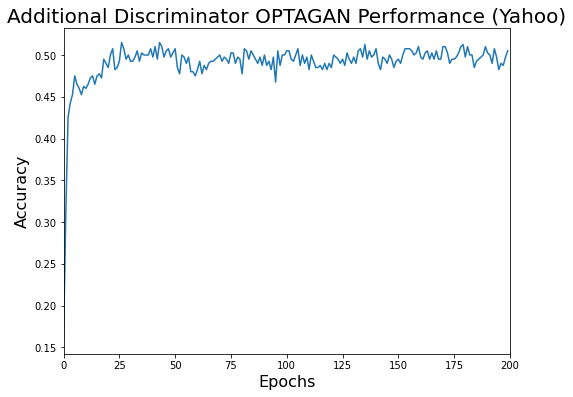

In [22]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_array)
plt.title('Additional Discriminator OPTAGAN Performance (Yahoo)', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0,200)
plt.show

In [20]:
df_to_save = pd.DataFrame(accuracy_array)
df_to_save.to_csv('accuracy_array_optagan_yahoo_nt_rt_768_0.csv')

In [21]:
# #Generating Sentences
# from __future__ import absolute_import, division, print_function, unicode_literals
# import argparse

# import logging
# import torch
# import torch.nn as nn
# import numpy as np

# from modules.gan import Generator

# import glob
# import os
# import pickle
# import random

# import torch.nn.functional as F
# from tqdm import tqdm, trange

# from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
# from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
# from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
# from func import XLNetLMHeadModel, XLNetTokenizer
# from func import TransfoXLLMHeadModel, TransfoXLTokenizer
# from func import BertForLatentConnector, BertTokenizer

# from collections import defaultdict
# import pdb
# from modules.utils import rollout_test

# MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop

# ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

# logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
#                     datefmt = '%m/%d/%Y %H:%M:%S',
#                     level = logging.INFO)
# logger = logging.getLogger(__name__)

# MODEL_CLASSES = {
#     'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
#     'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
#     'gpt2v': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer)
# }

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--seed', type=int, default=0)
#     parser.add_argument('--new_sent', type=int, default=1, help="Number of sentences to generate")
#     parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator")
#     parser.add_argument('--block_dim', type=int, default=100)
#     parser.add_argument('--interval', type=int, default=10)
#     parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
#     parser.add_argument('--generator_dir', default=None, type=str, required=True, help="Directory of GAN model checkpoint")
#     parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
#                         help="The directory where checkpoints are saved.")
#     parser.add_argument("--output_dir", default=None, type=str, required=True,
#                         help="The output directory where the model predictions and checkpoints will be written.")
#     parser.add_argument("--save", default=False, type=bool, help="Save results to file.")
#     parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
#     parser.add_argument("--output_name", default="results", type=str, help="File name of output")
#     parser.add_argument("--batch_size", default=100, type=int, help="Batch size to generate outputs")
#     ## Encoder options
#     parser.add_argument("--encoder_model_type", default="bert", type=str,
#                         help="The encoder model architecture to be fine-tuned.")
#     parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
#                         help="The encoder model checkpoint for weights initialization.")
#     parser.add_argument("--encoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--encoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     ## Decoder options
#     parser.add_argument("--decoder_model_type", default="gpt2", type=str,
#                         help="The decoder model architecture to be fine-tuned.")
#     parser.add_argument("--decoder_model_name_or_path", default="gpt2", type=str,
#                         help="The decoder model checkpoint for weights initialization.")
#     parser.add_argument("--decoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--decoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     parser.add_argument("--max_seq_length", default=512, type=int,
#                         help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")
#     parser.add_argument("--finetune_decoder", default=False, type=bool,
#                         help="Uses finetuned decoder in output dir if true.")

#     ## Variational auto-encoder(check this)
#     parser.add_argument("--top_k", type=int, default=0)
#     parser.add_argument("--top_p", type=float, default=1.0)
#     parser.add_argument("--prompt", type=str, default="")
#     parser.add_argument("--padding_text", type=str, default="")
#     parser.add_argument("--length", type=int, default=20)
#     parser.add_argument("--block_size", default=-1, type=int,
#                         help="Optional input sequence length after tokenization."
#                              "The training dataset will be truncated in block of this size for training."
#                              "Default to the model max input length for single sentence inputs (take into account special tokens).")
#     parser.add_argument("--do_lower_case", action='store_true',
#                         help="Set this flag if you are using an uncased model.")
#     parser.add_argument("--use_philly", action='store_true',
#                         help="Use Philly for computing.")
#     parser.add_argument('--gloabl_step_eval', type=int, default=508523,
#                         help="Evaluate the results at the given global step")

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     args = parser.parse_args("--checkpoint_dir=output_dir_yahoo_768_0 \
#     --output_dir=output_dir_yahoo_768_0 \
#     --generator_dir=output_dir_yahoo_768_0 \
#     --block_size 100 \
#     --max_seq_length 60 \
#     --gloabl_step_eval 24000 \
#     --latent_size 32 \
#     --block_dim 100 \
#     --new_sent 100 \
#     --n_layers 10 \
#     --top_p 0.9 \
#     --output_name=results \
#     --save True".split())
#     global_step = args.gloabl_step_eval

#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     torch.backends.cudnn.deterministic = True
#     args.device = torch.device("cuda" if args.cuda else "cpu")
#     args.n_gpu = torch.cuda.device_count()
#     if args.n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)       
    
#     args.encoder_model_type = args.encoder_model_type.lower()
#     args.decoder_model_type = args.decoder_model_type.lower()

#     output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
#     output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     if not args.finetune_decoder:
#         output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     else:
#          output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
#     checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
#     model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
#     tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

#     model_encoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

#     # Load a trained Decoder model and vocabulary that you have fine-tuned
#     if not args.finetune_decoder:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
#     else:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES["gpt2v"]
#     model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
#     tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
#     model_decoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

#     # Chunyuan: Add Padding token to GPT2
#     special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
#     num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
#     logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
#     model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
#     assert tokenizer_decoder.pad_token == '<PAD>'
    
#     generator = Generator(args.n_layers, args.block_dim, args.latent_size)

#     if args.cuda:
#         generator = generator.cuda()

#     generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
#     generator.eval()
#     model_decoder.eval()
#     model_encoder.eval()
#     if args.save:
#         if not os.path.exists(args.output_dir+"/{}.txt".format(args.output_name)):
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'w'): 
#                 pass

#     for i in range(int(args.new_sent/args.batch_size)):
#         # sample noise
#         noise = torch.Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_size))).to(args.device)
#         new_z = generator(noise).data

#         # create new sent
#         sents = rollout_test(model_decoder, new_z, tokenizer_decoder, args.max_seq_length, args.batch_size, args.top_k, args.top_p)

#         if args.save:
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'a') as file:
#                 for i in sents:
#                     file.write(i+"\n")
#         else:
#             for i in sents:
#                 logger.info(i)
